# Modelo de Propensão a Churn


* Este notebook apresenta a construção de um estudo voltado à identificação do melhor modelo de machine learning para a detecção e categorização, em percentis, de clientes propensos à evasão (churn), utilizando dados financeiros fictícios de correntistas. A análise segue as etapas da metodologia CRISP-DM.

* A abordagem será estruturada em cinco das seis etapas da metodologia. A etapa de Deploy (Implantação) não será totalmente executada; no entanto, o modelo será salvo como se estivesse pronto para produção.
    * Etapas: 

        * **Compreensão do Negócio** – Definição do problema e dos objetivos do projeto. 🟧

        * **Compreensão dos Dados** – Exploração inicial para entender a estrutura e qualidade dos dados.🟧

        * **Preparação dos Dados** – Tratamento, limpeza e transformação dos dados para a modelagem.🟧

        * **Modelagem** – Aplicação de algoritmos de machine learning para detectar padrões de fraude.🟧

        * **Avaliação** – Medição do desempenho do modelo para garantir sua eficácia.🟧

        * **Deploy** (Implantação) – Integração do modelo em um ambiente operacional para uso real.❌

# 1.Compreensão do Negócio

* A predição de churn (evasão de clientes) é um desafio estratégico para bancos e instituições financeiras, pois clientes insatisfeitos podem afetar diretamente as receitas, a imagem da marca e a confiança do mercado. Muitos desses clientes insatisfeitos apresentam reclamações não resolvidas, que podem evoluir para ações judiciais, reclamações em órgãos como o Procon ou junto a reguladores do setor, com impactos significativos na reputação e na operação da instituição. Antecipar esses casos permite ações preventivas, fortalece a fidelização de clientes e protege a sustentabilidade financeira e regulatória do negócio. Por isso, modelos de predição de churn são ferramentas valiosas para a gestão proativa do relacionamento com o cliente e para garantir a sustentabilidade operacional e reputacional das instituições financeiras.

* Objetivo do Projeto:

    * 1- Desenvolver uma análise exploratória que forneça informações sobre o comportamento dos clientes em risco de churn, identificando padrões e fatores que contribuem para a evasão. 🟧

    * 2- Desenvolver um modelo de Machine Learning capaz de identificar clientes com alta probabilidade de churn, separando a base de clientes em decis de probabilidade para permitir ações específicas em grupos de clientes com diferentes níveis de risco de evasão, otimizando as estratégias de retenção. 🟧




        * O modelo será avaliado com as seguintes métricas:

        * **Recall ≥ 91%** – Garantir que a maioria dos clientes com risco de churn seja identificada corretamente. 🟧

        * **AUC-ROC ≥ 95%** - Assegurar que o modelo consiga diferenciar bem entre clientes que vão churn e os que ficarão. 🟧

        * **F1-score ≥ 75%** – Manter um bom equilíbrio entre identificar corretamente os clientes com risco e evitar erros de classificação, minimizando falsos positivos e negativos. 🟧

           
        

* Restrições de Negócio

    Para atender a requisitos e garantir um modelo confiável:

    * Imparcialidade e Prevenção de Discriminação: 
    
        O modelo não deve apresentar tendências discriminatórias baseadas em atributos como gênero, idade, localização ou outros fatores socioeconômicos. Se esse tipo de varivel for interessante ao evento em estudo, deve se aplicar transformacoes nessas variaveis para que seja mitigada chance de vies descriminativo, 
        ex: idade, localizacao, genero. 🟧

 
    * Explicabilidade e Transparência

        O modelo deve ser interpretável tanto globalmente quanto localmente, garantindo que especialistas possam entender seus critérios de decisão. 
        ex: aplicar Técnicas como SHAP (SHapley Additive Explanations) e LIME (Local Interpretable Model-agnostic Explanations).🟧

* Escopo da Implantação
    * O modelo final será salvo para futuras implementações, mas a fase de Deploy não será completamente executada neste estudo.🟧



Os modelos serao xgboost, Catboost, GradientBoostingClassifier, MLPClassifier, LogisticRegression, KNeighborsClassifier

# 2.Compreensão dos Dados

## Importando Bibliotecas

In [1]:

import os
import time
import shutil
import warnings
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import combinations
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Estatísticas e Testes
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ML
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, brier_score_loss, log_loss,
    roc_curve, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay
)

# auxilixares 
import optuna
import torch
from dython.nominal import associations



from sklearn.metrics import *
from scipy.special import expit  # sigmoid




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

In [2]:
df_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#dimensoes 
print('df_treino dimensões:', f"{df_original.shape[0]:,}".replace(',', '.') + ' linhas, ' + f"{df_original.shape[1]:,}".replace(',', '.') + ' colunas')
print('')

df_original.head(5)


df_treino dimensões: 10.000 linhas, 18 colunas



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [3]:
#colunas e tipos de dados
print(df_original.columns)
print("")
print(df_original.dtypes)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object


In [4]:
#checando os valores null em cada variavel 
df_original.isnull().sum()  


RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [5]:
#contando a quantidade de zeros em cada coluna 

'''
    Dependendo da variável, a presença de valores zero pode carregar um significado importante. 
    O tratamento adequado desses zeros depende do contexto e da importância de cada variável no modelo, 
    podendo representar ausência real de informação,um comportamento específico do cliente ou até um dado 
    faltante codificado como zero.

    Isso sera observado e tratado em cada caso, aplicar um tratamento de zeros geral pode afetar o modelo.

'''

for col in df_original.columns:
    zero_count = (df_original[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")



 'RowNumber': 0 valores zero

 'CustomerId': 0 valores zero

 'Surname': 0 valores zero

 'CreditScore': 0 valores zero

 'Geography': 0 valores zero

 'Gender': 0 valores zero

 'Age': 0 valores zero

 'Tenure': 413 valores zero

 'Balance': 3617 valores zero

 'NumOfProducts': 0 valores zero

 'HasCrCard': 2945 valores zero

 'IsActiveMember': 4849 valores zero

 'EstimatedSalary': 0 valores zero

 'Exited': 7962 valores zero

 'Complain': 7956 valores zero

 'Satisfaction Score': 0 valores zero

 'Card Type': 0 valores zero

 'Point Earned': 0 valores zero


* descartando variaveis meramente identificadoras, sem influência no modelo

In [6]:
#meramente identificadoras: RowNumber, CustomerId e Surname

df_selecionado = df_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]



## 2.1 Análise Exploratória (EDA) 

### Dicionário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Point Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


### Análise das Variáveis Numéricas

* Analisando variaveis numéricas 
    - os df_anl_num criado e meramente pra separar de forma mais facil os tipos de numericas e categoricas 

In [7]:
df_selecionado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Geography           10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Complain            10000 non-null  int64  
 11  Satisfaction Score  10000 non-null  int64  
 12  Card Type           10000 non-null  object 
 13  Point Earned        10000 non-null  int64  
 14  Exited              10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [8]:
pd.options.display.float_format = '{:.2f}'.format  # config 2 casas decimais para configurar o describe
df_selecionado.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20,3.01,606.52,0.20
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40,1.41,225.92,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00,1.00,119.00,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00,2.00,410.00,0.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00,3.00,605.00,0.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00,4.00,801.00,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00,5.00,1000.00,1.00


- Podemos ver que existem algumas variaveis que embora sejam numéricas originalmente, são na verdade categóricas e até mesmo ordinais, elas vao ser separadas apenas para analise, e nas transformacoes pre-modelo vao ser tratadas da forma ideal. 

    * **NumOfProducts** é uma variável categórica Ordinal; 
    * **HasCrCard** é binária (embora para o modelo seja numérica, 0 ou 1 impõe distinção de categorias ("Sim" e "Não")); 
    * **IsActiveMember**  Binária também; 
    * **Complain** Binária também; 
    * **Satisfaction Score** é uma variável categórica Ordinal; 

    * **Exited** é a alvo, mas também binária. 




In [9]:
#print(df_selecionado.dtypes) #so pra fazer o check

df_anl_num = df_selecionado[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']]
df_anl_num.head(5)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Point Earned
0,619,42,2,0.00,101348.88,464
1,608,41,1,83807.86,112542.58,456
2,502,42,8,159660.80,113931.57,377
3,699,39,1,0.00,93826.63,350
4,850,43,2,125510.82,79084.10,425


#### **CreditScore**

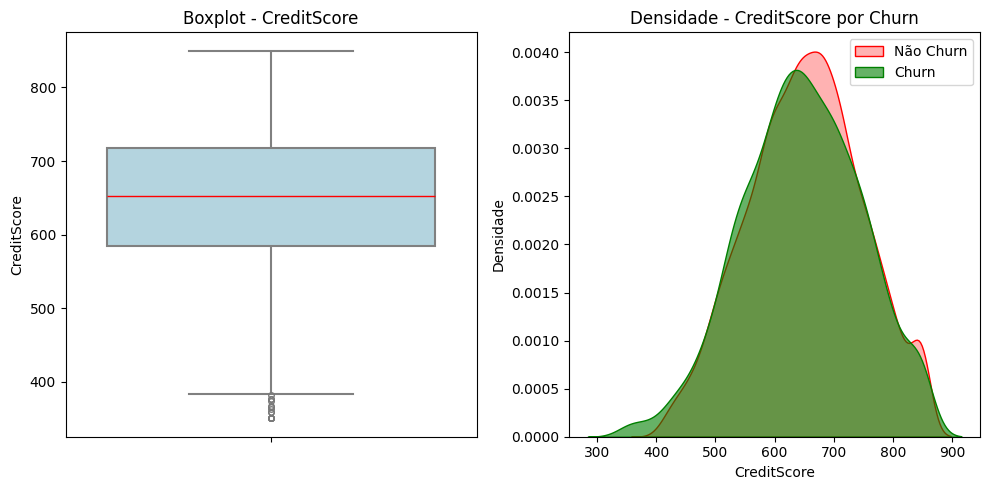

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot 
sns.boxplot(
    y=df_anl_num['CreditScore'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - CreditScore')
axes[0].set_ylabel('CreditScore')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['CreditScore'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['CreditScore'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - CreditScore por Churn')
axes[1].set_xlabel('CreditScore')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 observações, sem valores ausentes.
- **Mean (650,53)**: A média indica uma pontuação de crédito considerada razoável em relaçao as min e max 
- **Std (96,65)**: A variação mostra que há clientes com scores muito distintos.
- **Min (350)**: clientes com baixo score e portanto maior risco de crédito.
- **25% (584)**: Um quarto dos clientes tem score abaixo de 584.
- **50% (652)**: A mediana está próxima da média, indicando distribuição relativamente simétrica.
- **75% (718)**: 75% dos clientes têm até 718 pontos.
- **Max (850)**: Alguns clientes têm score excelente.
    - Aqui temos alguns outliers, serão considerados na transformação de dados para o modelo


- As distribuiçoes entre as classes de churn sao bem parecidas, com churn com pico um pouco mais elevado mas na mesma faixa. De de forma geral, estão com maior densidade entre 600 e 700 de score, valores bastante auto, indicando bom score de crédito para maioria de clientes 


#### **Age**

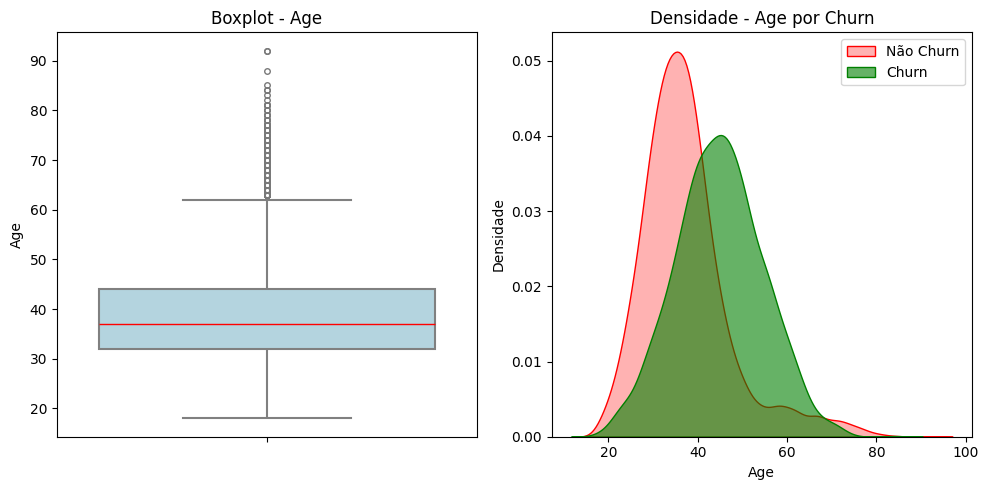

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Age'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Age')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Age'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Age'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Age por Churn')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Densidade')
axes[1].legend()


plt.tight_layout()
plt.show()



- **Count**: 10.000 observações, sem valores ausentes.
- **Mean (38,92)**: A idade média dos clientes é de cerca de 39 anos.
- **Std (10,49)**: A dispersão é razoável, com clientes de várias faixas etárias.
- **Min (18)**: Sao os clientes mais jovens, mas nenhum menor de idade. 
- **25% (32)**: Um quarto dos clientes tem até 32 anos.
- **50% (37)**: A mediana mostra uma concentração em torno dos 37 anos. (e o gráfico de densidade também)
- **75% (44)**: 75% dos clientes têm até 44 anos.
- **Max (92)**: Há clientes idosos na base, chegando a 92 anos.

    - Aqui temos alguns outliers, serão considerados na transformação de dados para o modelo
 - Observa-se uma diferença significativa nas distribuições de idade entre clientes que deram churn e os que permaneceram. A maior densidade de clientes que **não deram churn** está concentrada na faixa de **25 a 40 anos**, enquanto os clientes que **deram churn** apresentam uma concentração mais acentuada entre **40 e 45 anos**. Isso sugere uma possível relação entre idade e propensão ao churn.

#### **Tenure**

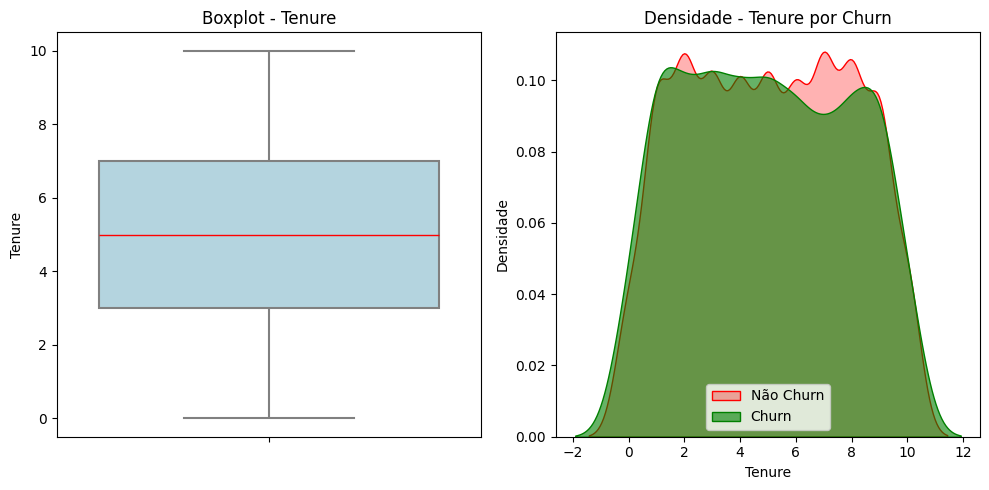

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Tenure'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Tenure')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Tenure'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Tenure'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Tenure por Churn')
axes[1].set_xlabel('Tenure')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 registros, sem valores ausentes.
- **Mean (5,01)**: Em média, os clientes têm 5 anos de banco.
- **Std (2,89)**: A variação é pequena, indicando tempos de casa parecidos.
- **Min (0)**: Provaveis novos clientes.
- **25% (3)**: Um quarto dos clientes tem até 3 anos de relacionamento.
- **50% (5)**: A mediana coincide com a média, sugerindo distribuição simétrica. (gráfico de densidade também sugere isso)
- **75% (7)**: 75% dos clientes têm até 7 anos no banco.
- **Max (10)**: Alguns clientes têm até 10 anos de relacionamento.



#### **Balance**

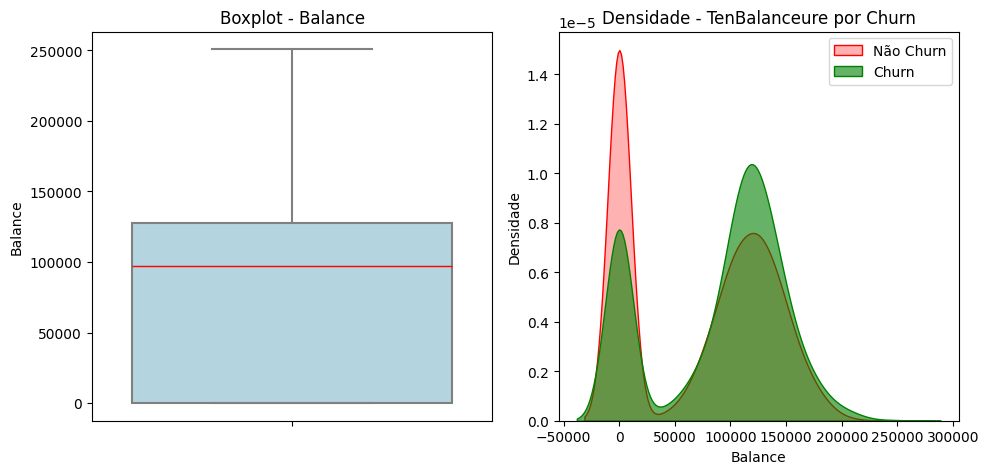

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Balance'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Balance')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Balance'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Balance'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - TenBalanceure por Churn')
axes[1].set_xlabel('Balance')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 clientes, sem valores ausentes.
- **Mean (76.485,89)**: Saldo médio de R$ 76 mil.
- **Std (62.397,41)**: Alta variabilidade de saldos entre os clientes, o que e aceitável e até esperado. 
- **Min (0,00)**: Há clientes sem saldo.
- **25% (0,00)**: Um quarto dos clientes tem saldo zerado.
- **50% (97.198,54)**: A mediana é alta, sugerindo concentração nos que possuem saldo elevado.
- **75% (127.644,24)**: Um quarto dos clientes têm saldo acima de R$ 127 mil.
- **Max (250.898,09)**: Alguns clientes possuem saldos muito altos, ate em relacao aos 75%.

**Postos de atenção e riscos**
- Pelo gráfico de densidade, observa-se uma alta concentração de valores iguais a zero, indicando **dados inflados de zero**, seguida de uma distribuição aproximadamente normal nos demais valores. Nota-se que **clientes churn** apresentam **menor densidade** nos pontos inflados de zero e maior densidade na faixa **entre 100.000 e 150.000**, o que pode indicar uma relação entre valores não nulos mais elevados e a propensão ao churn.

- A variável apresenta distribuição muito desigual, com **25% dos clientes tendo saldo zero**, enquanto a mediana é de cerca de R$ 97 mil e o máximo ultrapassa R$ 250 mil — o que explica o desvio padrão elevado.
- Esse cenário pode distorcer o aprendizado do modelo, acho que será necessário:
    - Criar uma variável binária indicando se o cliente tem saldo ou não;
    - Aplicar transformações como StandardScaler para reduzir a influência dos valores extremos (outlier ainda seria um problema mas aqui nao tem aparentes outliers).

#### **EstimatedSalary**

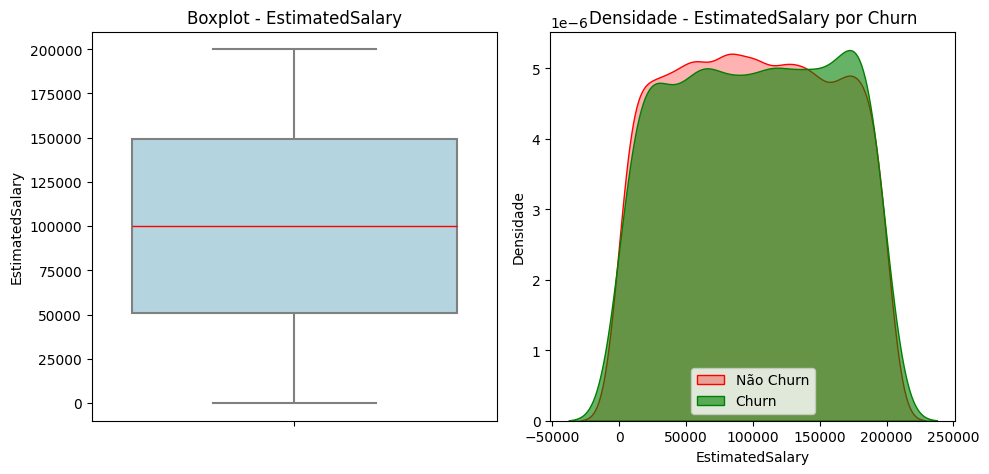

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['EstimatedSalary'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - EstimatedSalary')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['EstimatedSalary'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['EstimatedSalary'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - EstimatedSalary por Churn')
axes[1].set_xlabel('EstimatedSalary')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()


- **Count**: 10.000 observações, sem valores ausentes.  
- **Mean (R$ 100.090,24)**: Salário médio estimado de aproximadamente R$ 100 mil.  
- **Std (R$ 57.510,49)**: Alta dispersão na distribuição de salários entre os clientes.  
- **Min (R$ 11,58)**: Existem clientes com rendas bastante baixas.  
- **25% (R$ 51.002,11)**: Um quarto dos clientes ganha até R$ 51 mil.  
- **50% (R$ 100.193,91)**: A mediana indica que metade dos clientes ganha até R$ 100 mil.  
- **75% (R$ 149.388,25)**: Um quarto dos clientes ganha acima de R$ 149 mil.  
- **Max (R$ 199.992,48)**: Valor máximo de salário observado.



**Postos de atenção e riscos**
- Alta dispersão salarial: os valores variam de **R$ 11 até quase R$ 200 mil**, com média e mediana próximas a R$ 100 mil. (desvio padrão alto).
- Apesar da amplitude, a distribuição é próxima da uniforme, sem indícios de outliers ou assimetrias relevantes.
- escalonamento (StandardScaler ou MinMaxScaler) para compatibilidade com algoritmos sensíveis à escala pode ser necessário

#### **Point Earned**

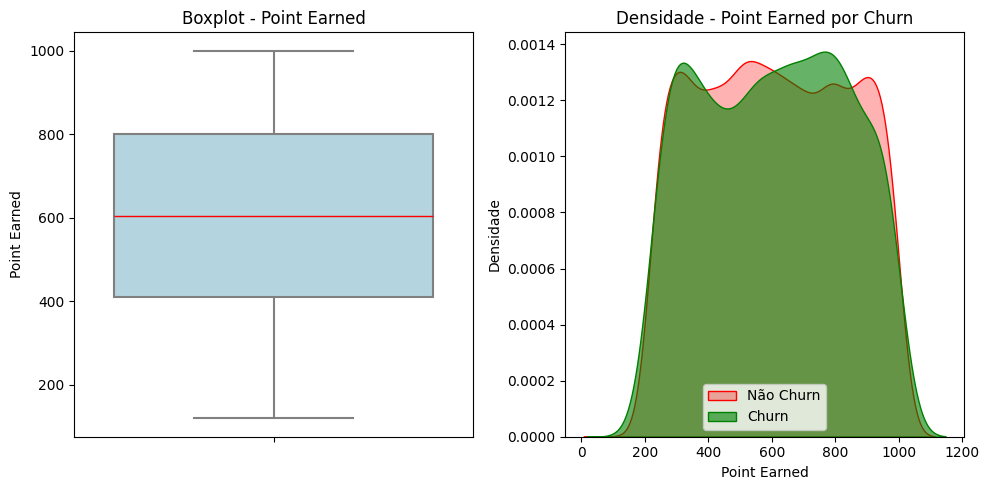

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Point Earned'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Point Earned')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Point Earned'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Point Earned'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Point Earned por Churn')
axes[1].set_xlabel('Point Earned')
axes[1].set_ylabel('Densidade')
axes[1].legend()


plt.tight_layout()
plt.show()



- **Count**: 10.000 registros, sem valores ausentes.  
- **Mean (606,52)**: Média de pontos ganhos pelos clientes.  
- **Std (225,92)**: Boa dispersão, sugerindo diferentes níveis de engajamento.  
- **Min (119)**: Alguns clientes apresentam pontuação baixa.  
- **25% (410)**: Um quarto dos clientes tem até 410 pontos.  
- **50% (605)**: A mediana indica até 605 pontos para metade da base.  
- **75% (801)**: Um quarto dos clientes apresenta pontuação mais alta, acima de 801.  
- **Max (1000)**: Alguns clientes atingiram a pontuação máxima.

**Pontos de atenção**
- Ampla variação: pontuações vão de 119 a 1000.  
- Pode estar correlacionada com variáveis de engajamento como `IsActiveMember` ou `NumOfProducts`.  
- Importante verificar redundância com outras variáveis para evitar multicolinearidade.


#### **Correlação entre Numéricas e Target** 

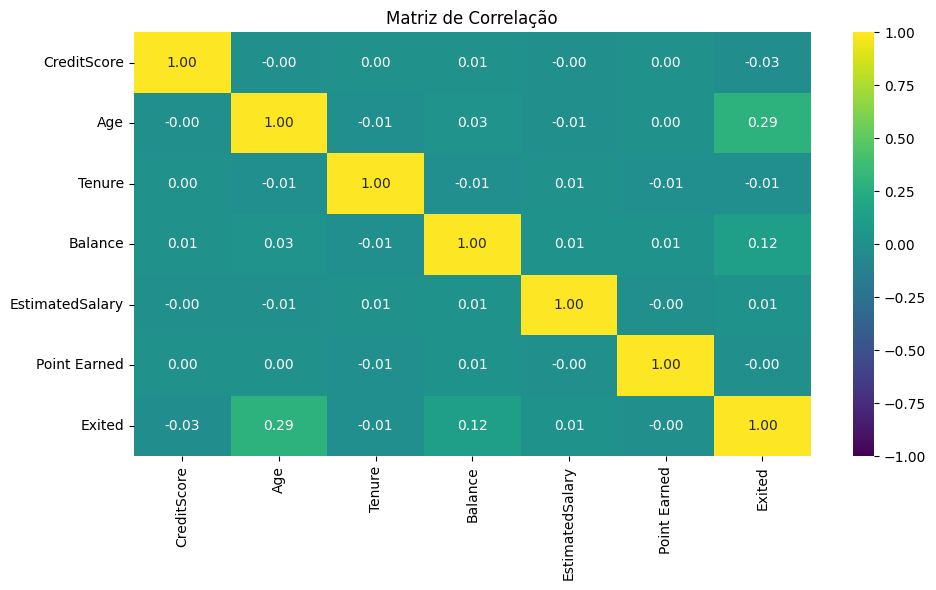

In [16]:
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

#só pra pra matrix de correlacao
df_anl_num_com_exited = df_selecionado[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 
                                        'Point Earned','Exited']] 



# Criar a fig com 1 subgráfico
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

#gráfico de Correlação (Matriz de Correlação)
sns.heatmap(df_anl_num_com_exited.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')
plt.tight_layout()
plt.show()


* Com base na matriz de correlação, não foram identificadas evidências de multicolinearidade entre as variáveis explicativas, uma vez que os coeficientes de correlação estão todos abaixo de 0,80 (modualarmente falando, tanto positiva quanto negativamente). No entanto, a variável **Complain** apresenta correlação perfeita (1.00) com a variável alvo **Exited**, o que indica possível vazamento de informação (data leakage). Por isso, essa variável vai ser testada: o modelo vai ser testado com e sem ela para ver se impacta no desempenho. 

## Análise das Variáveis Categóricas

* Analisando variáveis categóricas 

In [17]:
'''selecioanndo as categoricas: 
    -excluindo as do df_anl_num 
    - adicionando a target '''

df_anl_cat = df_selecionado[[col for col in df_selecionado.columns if col not in df_anl_num.columns]]
df_anl_cat['Exited'] = df_selecionado['Exited']



In [18]:
df_anl_cat.columns

Index(['Gender', 'Geography', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Complain', 'Satisfaction Score', 'Card Type', 'Exited'],
      dtype='object')

#### **Gender**

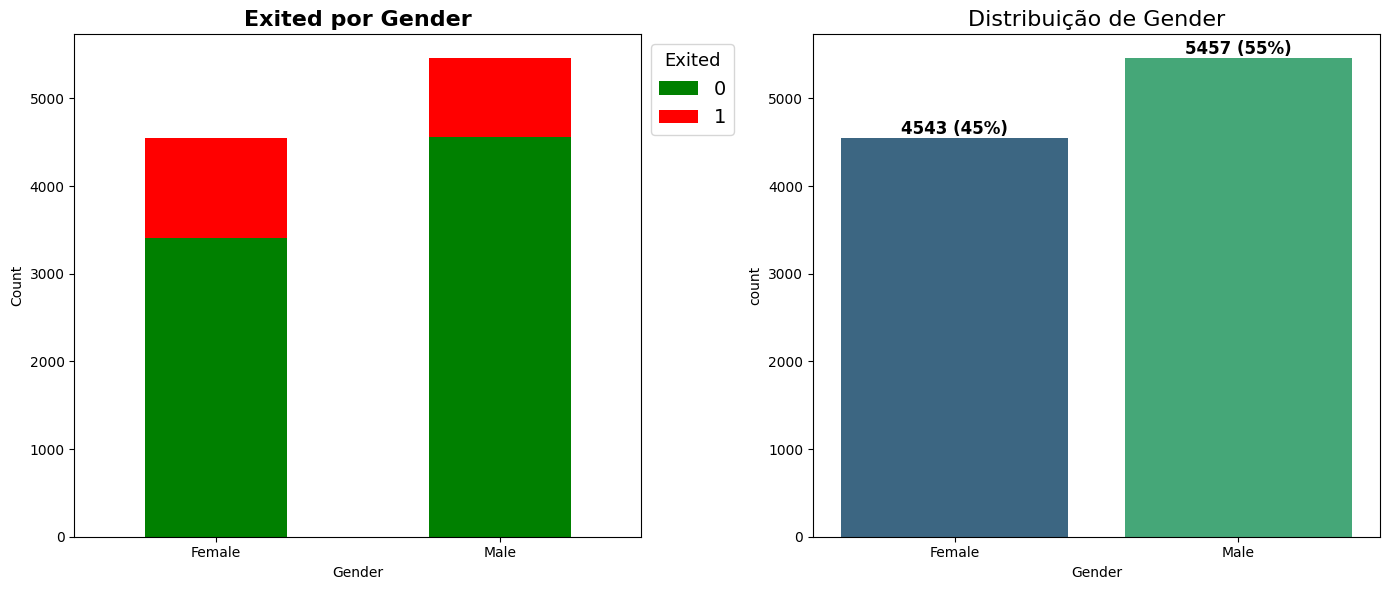

In [19]:
def add_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',
              bbox_to_anchor=(1.0, 1))
    



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Gender
counts = df_anl_cat.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Gender', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Gender', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Gender'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Gender', fontsize=16)
total = len(df_anl_cat['Gender'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A quantidade de clientes do sexo masculino é levemente superior. Observa-se uma proporção de churn com desbalanceamento evidente — uma tendência que se repete em praticamente todas as variáveis analisadas.

#### **Geography**

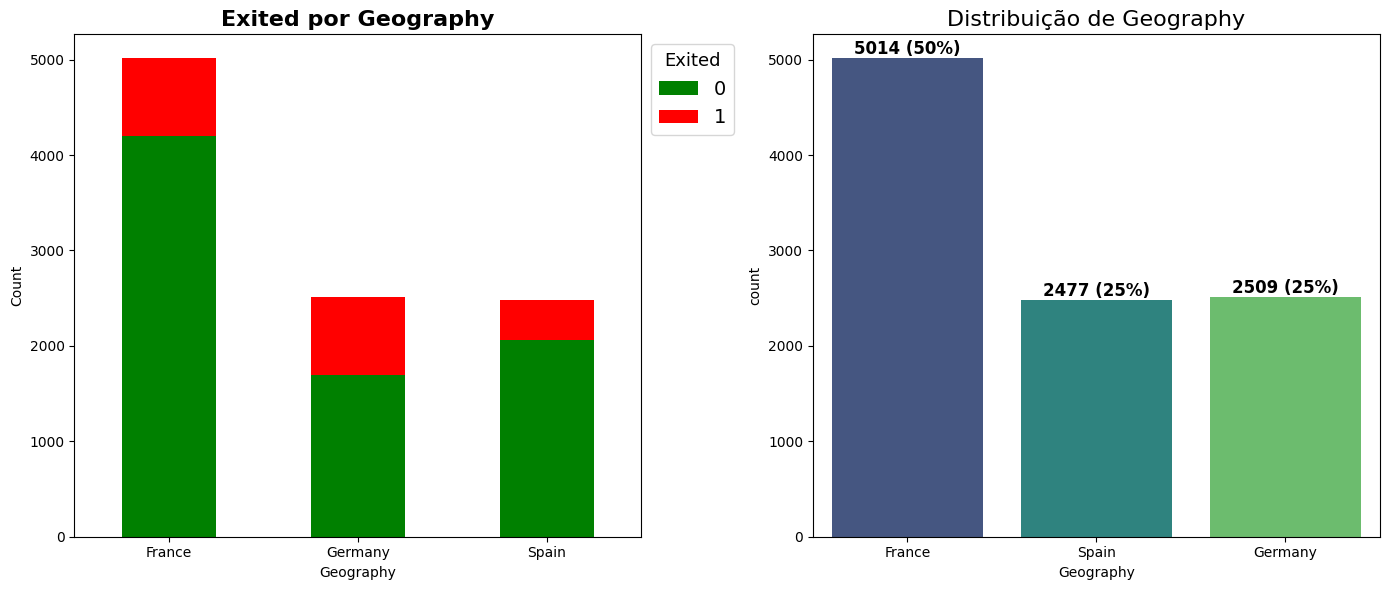

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Geography
counts = df_anl_cat.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Geography', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Geography', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Geography'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Geography', fontsize=16)
total = len(df_anl_cat['Geography'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


* A França se destaca em volume em relação às demais categorias geográficas. Apesar de sua maior representatividade na base, a proporção de churn é praticamente equivalente à observada nos outros países.

#### **NumOfProducts**

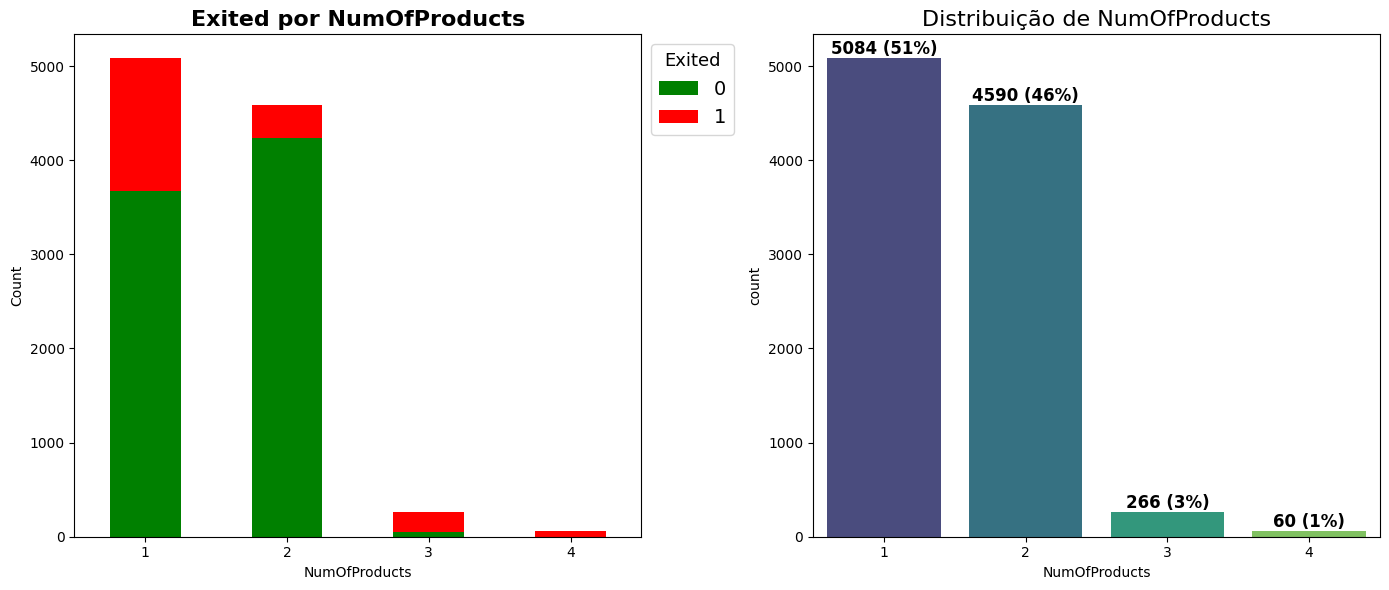

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por NumOfProducts
counts = df_anl_cat.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por NumOfProducts', fontsize=16, fontweight='bold')
axes[0].set_xlabel('NumOfProducts', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['NumOfProducts'], ax=ax, palette='viridis')
ax.set_title('Distribuição de NumOfProducts', fontsize=16)
total = len(df_anl_cat['NumOfProducts'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A maior parte dos clientes possui 1 ou 2 produtos, sendo essas as categorias mais frequentes. Observa-se que clientes com apenas 1 produto apresentam uma taxa de churn proporcionalmente maior, inclusive quando comparados àqueles com 2 produtos — mesmo com volumes semelhantes. De forma geral, quanto maior o número de produtos, menor tende a ser a probabilidade de churn.

#### **HasCrCard**

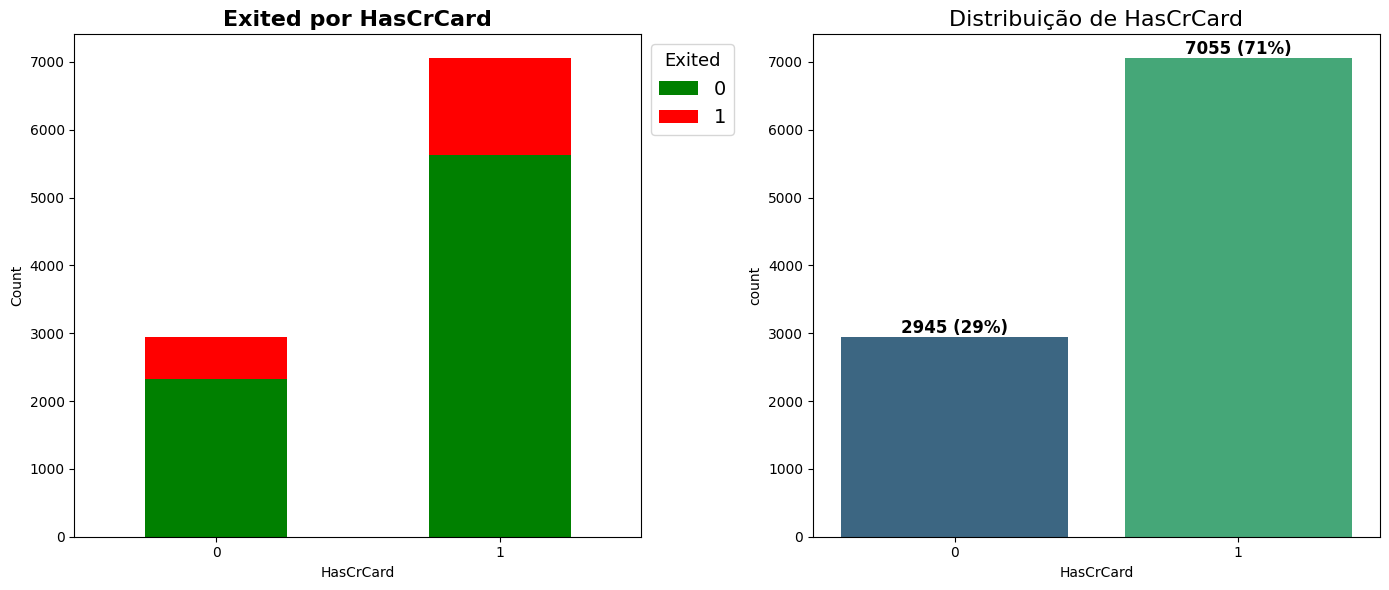

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por HasCrCard
counts = df_anl_cat.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por HasCrCard', fontsize=16, fontweight='bold')
axes[0].set_xlabel('HasCrCard', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['HasCrCard'], ax=ax, palette='viridis')
ax.set_title('Distribuição de HasCrCard', fontsize=16)
total = len(df_anl_cat['HasCrCard'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A maioria dos clientes possui cartão de crédito. A distribuição de churn dentro dessa variável também apresenta desbalanceamento, mantendo o padrão observado nas demais variáveis.

#### **IsActiveMember**

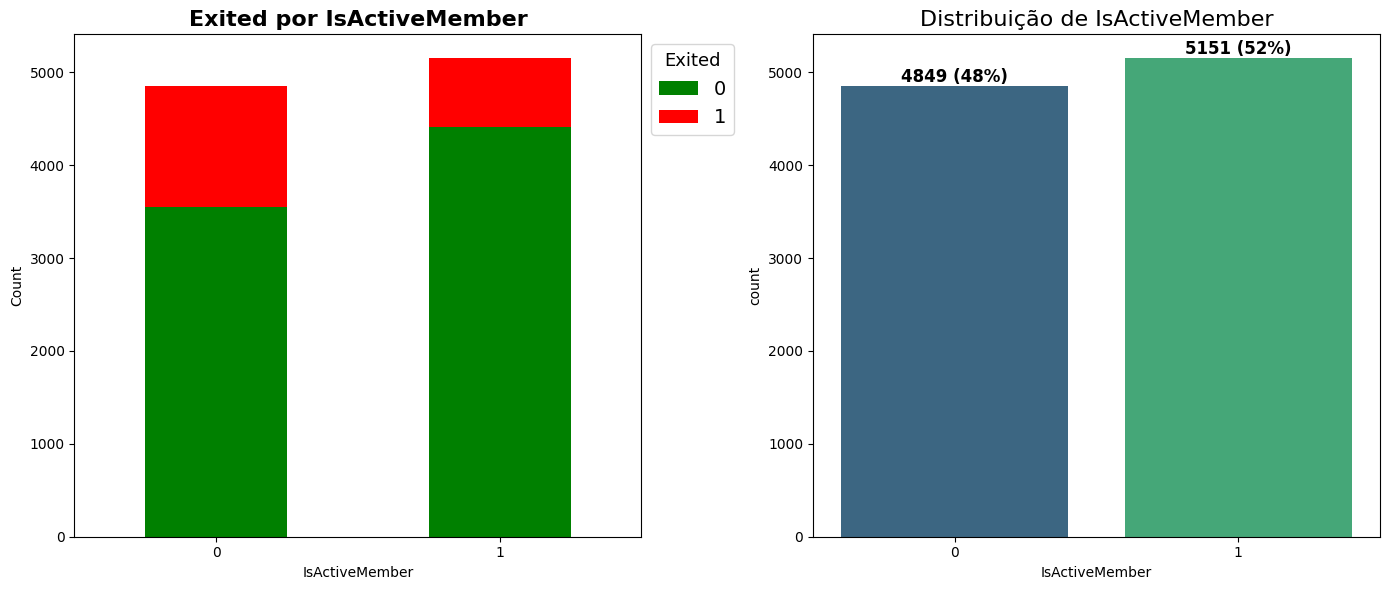

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por IsActiveMember
counts = df_anl_cat.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por IsActiveMember', fontsize=16, fontweight='bold')
axes[0].set_xlabel('IsActiveMember', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['IsActiveMember'], ax=ax, palette='viridis')
ax.set_title('Distribuição de IsActiveMember', fontsize=16)
total = len(df_anl_cat['IsActiveMember'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- Clientes ativos e não ativos apresentam proporções quase iguais na base. No entanto, a incidência de churn é maior entre os clientes não ativos, o que pode indicar uma tendência relevante para análise.

#### **Complain**

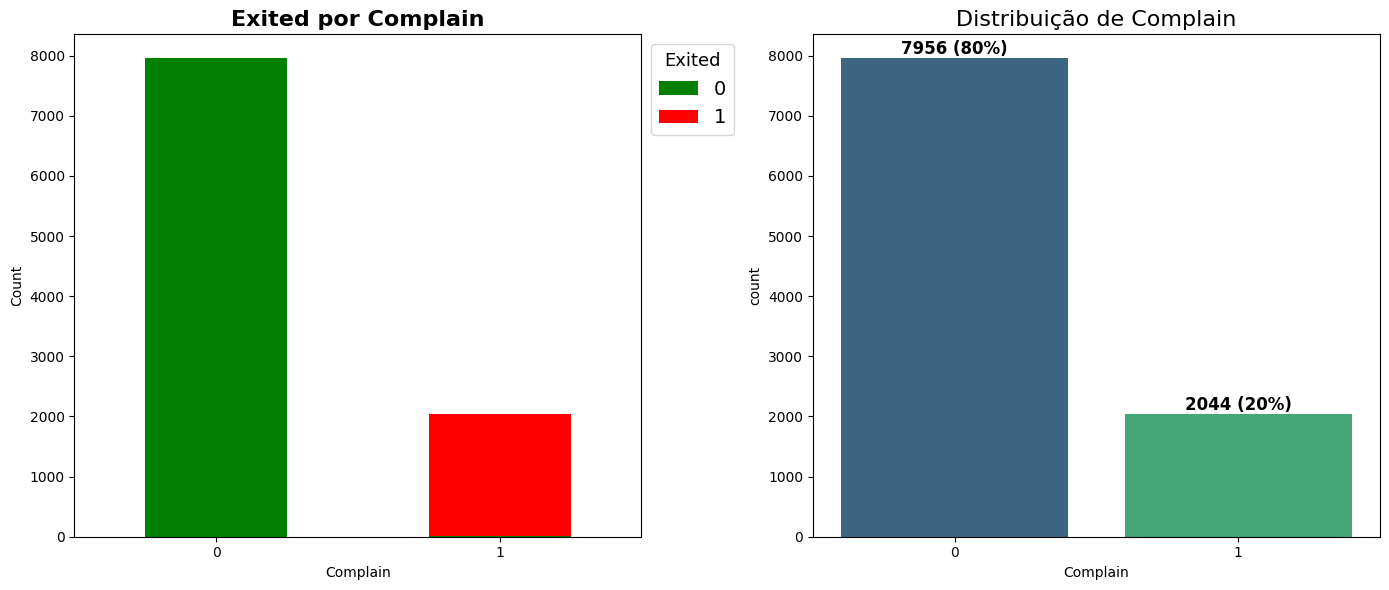

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Complain
counts = df_anl_cat.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Complain', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Complain', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Complain'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Complain', fontsize=16)
total = len(df_anl_cat['Complain'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- Há um número significativamente menor de clientes que fizeram reclamação; contudo, praticamente 100% desses clientes apresentaram churn. Isso representa um possível risco para o modelo, pois pode haver um vazamento de dado e uma possivel correlação quase perfeita com a variável target; isso será testado mais adiante. 

#### **Satisfaction Score**

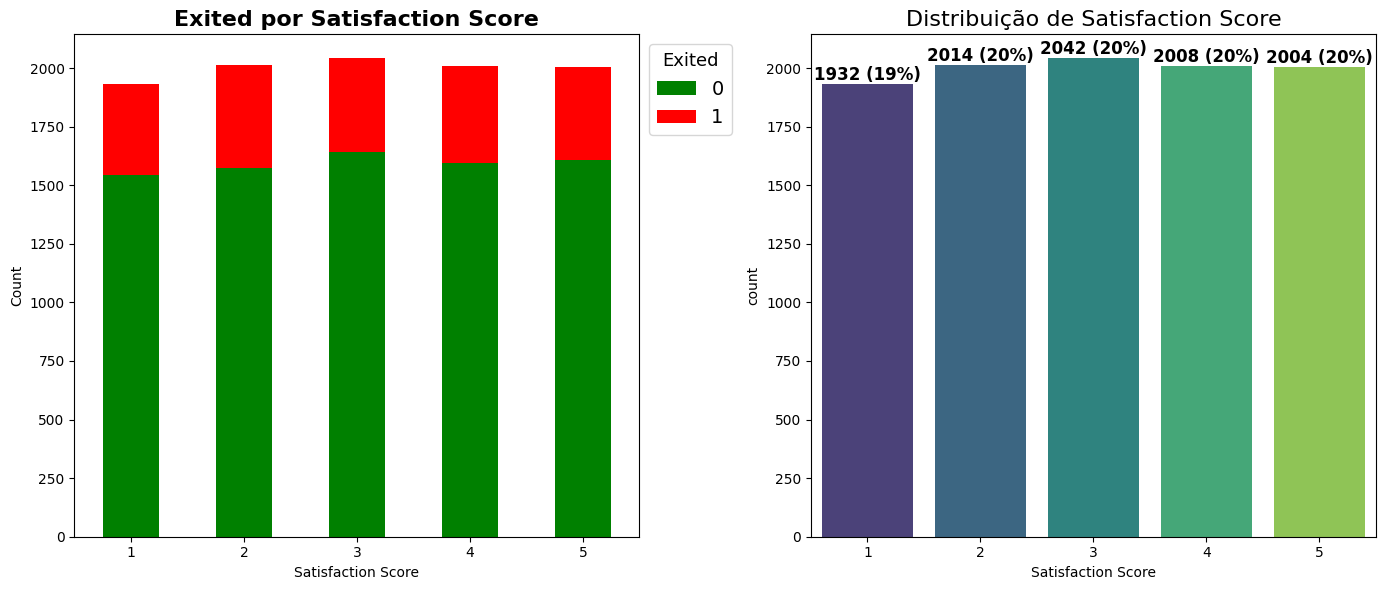

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Complain
counts = df_anl_cat.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Satisfaction Score', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Satisfaction Score', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Satisfaction Score'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Satisfaction Score', fontsize=16)
total = len(df_anl_cat['Satisfaction Score'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A distribuição dos clientes entre as categorias dessa variável é quase uniforme, apresentando uma boa representatividade em cada grupo. O desbalanceamento de churn também acompanha essa distribuição, mantendo-se relativamente equilibrado dentro de cada categoria.

#### **Card Type**

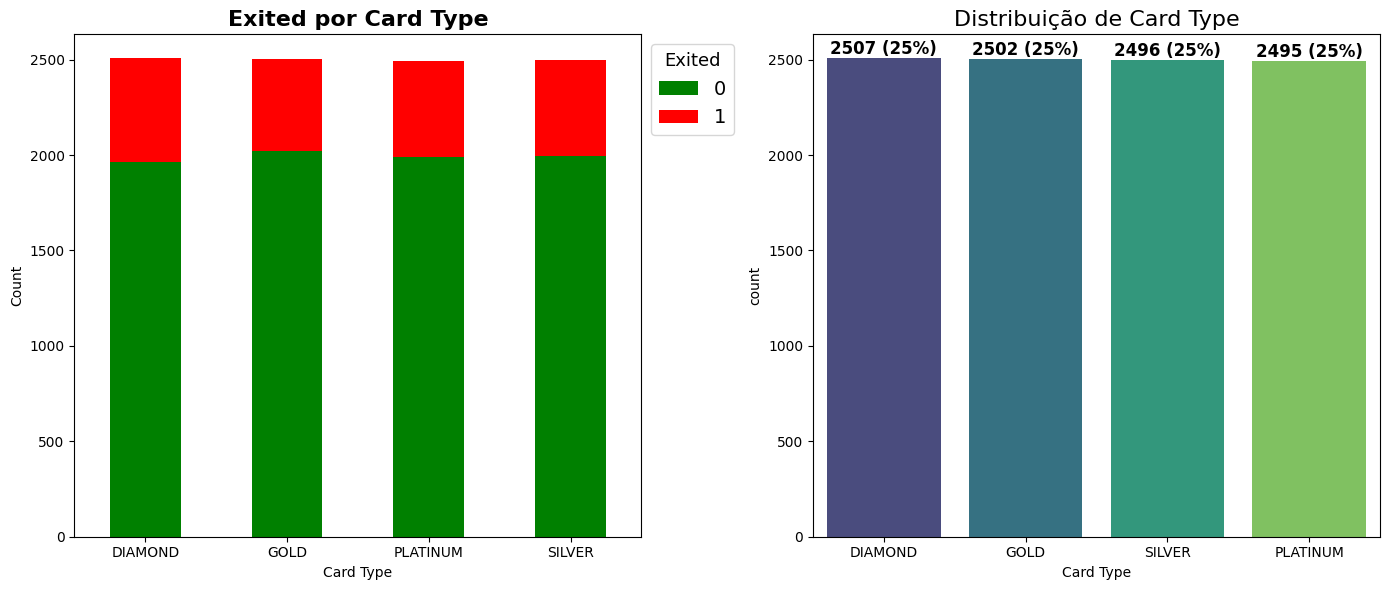

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Card Type
counts = df_anl_cat.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Card Type', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Card Type', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
# Se tiver uma função add_legend, chama aqui
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Card Type'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Card Type', fontsize=16)
total = len(df_anl_cat['Card Type'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A distribuição dos clientes entre as categorias dessa variável é quase uniforme, apresentando uma boa representatividade em cada grupo. O desbalanceamento de churn também acompanha essa distribuição, mantendo-se relativamente equilibrado dentro de cada categoria.

#### **Exited (Target)**

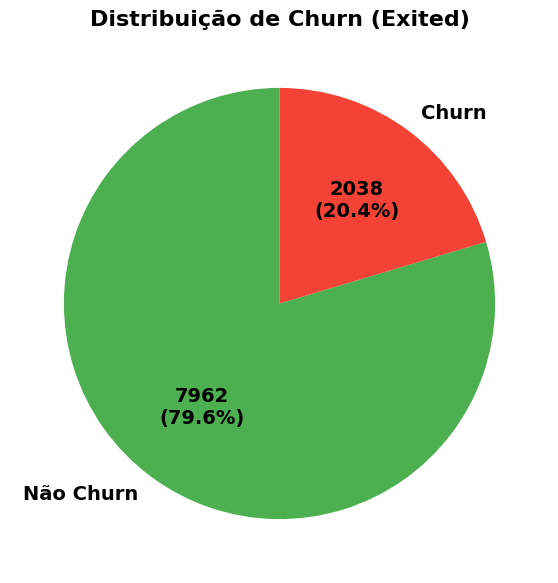

In [27]:
# Contagem das classes de churn
counts_exited = df_anl_cat['Exited'].value_counts()
labels = counts_exited.index.map({0: 'Não Churn', 1: 'Churn'})

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}\n({pct:.1f}%)'
    return my_autopct

plt.figure(figsize=(7,7))
plt.pie(counts_exited, labels=labels, autopct=make_autopct(counts_exited), 
        startangle=90, colors=['#4CAF50', '#F44336'], textprops={'fontsize': 14, 'fontweight': 'bold'})
plt.title('Distribuição de Churn (Exited)', fontsize=16, fontweight='bold')
plt.show()


- Nesse caso, o desbalanceamento das classes fica ainda mais evidente ao analisarmos diretamente a variável target. Embora não se trate de um caso típico de evento raro — geralmente definido quando a classe minoritária representa menos de 5% dos casos — a desproporção observada ainda justifica a aplicação de técnicas para mitigar o desbalanceamento, a fim de melhorar a performance e a robustez dos modelos.

#### **Associação com V de Cramer e Qui2: vars categóricas** 

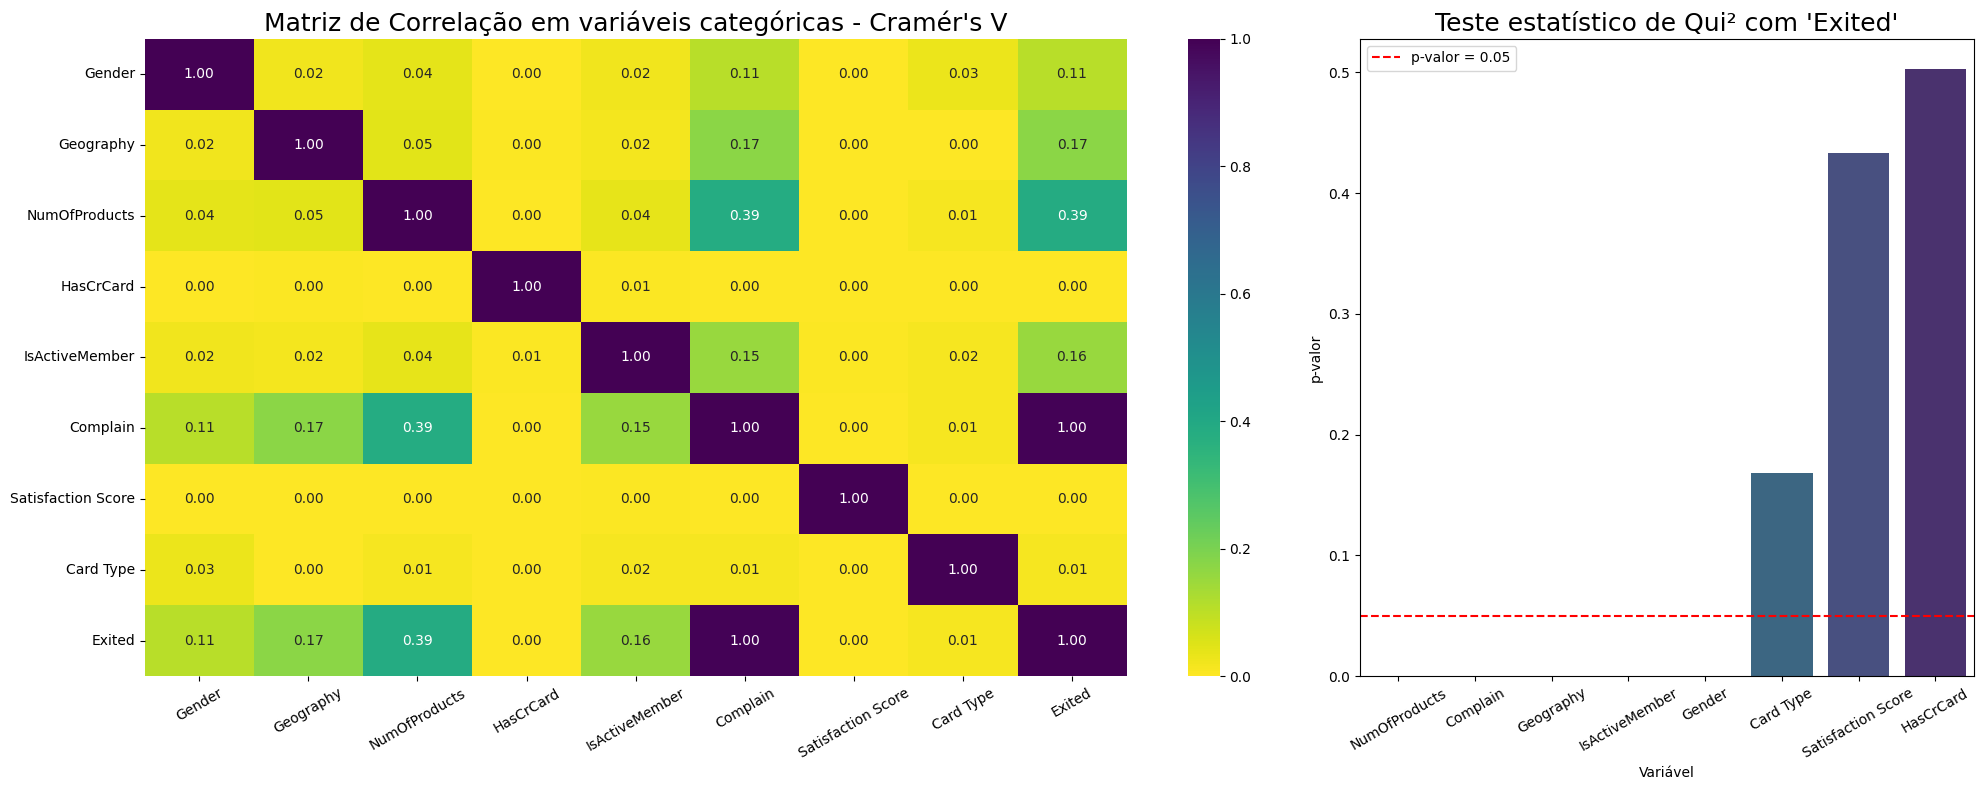

In [28]:
def calcular_V_de_Cramer_matrix(df, incluir_target=True, target='Exited'):

    '''Essa funcao cria o teste de Cramer e retorna uma matriz com os resultados'''

    cat_cols = df.columns.tolist() if incluir_target else [col for col in df.columns if col != target]
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for col1, col2 in combinations(cat_cols, 2):
        tabela = pd.crosstab(df[col1], df[col2])
        chi2 = chi2_contingency(tabela)[0]
        n = tabela.sum().sum()
        phi2 = chi2 / n
        r, k = tabela.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        cramer_matrix.loc[col1, col2] = v
        cramer_matrix.loc[col2, col1] = v

    np.fill_diagonal(cramer_matrix.values, 1.0)
    return cramer_matrix

def teste_qui2(df, target='Exited', min_categories=2 ):

    '''Função para calcular os p-valores do teste Qui²

        Parâmetros:
    
        df : pd.DataFrame -> DataFrame contendo as variáveis categóricas (target junto).
        target : str -> determinar quem vai ser a target ('Exited')
        min_categories : int, default 2 -> Número mínimo de categorias para a variável ser 
                                            considerada para o teste (evita erros com variáveis constantes).
        
    
    '''

    p_values = {}
    
    for col in df.columns:
        if col == target:
            continue
        
        # Ignorar variáveis com poucas categorias (constantes)
        if df[col].nunique() < min_categories:
            p_values[col] = np.nan
            continue
        
        try:
            contingency = pd.crosstab(df[col], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency)
            p_values[col] = p
        except (ValueError, pd.errors.PerformanceWarning) as e:
            #adicionar tratamento dos tipos de exceções conforme ocorrerem 
            p_values[col] = np.nan
            
    return pd.Series(p_values).sort_values()




# Aplica as defs
cramer_matrix = calcular_V_de_Cramer_matrix(df_anl_cat)
pval_series = teste_qui2(df_anl_cat, target='Exited')

# Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1]})

# Heatmap de Cramér's V
sns.heatmap(cramer_matrix.astype(float), annot=True, cmap='viridis_r', fmt=".2f", ax=ax1)
ax1.set_title("Matriz de Correlação em variáveis categóricas - Cramér's V", fontsize=18)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

# Gráfico de barras com p-valores
sns.barplot(x=pval_series.index, y=pval_series.values, palette="viridis_r", ax=ax2)
ax2.axhline(y=0.05, color='red', linestyle='--', label='p-valor = 0.05')
ax2.set_ylabel("p-valor")
ax2.set_xlabel("Variável")
ax2.set_title("Teste estatístico de Qui² com 'Exited'", fontsize=18)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax2.legend()

plt.tight_layout()
plt.show()


* Para interpretar os dois testes: 

    - Teste Qui2: verifica se há associação significativa entre duas variáveis categóricas (p < 0,05 indica associação).

    - Cramér's V: mede a força da associação entre variáveis categóricas, variando de 0 (nenhuma) a 1 (forte).

- Card Type, Satisfaction Score e HasCrCard apresentaram p > 0,05 e valores muito baixos em Cramér's V, indicando associação fraca ou inexistente com a variável alvo, são fortes candidatas a não permanecer no modelo, mas isso será testado. 

- Por outro lado, NumOfProducts, Geography e IsActiveMember mostraram valores elevados na matriz de Cramér's V, sugerindo associação mais forte com a variável alvo.

### "Correlação" de todas variáveis, principalmente numéricas vs categoricas 

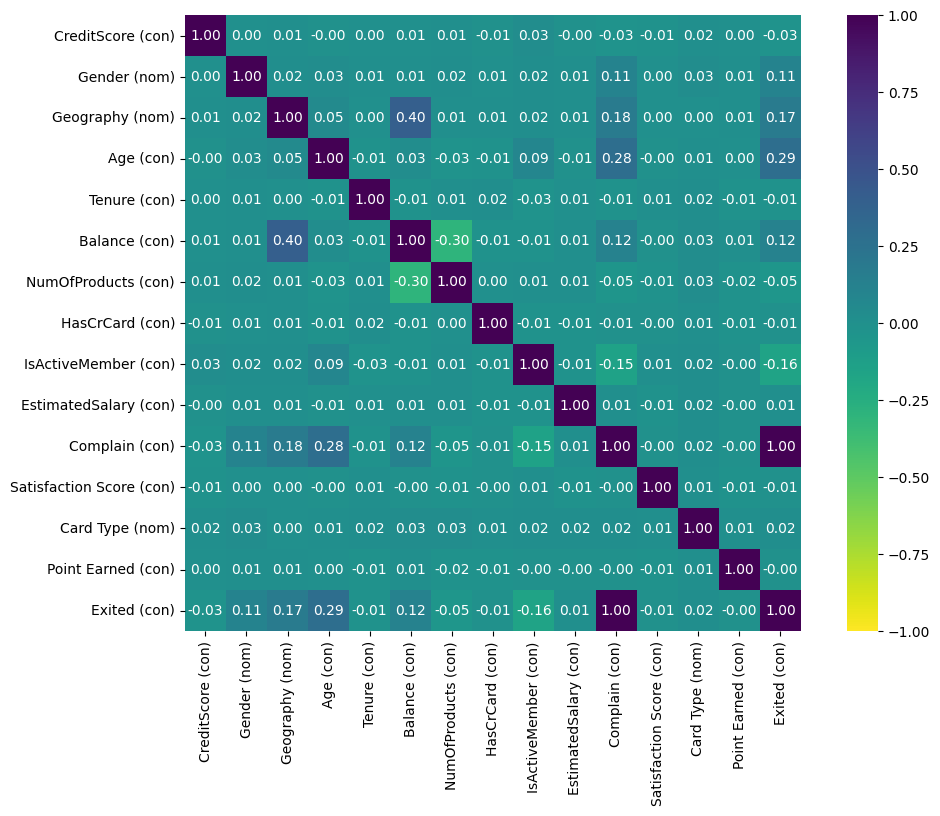

In [29]:
# Matriz de correlação mista 
associacoes = associations(
    df_selecionado,
    nominal_columns='auto',
    mark_columns=True,
    plot=True,
    figsize=(12, 8),
    cmap='viridis_r'
    
)


- nom → variáveis nominais, ou seja, categóricas

- con → variáveis contínuas, ou numéricas

- Para medir a associação entre as variáveis, são usados métodos diferentes dependendo dos tipos:

    - **Correlação de Pearson** para variáveis numéricas vs numéricas

    - **Cramér’s V** para variáveis categóricas vs categóricas

    - **Correlation Ratio (η² ou Eta squared), uma medida de associação baseada em análise de variância (baseado na ANOVA)** para numéricas vs categóricas

* Os valores obtidos para Cramér’s V e Pearson podem não ser diretamente comparáveis( tem ate leves diferencas com os testes aplicados anteriormente), pois medem associações diferentes, mas o objetivo é **analisar as relações entre variáveis numéricas e categóricas**.
    * Nenhum impacto relevante foi observado nas associações.

# 3. Preparação dos Dados: Feature Engineering

- pensar e pesquisar a criacao de novas fetures que ajudem 

    - Exemplo: balance tem muitos zeros, criar uma variavel de zero_flag indicando se e um cliente sem saldo na conta para evitar que o modelo aprenda demais com essa inflacao de zeros na var original



## **IMPORTANTE: todas serão testadas importância e o impacto, se positivo ou negativo, no modelo, para avaliar se há ganho em usa-las**

## 3.1 Faixas de CreditScore 

- Categorização da variavel de credit Score, a proposta é ajudar o modelo a entender melhor o score de crédito, testando se categorizando ele entende melhor a informação dessa variável.

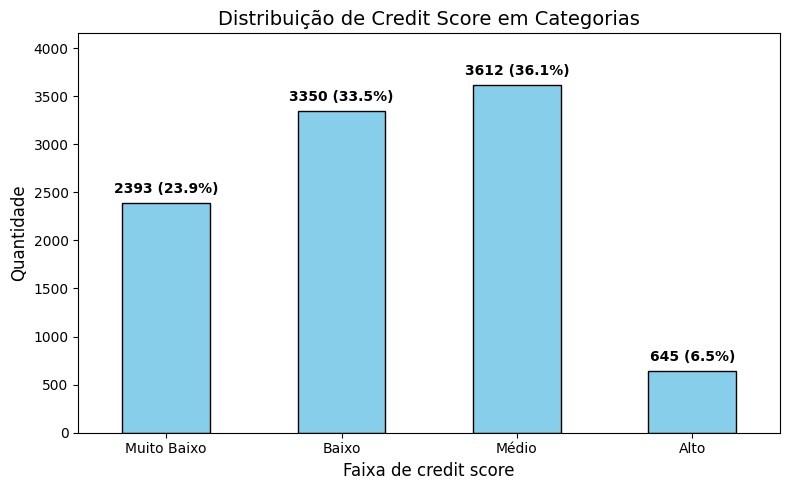

In [30]:
df_selecionado['CreditScore_Bin'] = pd.cut(
    df_selecionado['CreditScore'],
    bins=[0, 580, 670, 800, np.inf],
    labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto']
)


# contagem
count_por_categ = df_selecionado['CreditScore_Bin'].value_counts().sort_index()
total = count_por_categ.sum()

# plotando
plt.figure(figsize=(8, 5))
ax = count_por_categ.plot(kind='bar', color='skyblue', edgecolor='black')

# Ajusta o limite superior do eixo y para abrir espaço para os rótulos
y_max = count_por_categ.max()
plt.ylim(0, y_max * 1.15)  # 15% acima do maior valor

# adicionando rótulos de dados
for i, (valor, nome) in enumerate(zip(count_por_categ, count_por_categ.index)):
    percentual = (valor / total) * 100
    ax.text(i, valor + y_max * 0.02, f'{valor} ({percentual:.1f}%)', 
            ha='center', va='bottom', fontweight='bold',fontsize=10)

# config títulos e rótulos
plt.title('Distribuição de Credit Score em Categorias', fontsize=14)
plt.xlabel('Faixa de credit score', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


- Sem muitas interpretações aqui, mas é possível notar uma tendência dos clientes a ter baixo score de crédito, mais de 90% dos clientes tem score de medio para baixo. 

## 3.2 Faixas de Idade 
 - Essa variável serve para agrupar os dados de idade em bins, isso será testado se auxilia a encontrar mais facilmente algum padrão. 

In [31]:
# Faixas etárias 
df_selecionado['Age_Bin'] = pd.cut(
    df_selecionado['Age'],
    bins=[18, 30, 50, 80, np.inf],
    labels=['Jovem', 'Adulto', 'Idoso', 'Muito Idoso'],
    right=True, include_lowest=True
)


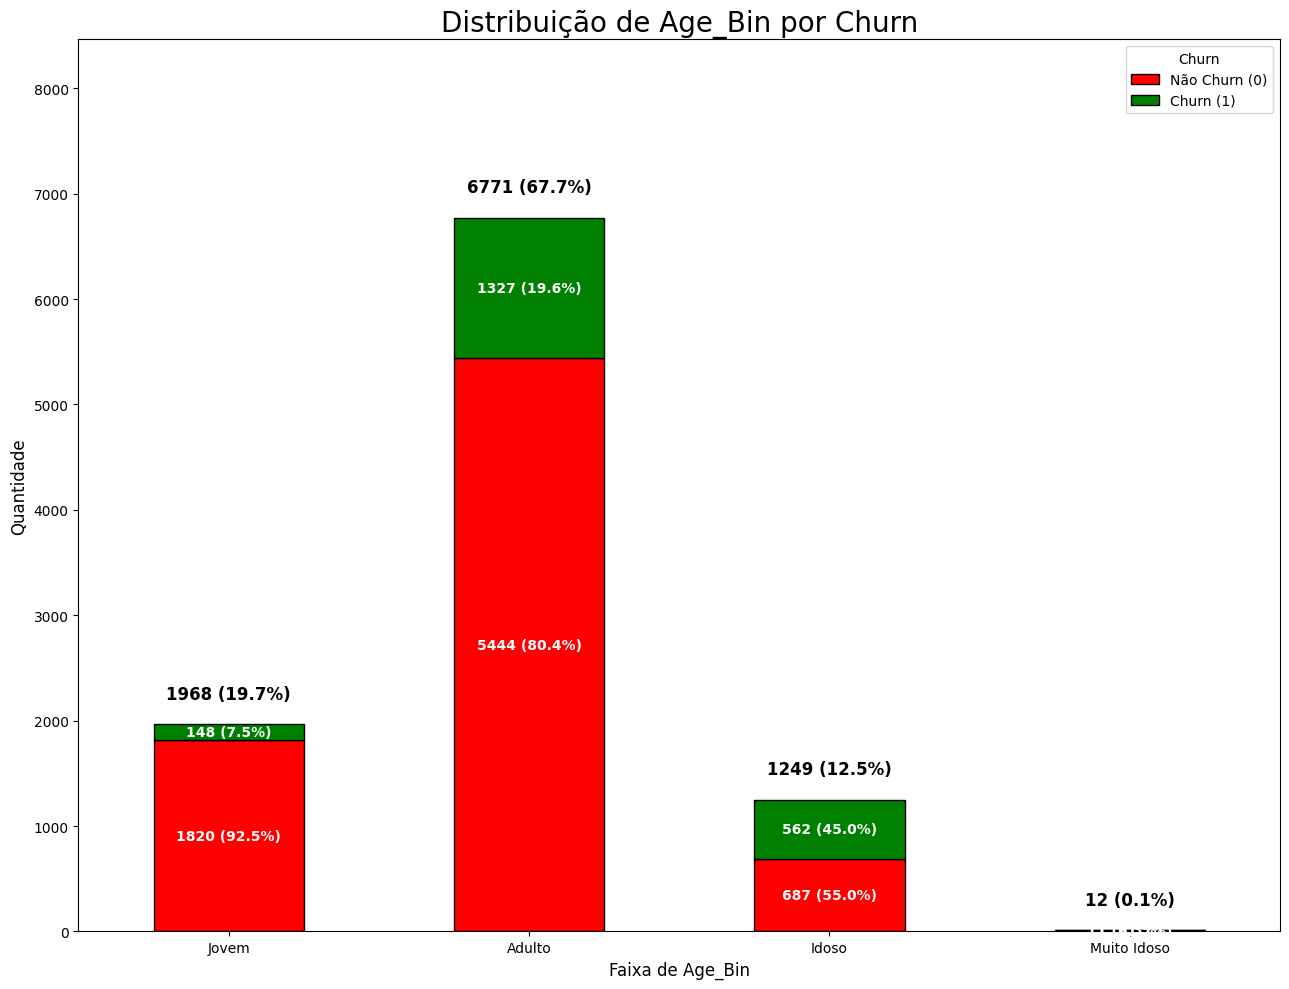

In [32]:
# contagem por faixa etária e churn
count_por_categ = df_selecionado.groupby(['Age_Bin', 'Exited']).size().unstack(fill_value=0).sort_index()
totais_por_bin = count_por_categ.sum(axis=1)
total_geral = totais_por_bin.sum()

# plotando gráfico de barras empilhadas
plt.figure(figsize=(13, 10))
ax = count_por_categ.plot(kind='bar', stacked=True, color=['red', 'green'], edgecolor='black', ax=plt.gca())

# Ajusta o limite superior do eixo y
y_max = totais_por_bin.max()
plt.ylim(0, y_max * 1.25)

# Rótulos internos com quantidade e % do total por faixa
for i, (idx, row) in enumerate(count_por_categ.iterrows()):
    y_base = 0
    total_faixa = row.sum()
    for j, valor in enumerate(row):
        if valor > 0:
            percentual = (valor / total_faixa) * 100
            ax.text(i, y_base + valor / 2,
                    f'{valor} ({percentual:.1f}%)',
                    ha='center', va='center', color='white',
                    fontweight='bold', fontsize=10)
        y_base += valor

# Rótulo total + percentual acima da barra
for i, (valor_total, nome) in enumerate(zip(totais_por_bin, totais_por_bin.index)):
    percentual = (valor_total / total_geral) * 100
    ax.text(i, valor_total + y_max * 0.03,
            f'{valor_total} ({percentual:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Configurações finais
plt.title('Distribuição de Age_Bin por Churn', fontsize=20)
plt.xlabel('Faixa de Age_Bin', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Não Churn (0)', 'Churn (1)'], title='Churn')
plt.tight_layout()
plt.show()


 - A maior parte dos clientes encontra-se nas categorias de adultos e jovens, que juntos representam a maioria da base.

 - Embora a maior quantidade absoluta de churn esteja entre os adultos, isso é parcialmente explicado pelo fato de que eles correspondem a cerca de 67% de todos os clientes — ou seja, são naturalmente mais representados em todos os comportamentos.

 - Um ponto de atenção está na categoria dos idosos: embora representem um grupo menor em termos absolutos, apresentam uma taxa de churn proporcionalmente mais alta. Enquanto aproximadamente **20% dos adultos dão churn, entre os idosos essa taxa sobe para cerca de 45%**, ou seja, uma diferença de 25 pontos percentuais. Isso indica que, **proporcionalmente à sua presença na base, os idosos estão mais propensos a churn**.

## 3.3 Credit Score ajustado pela idade categorizada
- Essa variável representa o score de crédito padronizado (**z-score**) dentro de faixas etárias específicas, criado para eliminar o viés da variável original (score dividido pela idade), que tendia a favorecer clientes mais jovens devido ao denominador menor.

    - A padronização indica se o score de um cliente está acima ou abaixo da média do seu grupo etário: **valores positivos indicam score acima da média, negativos indicam abaixo, e valores próximos de zero indicam score médio para a faixa.**

    - Assim, a variável se torna mais justa e informativa para comparar clientes de diferentes idades, corrigindo o viés inicial e mitigando distorções causadas pela relação matemática original.

In [33]:
# Padronização z-score do score de credito por faixa etária
df_selecionado['Score_pdroni_z_score_por_faixa'] = df_selecionado.groupby('Age_Bin')['CreditScore'].transform(
    lambda x: (x - x.mean()) / x.std()
)

#df_selecionado['Score_pdroni_z_score_por_faixa'].head(5)

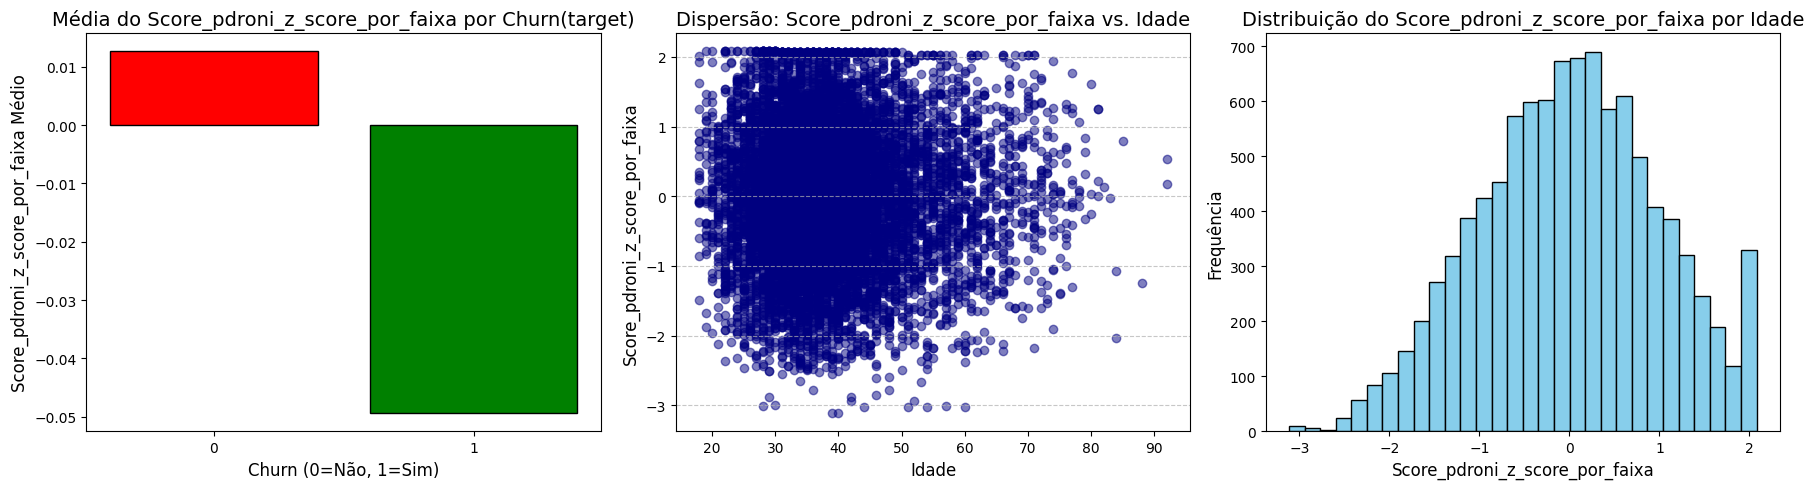

In [34]:
# cria fig para os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Média do Score_pdroni_z_score_por_faixa por Churn
media_score = df_selecionado.groupby('Exited')['Score_pdroni_z_score_por_faixa'].mean()
cores = ['red' if i == 0 else 'green' for i in media_score.index]
axes[0].bar(media_score.index.astype(str), media_score, color=cores, edgecolor='black')
axes[0].set_title('Média do Score_pdroni_z_score_por_faixa por Churn(target)', fontsize=14)
axes[0].set_ylabel('Score_pdroni_z_score_por_faixa Médio', fontsize=12)
axes[0].set_xlabel('Churn (0=Não, 1=Sim)', fontsize=12)


#Score_pdroni_z_score_por_faixa vs. Idade
axes[1].scatter(df_selecionado['Age'], df_selecionado['Score_pdroni_z_score_por_faixa'], color='navy', alpha=0.5)
axes[1].set_title('Dispersão: Score_pdroni_z_score_por_faixa vs. Idade', fontsize=14)
axes[1].set_xlabel('Idade', fontsize=12)
axes[1].set_ylabel('Score_pdroni_z_score_por_faixa', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


# Distribuição do Score_pdroni_z_score_por_faixa
axes[2].hist(df_selecionado['Score_pdroni_z_score_por_faixa'], bins=30, color='skyblue', edgecolor='black')
axes[2].set_title('Distribuição do Score_pdroni_z_score_por_faixa por Idade', fontsize=14)
axes[2].set_xlabel('Score_pdroni_z_score_por_faixa', fontsize=12)
axes[2].set_ylabel('Frequência', fontsize=12)

# Ajusta espaçamento e plota 
plt.tight_layout()
plt.show()


* **Média do Score_pdroni_z_score_por_faixa por Churn:** Observa-se que clientes que não churn (Exited = 0) apresentaram valores do score padronizado predominantemente acima de 0, enquanto clientes churn (Exited = 1) concentraram-se em valores negativos entre 0 e -0,05. Isso sugere que clientes com score ajustado abaixo da média do seu grupo etário têm maior propensão ao churn.

* **Dispersão do Score_pdroni_z_score_por_faixa vs Idade:** O gráfico mostra uma distribuição dispersa, sem padrão ou tendência clara associada à idade, indicando que o viés observado na variável original (como o uso direto de CreditScore/Idade) foi corrigido. A padronização por faixa etária eliminou a tendência estrutural injusta relacionada à idade, tornando o score mais justo (anteriormente, havia uma queda do score conforme os clientes eram mais velhos). 

* **Distribuição do Score_pdroni_z_score_por_faixa:** O histograma mostra uma curva aproximadamente normal, centrada em zero, o que confirma que a padronização (via z-score dentro de cada faixa etária) foi bem-sucedida. A variável agora possui distribuição simétrica, o que pode favorecer seu uso nos modelos preditivos sem introduzir distorções (por mais que não tenham normalidade como pré-requisito). 



## 3.4 Tenure ajustado pela idade

- Essa variável representa o tempo de casa padronizado (**z-score**) dentro de faixas etárias específicas, criada para eliminar o viés da variável original (Tenure dividido pela idade), que favorecia clientes mais jovens, já que o denominador (idade) era menor.

    - A padronização mostra se o tempo de casa de um cliente está acima ou abaixo da média do seu grupo etário:
    **valores positivos indicam tempo de casa acima da média, negativos indicam abaixo da média, e valores próximos de zero indicam um tempo de casa típico para a idade.**

    - Com isso, a variável se torna mais justa e comparável entre clientes de diferentes idades, corrigindo distorções e revelando o quanto o cliente está fidelizado em relação a outros da mesma faixa etária.

In [35]:
#df_selecionado['Tenure_Age_Ratio_zscore'] = df_selecionado['Tenure'] / df_selecionado['Age']

# Padronização z-score do score de credito por faixa etária
df_selecionado['Tenure_Age_Ratio_zscore'] = df_selecionado.groupby('Age_Bin')['Tenure'].transform(
    lambda x: (x - x.mean()) / x.std()
)


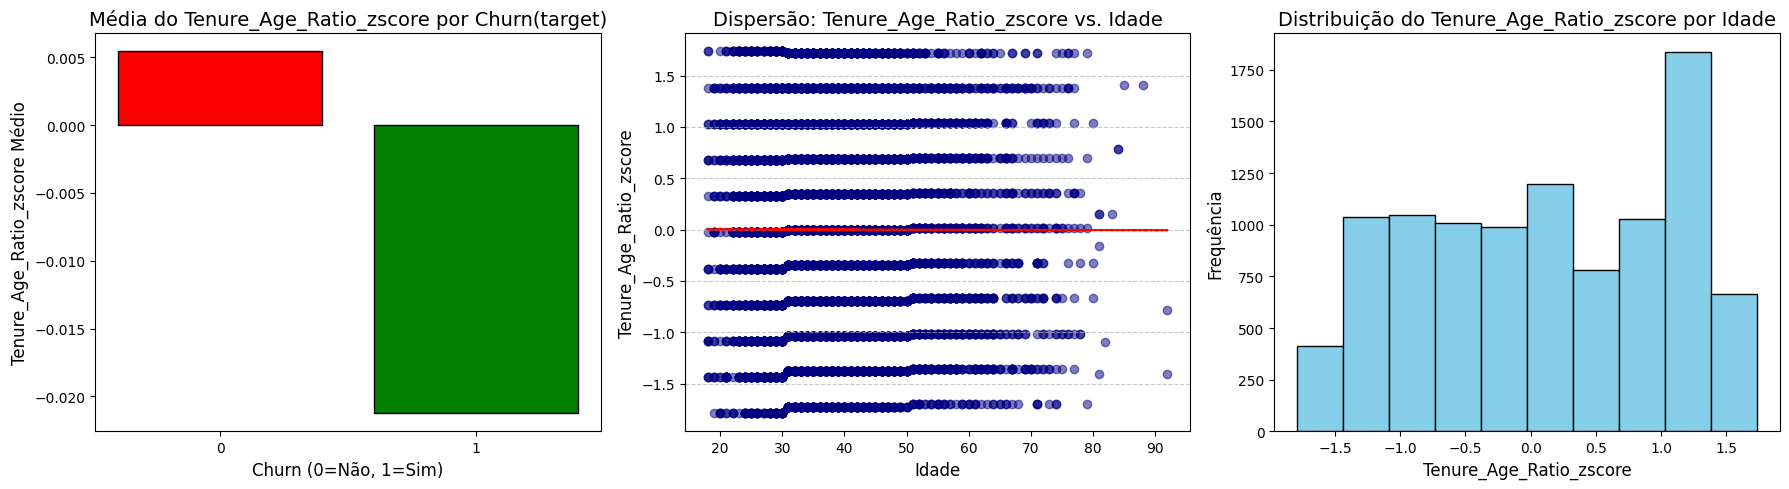

In [36]:
# cria fig para os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Média do Tenure_Age_Ratio_zscore por Churn
media_score = df_selecionado.groupby('Exited')['Tenure_Age_Ratio_zscore'].mean()
cores = ['red' if i == 0 else 'green' for i in media_score.index]
axes[0].bar(media_score.index.astype(str), media_score, color=cores, edgecolor='black')
axes[0].set_title('Média do Tenure_Age_Ratio_zscore por Churn(target)', fontsize=14)
axes[0].set_ylabel('Tenure_Age_Ratio_zscore Médio', fontsize=12)
axes[0].set_xlabel('Churn (0=Não, 1=Sim)', fontsize=12)


#Tenure_Age_Ratio_zscore vs. Idade
axes[1].scatter(df_selecionado['Age'], df_selecionado['Tenure_Age_Ratio_zscore'], color='navy', alpha=0.5)
axes[1].set_title('Dispersão: Tenure_Age_Ratio_zscore vs. Idade', fontsize=14)
axes[1].set_xlabel('Idade', fontsize=12)
axes[1].set_ylabel('Tenure_Age_Ratio_zscore', fontsize=12)
z = np.polyfit(df_selecionado['Age'], df_selecionado['Tenure_Age_Ratio_zscore'], 1)
p = np.poly1d(z)
axes[1].plot(df_selecionado['Age'], p(df_selecionado['Age']), color='red', linestyle='--') #plota linha pra ter certeza se hã, memso que leve, uma tendencia 

axes[1].grid(axis='y', linestyle='--', alpha=0.7)


# Distribuição do Tenure_Age_Ratio_zscore
axes[2].hist(df_selecionado['Tenure_Age_Ratio_zscore'], bins=10, color='skyblue', edgecolor='black')
axes[2].set_title('Distribuição do Tenure_Age_Ratio_zscore por Idade', fontsize=14)
axes[2].set_xlabel('Tenure_Age_Ratio_zscore', fontsize=12)
axes[2].set_ylabel('Frequência', fontsize=12)

# Ajusta espaçamento e plota 
plt.tight_layout()
plt.show()


- **Média do Tenure_Age_Ratio por Churn:**
Observa-se que clientes que não churn (Exited = 0) apresentaram valores médios acima de zero, enquanto clientes churn (Exited = 1) concentraram-se em valores negativos. Isso sugere que clientes cujo tempo de casa está abaixo da média da sua faixa etária têm maior propensão ao churn. Já os que permanecem tendem a ter maior tempo de relacionamento com a empresa em relação ao seu grupo de idade.

- **Dispersão do Tenure_Age_Ratio vs Idade:**
O gráfico mostra pontos organizados em linhas horizontais discretas, o que é esperado, dado que Tenure assume apenas valores inteiros de 0 a 10. Essa padronização dentro de cada faixa etária evita o viés da variável original (Tenure / Age), que favorecia clientes jovens. A ausência de tendência ou inclinação associada à idade indica que a padronização corrigiu com sucesso o viés estrutural etário, tornando a variável mais equitativa entre diferentes grupos de idade.

- **Distribuição do Tenure_Age_Ratio:**
O histograma apresenta uma distribuição escalonada e aproximadamente simétrica em torno de zero, resultado esperado dada a natureza discreta do Tenure (valores inteiros de 0 a 10) combinada à padronização por faixas etárias. Embora não siga uma curva normal perfeita, a variável apresenta um padrão condizente com a distribuição de um z-score, com boa dispersão e sem caudas acentuadas.

    obs: Um pico visível em torno do valor 1.0 pode causar certo desconforto visual, mas é coerente com o comportamento observado também na variável original, especialmente entre clientes não churn. Portanto, esse padrão não é um erro da transformação e não representa uma distorção preocupante para uso nos modelos.

## 3.5 Flag de Saldo

- Clientes sem saldo podem estar desengajados ou apenas mantendo a conta ativa por conveniência, podendo ser mais suscetíveis ao churn.
- A variável de saldo (Balance) tem forte inflação de zeros (25%). A variável de flag busca auxiliar o modelo a identificar melhor esses clientes e nao sofrer confusao por causa dessa inflacao de zeros. 

In [37]:
# Flag se tem saldo positivo
df_selecionado['Balance_flag'] = (df_selecionado['Balance'] > 0).astype(int)

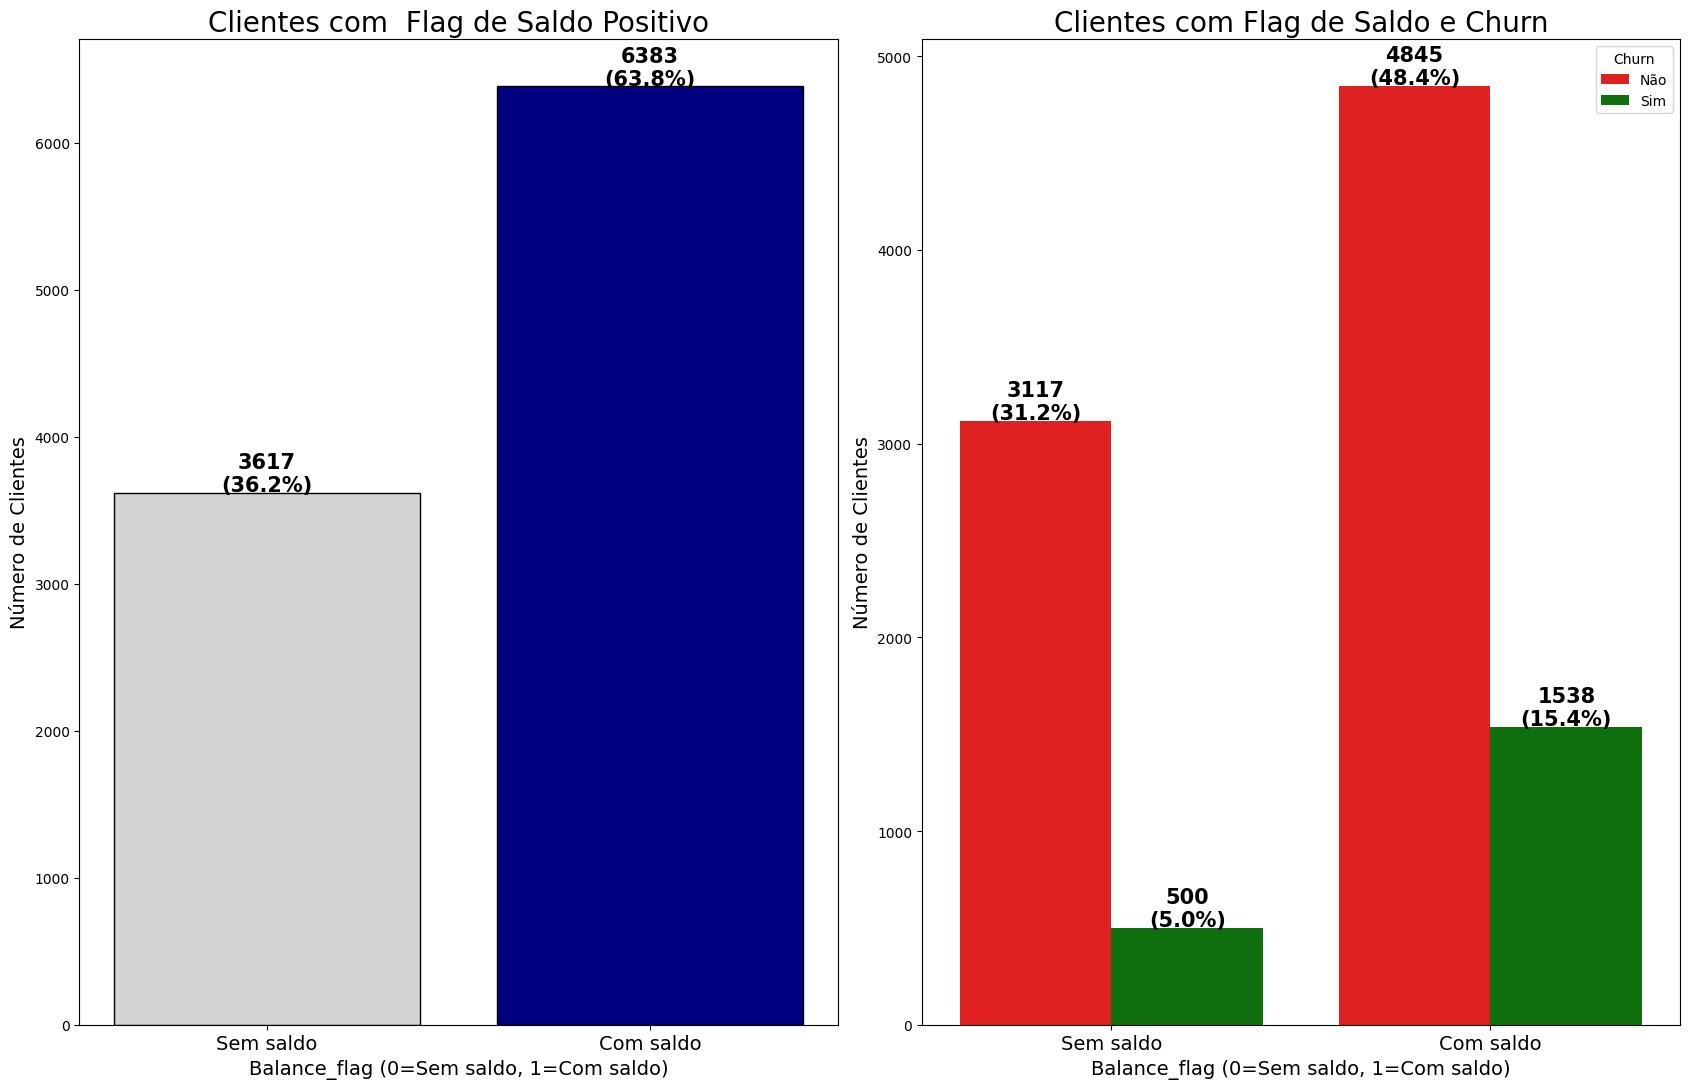

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(17, 11))

total_clientes = len(df_selecionado)

# 1. Contagem total por Balance_flag (sem taxa de churn)
contagem_flag = df_selecionado['Balance_flag'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Clientes com  Flag de Saldo Positivo', fontsize=20)
axes[0].set_xlabel('Balance_flag (0=Sem saldo, 1=Com saldo)', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Sem saldo', 'Com saldo'], fontsize=14)

# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

# 2. Contagem de clientes por Balance_flag e Churn
sns.countplot(
    x='Balance_flag',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Clientes com Flag de Saldo e Churn', fontsize=20)
axes[1].set_xlabel('Balance_flag (0=Sem saldo, 1=Com saldo)', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Sem saldo', 'Com saldo'], fontsize=14)
axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

plt.tight_layout()
plt.show()


- Podemos observar que uma parcela considerável dos **clientes não possui saldo na conta, cerca de 36% do total de clientes**. Aproximadamente **5% dos clientes da base total se enquadram nesse perfil (sem saldo) e realizaram churn**. No entanto, ao olharmos apenas para os **clientes que deram churn, esses mesmos clientes sem saldo representam cerca de 24% de todos os casos de churn** (500 de 2.038 -> soma das duas barras verdes).

Isso é relevante, pois indica que quase um quarto dos churns ocorreram entre clientes sem saldo, sugerindo que a ausência de saldo pode estar associada a um menor engajamento — o que pode torná-los mais propensos à evasão.

A variável será incluída nos testes de importancia e influencia dos modelos como as demais, embora o fato de que **a maioria dos churns tenha ocorrido entre clientes com saldo** mostre que a relação não é determinística — mas sim **potencialmente explicativa em conjunto com outras variáveis.**


## 3.6 Faixas Salário Estimado
 - Essa variável serve para agrupar os dados de Salario estimado em bins, isso será testado se auxilia a encontrar mais facilmente algum padrão. 

In [39]:
# 1. Categorizar EstimatedSalary em faixas
bins = [0, 50000, 100000, 150000, 200000]
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
df_selecionado['Salary_Level'] = pd.cut(df_selecionado['EstimatedSalary'], bins=bins, labels=labels,right=True, include_lowest=True)


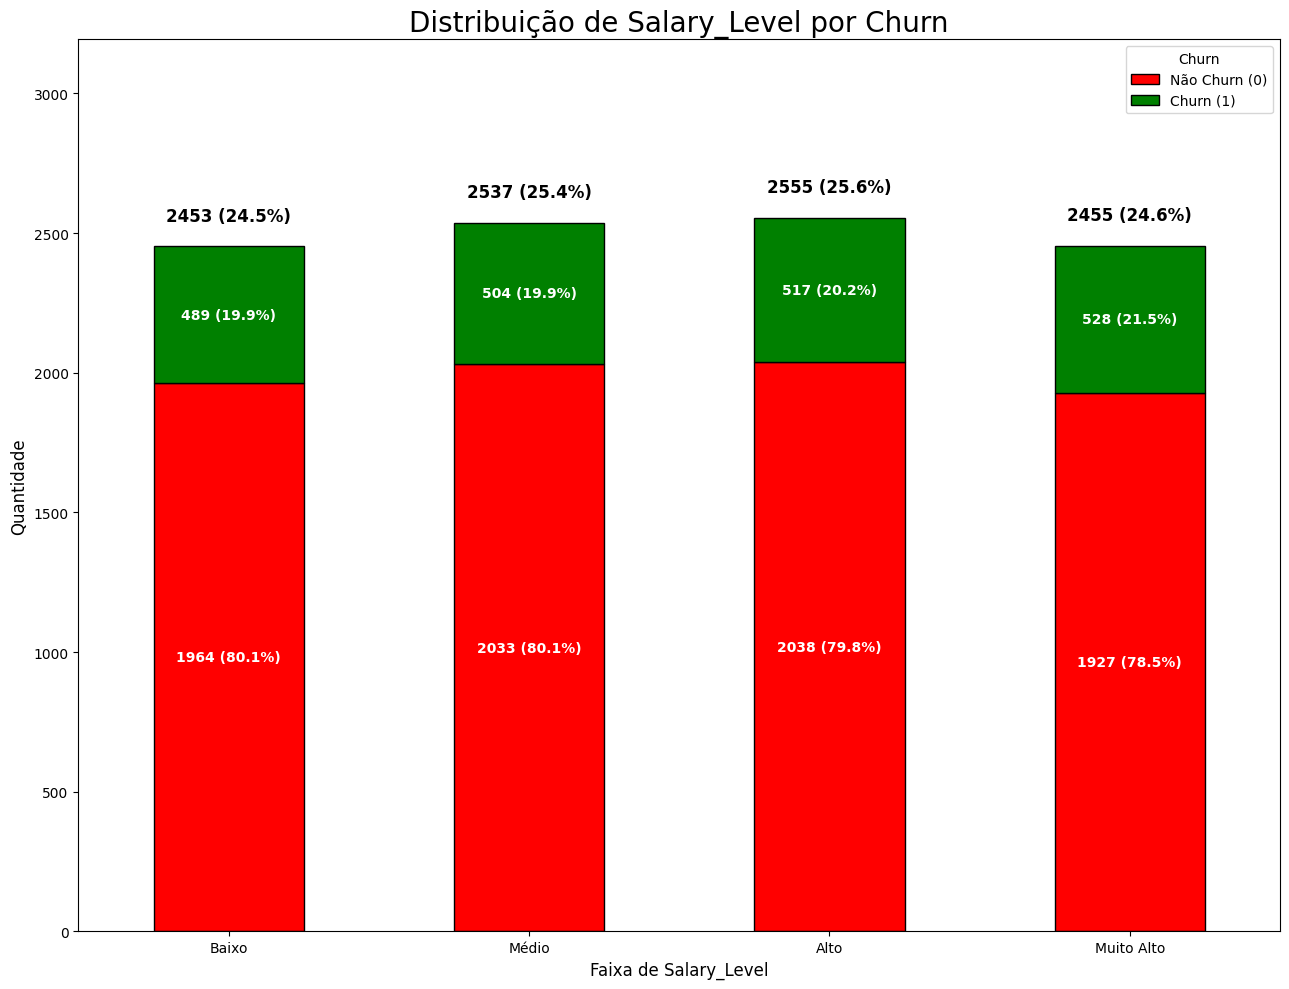

In [40]:
# contagem por faixa de salario estimado e churn
count_por_categ = df_selecionado.groupby(['Salary_Level', 'Exited']).size().unstack(fill_value=0).sort_index()
totais_por_bin = count_por_categ.sum(axis=1)
total_geral = totais_por_bin.sum()

# plotando gráfico de barras empilhadas
plt.figure(figsize=(13, 10))
ax = count_por_categ.plot(kind='bar', stacked=True, color=['red', 'green'], edgecolor='black', ax=plt.gca())

# Ajusta o limite superior do eixo y
y_max = totais_por_bin.max()
plt.ylim(0, y_max * 1.25)

# Rótulos internos com quantidade e % do total por faixa
for i, (idx, row) in enumerate(count_por_categ.iterrows()):
    y_base = 0
    total_faixa = row.sum()
    for j, valor in enumerate(row):
        if valor > 0:
            percentual = (valor / total_faixa) * 100
            ax.text(i, y_base + valor / 2,
                    f'{valor} ({percentual:.1f}%)',
                    ha='center', va='center', color='white',
                    fontweight='bold', fontsize=10)
        y_base += valor

# Rótulo total + percentual acima da barra
for i, (valor_total, nome) in enumerate(zip(totais_por_bin, totais_por_bin.index)):
    percentual = (valor_total / total_geral) * 100
    ax.text(i, valor_total + y_max * 0.03,
            f'{valor_total} ({percentual:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Configurações finais
plt.title('Distribuição de Salary_Level por Churn', fontsize=20)
plt.xlabel('Faixa de Salary_Level', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Não Churn (0)', 'Churn (1)'], title='Churn')
plt.tight_layout()
plt.show()


* Aproximadamente 20% de cada categoria é churn, o que sozinho nao diz muito sobre o evento. 

## 3.7 Saldo ajustado pelo Salário Estimado categorizado

- A variável Balance_z_score_por_SalaryLevel padroniza o saldo do cliente em relação à sua faixa de salário estimado. Assim, ela mostra se o saldo está acima ou abaixo do esperado para o seu nível de renda.

- Com isso, é possível identificar comportamentos financeiros atípicos, como clientes de alta renda com saldo baixo (z-score negativo) ou saldo elevado (z-score positivo), proporcionando uma análise mais contextualizada do perfil financeiro. Essa variavel pode tornar os modelos preditivos mais precisos ao considerar a relação entre saldo e capacidade financeira do cliente, isso será avaliado no momento das modelagens e teste de importancia das features


In [41]:
# 2. Padronizar (z-score) o Balance dentro de cada faixa salarial estimada
df_selecionado['Balance_z_score_por_SalaryLevel'] = df_selecionado.groupby('Salary_Level')['Balance'].transform(
    lambda x: (x - x.mean()) / x.std()
)

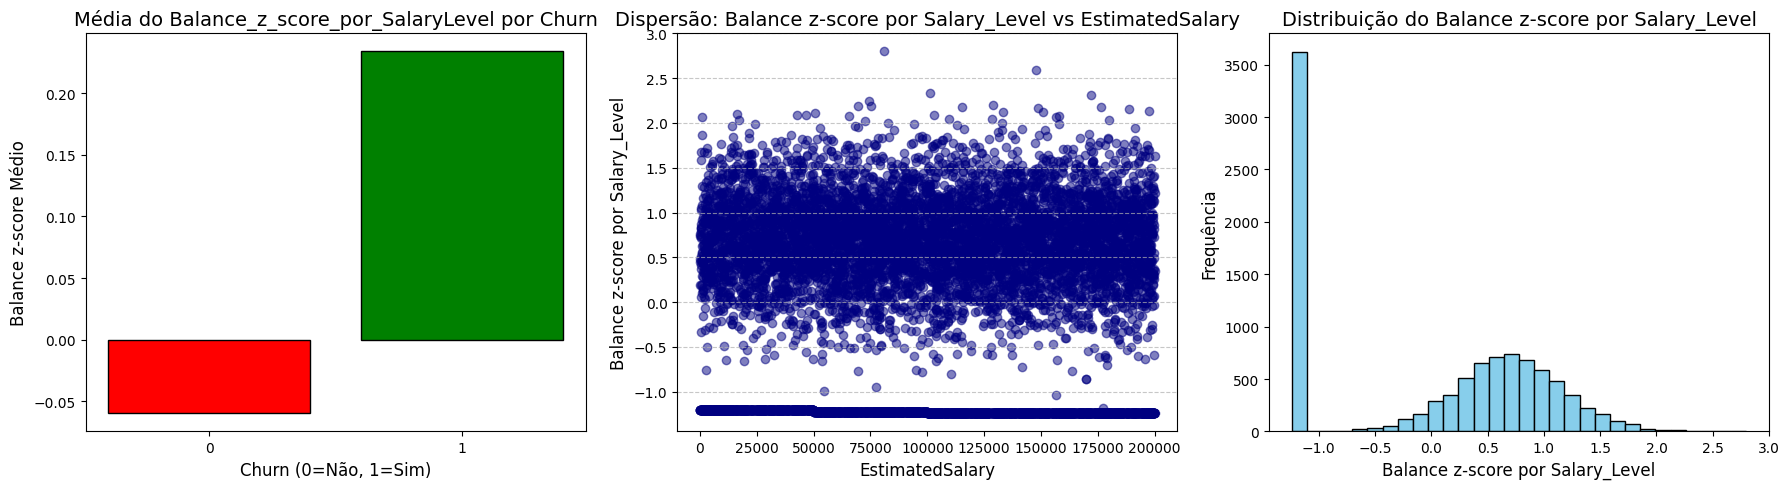

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Média do Balance_z_score_por_SalaryLevel por Churn
media_balance = df_selecionado.groupby('Exited')['Balance_z_score_por_SalaryLevel'].mean()
cores = ['red' if i == 0 else 'green' for i in media_balance.index]
axes[0].bar(media_balance.index.astype(str), media_balance, color=cores, edgecolor='black')
axes[0].set_title('Média do Balance_z_score_por_SalaryLevel por Churn', fontsize=14)
axes[0].set_ylabel('Balance z-score Médio', fontsize=12)
axes[0].set_xlabel('Churn (0=Não, 1=Sim)', fontsize=12)

# Dispersão: Balance_z_score_por_SalaryLevel vs EstimatedSalary
axes[1].scatter(df_selecionado['EstimatedSalary'], df_selecionado['Balance_z_score_por_SalaryLevel'], color='navy', alpha=0.5)
axes[1].set_title('Dispersão: Balance z-score por Salary_Level vs EstimatedSalary', fontsize=14)
axes[1].set_xlabel('EstimatedSalary', fontsize=12)
axes[1].set_ylabel('Balance z-score por Salary_Level', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Distribuição do Balance_z_score_por_SalaryLevel
axes[2].hist(df_selecionado['Balance_z_score_por_SalaryLevel'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[2].set_title('Distribuição do Balance z-score por Salary_Level', fontsize=14)
axes[2].set_xlabel('Balance z-score por Salary_Level', fontsize=12)
axes[2].set_ylabel('Frequência', fontsize=12)

plt.tight_layout()
plt.show()


- **Média do Balance_z_score_por_SalaryLevel por Churn**: 
    - Clientes churn (1) apresentam, em média, um z-score de saldo acima da média da sua faixa salarial. 
     - Já os não churn (0) têm, em média, saldos iguais ou abaixo da média esperada para seu nível de renda. 
     - Isso sugere que **clientes com maior capacidade de manter saldo (relativamente à sua renda) podem estar mais propensos a churn**, possivelmente por terem maior poder de escolha ou insatisfação com os serviços/produtos/banco.

- **Balance_z_score_por_SalaryLevel vs EstimatedSalary**: 
Dentro de cada faixa de salário, há uma grande variação no saldo padronizado. Embora o salário estimado varie amplamente, não há uma relação linear direta com o saldo padronizado, o que indica que clientes com salários semelhantes podem ter comportamentos financeiros muito distintos em relação ao saldo mantido. Isso valida o uso do z-score padronizado como forma de capturar essas diferenças individuais.


- **Distribuição do Balance_z_score_por_SalaryLevel**: 
A distribuição mostra uma grande concentração de clientes com z-score igual a -1, indicando muitos clientes com saldo zerado, como ja comprovamos, independentemente da faixa salarial. Fora esse grupo, a maioria dos clientes apresenta z-scores entre 0 e 2, revelando uma assimetria positiva na distribuição.

## 3.8 Multisserviço Ativo

- A **High_Product_Active** é uma variável binária que indica se o cliente:

    - Possui dois ou mais produtos com o banco (NumOfProducts >= 2)

    - Está ativo (IsActiveMember == 1)

Ou seja, ela representa clientes que não apenas possuem múltiplos produtos, mas também usam ativamente os serviços — o que pode a indicar alto engajamento. 

In [43]:
# 8. Cliente ativo com múltiplos produtos
df_selecionado['High_Product_Active'] = (
    (df_selecionado['NumOfProducts'] >= 2) & 
    (df_selecionado['IsActiveMember'] == 1)
).astype(int)

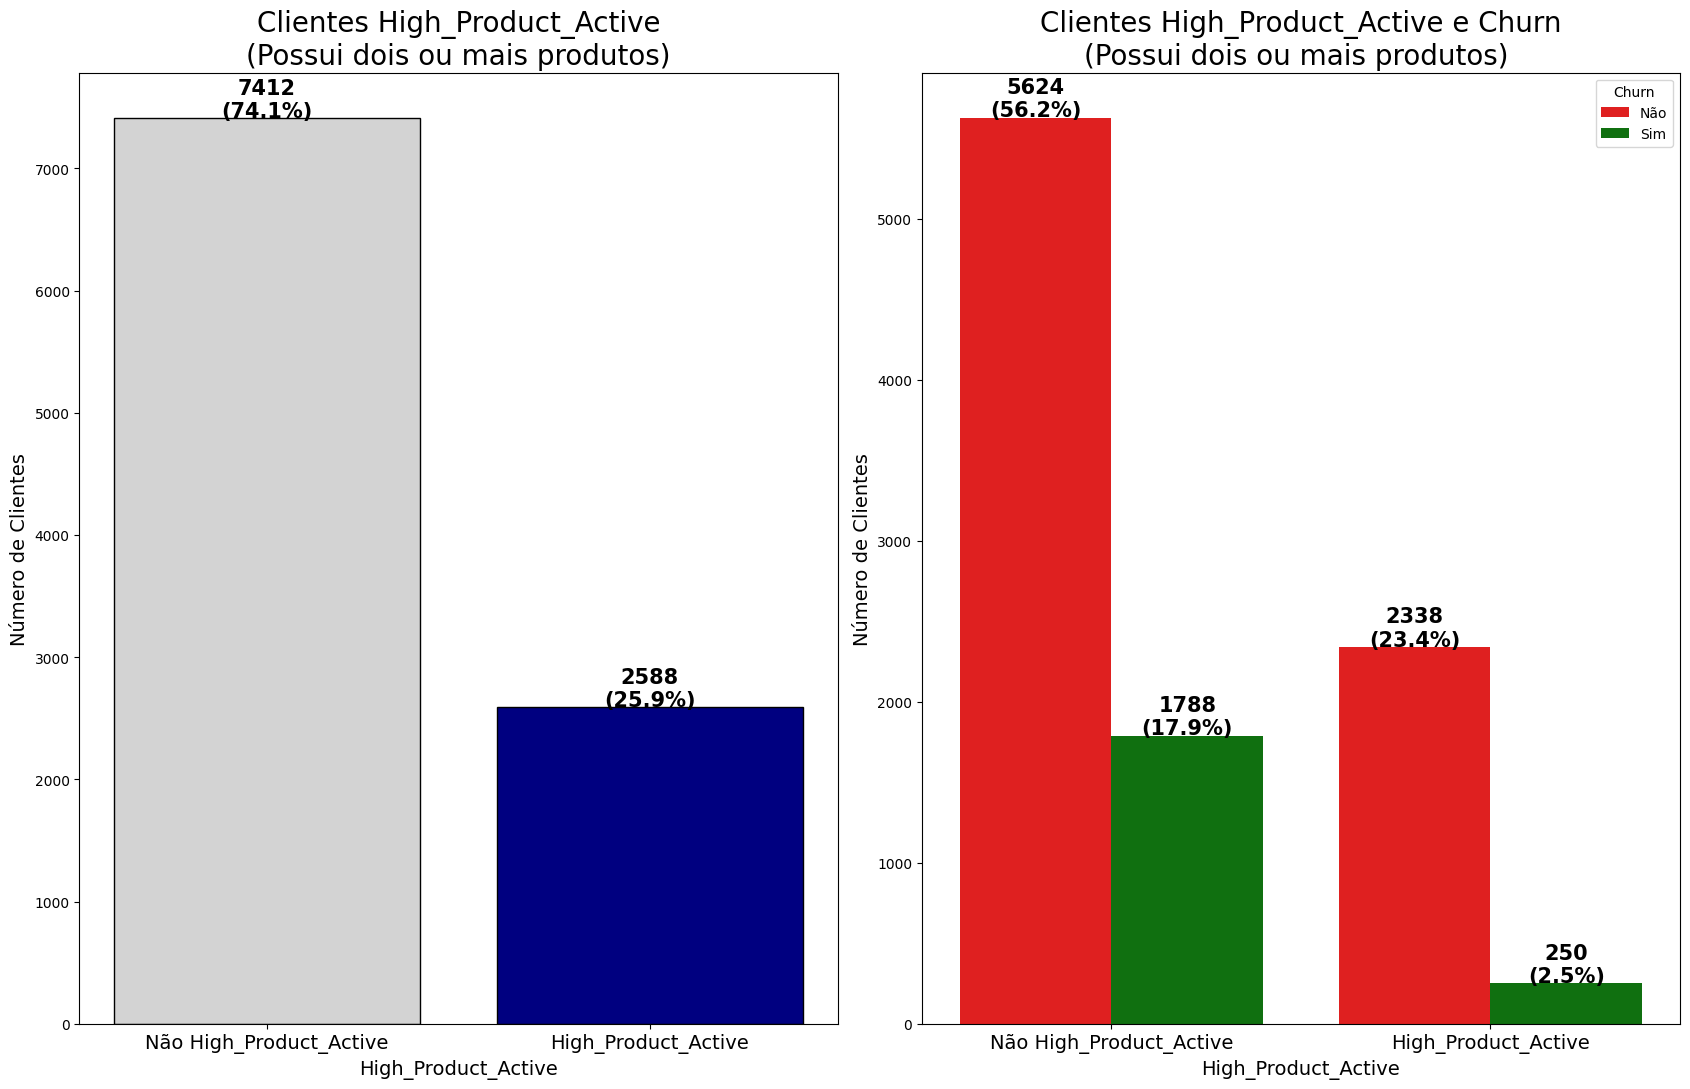

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(17, 11))

total_clientes = len(df_selecionado)

# 1. Contagem total por High_Product_Active (sem filtrar por churn)
contagem_flag = df_selecionado['High_Product_Active'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Clientes High_Product_Active\n(Possui dois ou mais produtos)', fontsize=20)
axes[0].set_xlabel('High_Product_Active', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Não High_Product_Active', 'High_Product_Active'], fontsize=14)

# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

# 2. Contagem de clientes por High_Product_Active e Churn
sns.countplot(
    x='High_Product_Active',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Clientes High_Product_Active e Churn\n(Possui dois ou mais produtos) ', fontsize=20)
axes[1].set_xlabel('High_Product_Active', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Não High_Product_Active', 'High_Product_Active'], fontsize=14)
axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

plt.tight_layout()
plt.show()


- Cerca de 25% dos clientes possuem múltiplos produtos ativos, e entre eles, apenas 2,5% realizam churn. Em contraste, entre os clientes que não possuem múltiplos produtos, o churn atinge aproximadamente 18%.

- A diferença é significativa: o número absoluto de clientes que dão churn e não têm múltiplos produtos é quase do mesmo tamanho da base total de clientes multprodutos. Isso indica **uma possível relação entre a diversificação de produtos e a retenção de clientes, sugerindo que aqueles com mais produtos tendem a estar mais engajados e, consequentemente, são menos propensos ao churn**.

## 3.9 Reclamação não Resolvida 

- **Complain_NoSolution:** indica clientes que reclamaram (Complain = 1) e apresentaram uma pontuação de satisfação menor que 5, ou seja, clientes que não estão totalmente satisfeitos e possivelmente não tiveram a solução adequada para sua reclamação.

- Para entender a escala, seria mais ou menos assim se fosse categorizada nominalmente:
    - 5 = Totalmente satisfeito
    - 4 = Satisfeito
    - 3 = Neutro
    - 2 = Insatisfeito
    - 1 = Totalmente insatisfeito

In [45]:
df_selecionado['Complain_NoSolution'] = (
    (df_selecionado['Complain'] == 1) & 
    (df_selecionado['Satisfaction Score'] < 5) # pega as notas 4 e 5, seriam como clientes satisfeitos e clientes totalmente satisfeitos 
).astype(int)


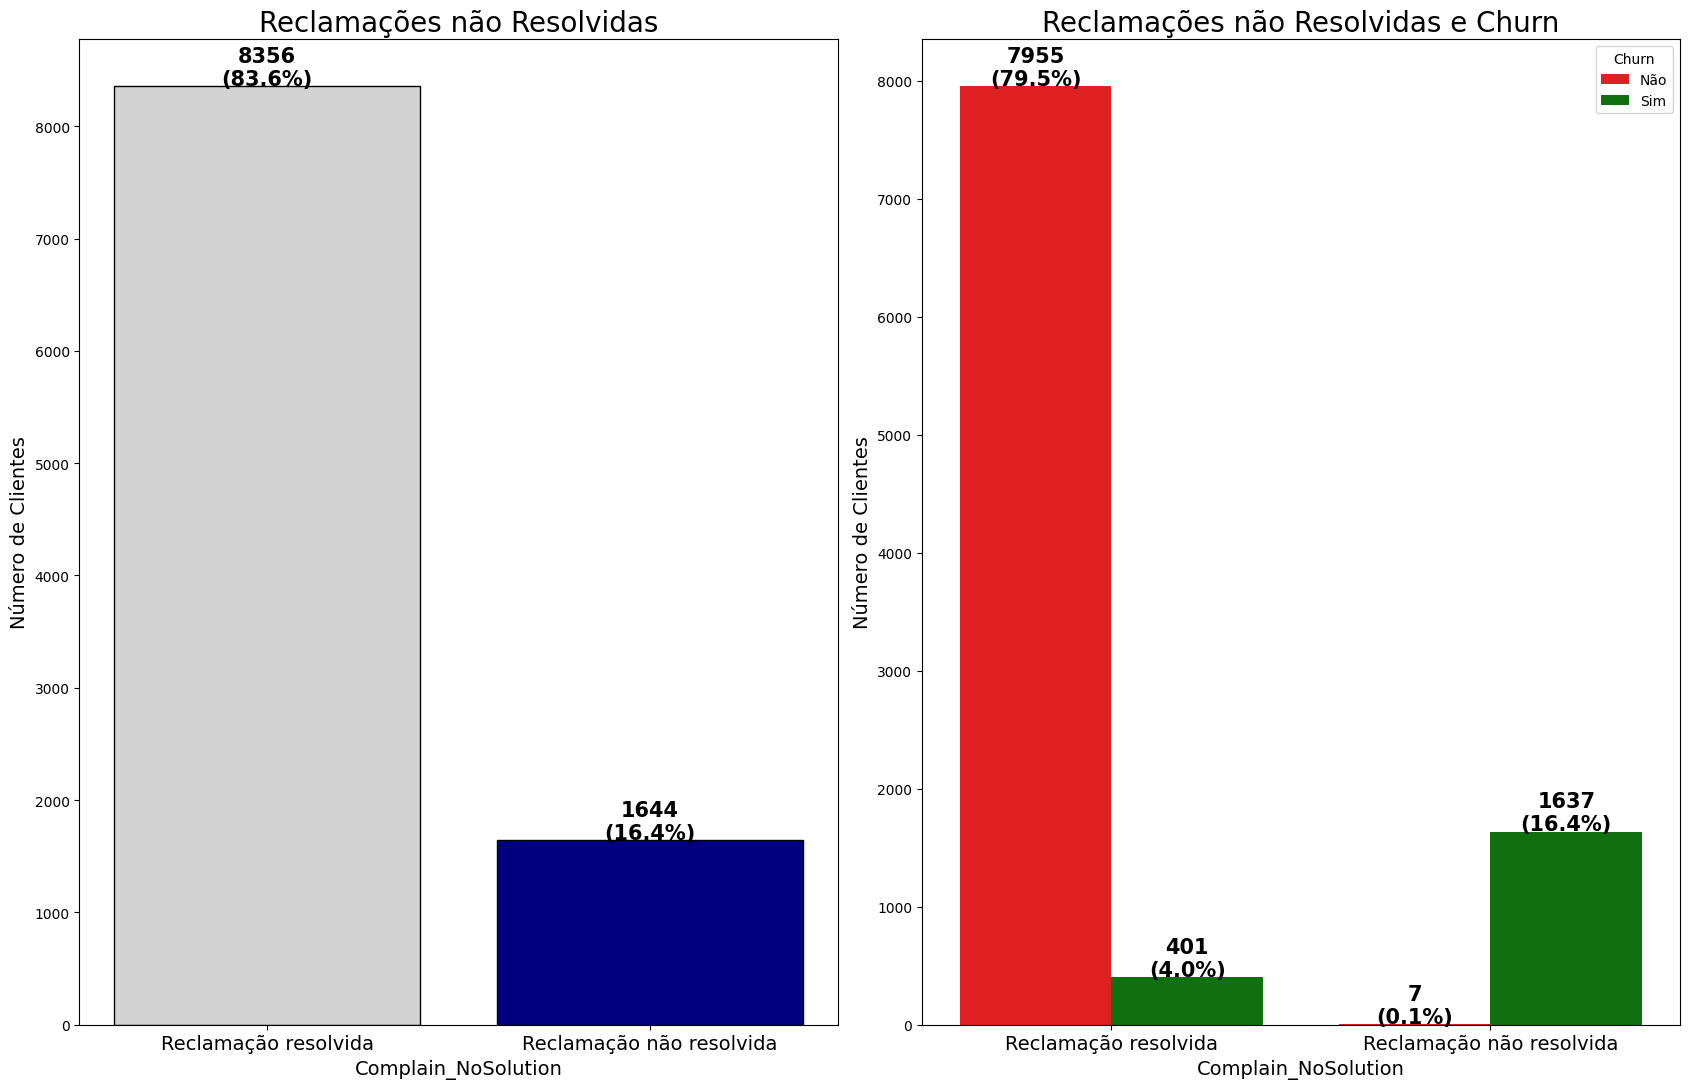

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(17, 11))

total_clientes = len(df_selecionado)

# 1. Contagem total por Complain_NoSolution (sem filtro de churn)
contagem_flag = df_selecionado['Complain_NoSolution'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Reclamações não Resolvidas', fontsize=20)
axes[0].set_xlabel('Complain_NoSolution', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)

xticklabels = ['Reclamação resolvida' if i == 0 else 'Reclamação não resolvida' for i in contagem_flag.index]
axes[0].set_xticks(contagem_flag.index)
axes[0].set_xticklabels(xticklabels, fontsize=14)

# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

# 2. Contagem de clientes por Complain_NoSolution e Churn
sns.countplot(
    x='Complain_NoSolution',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Reclamações não Resolvidas e Churn', fontsize=20)
axes[1].set_xlabel('Complain_NoSolution', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)

xticks_labels = ['Reclamação resolvida' if val == 0 else 'Reclamação não resolvida' 
                 for val in sorted(df_selecionado['Complain_NoSolution'].unique())]
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(xticks_labels, fontsize=14)

axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

plt.tight_layout()
plt.show()


 - Cerca de **16,4% dos clientes tiveram reclamações não resolvidas**, enquanto a grande maioria **(83,6%) teve suas reclamações solucionadas**.
Esse dado mostra que, embora o volume de reclamações não resolvidas seja menor, ele representa um grupo importante de clientes que podem estar insatisfeitos com o serviço.

 - A diferença no churn entre esses dois grupos é extremamente acentuada: **entre os clientes com reclamações não resolvidas, aproximadamente 99,6% realizaram churn (1.637 de 1.644)**. Em contraste, entre os clientes com reclamações resolvidas, apenas 4,8% saíram (401 de 8.356).
Isso **indica uma forte relação entre a resolução de reclamações e a permanência dos clientes**, sugerindo que falhas no atendimento de reclamações estão diretamente associadas à evasão, e que resolver reclamações pode ser uma alavanca crucial de retenção.

## 3.10 Recompensa por produto

- **Points_per_Product_zscored:** representa a razãoentre os **pontos acumulados (Point Earned com zscore)** e o **número de produtos(NumOfProducts)** bancários contratados. Pode indicar o nível de engajamento ou o retorno obtido pelo cliente a partir do uso dos produtos. Valores baixos podem sugerir baixa utilização ou engajamento com os serviços contratados.

In [47]:
df_selecionado['Points_per_Product_zscored'] = df_selecionado.groupby('NumOfProducts')['Point Earned'].transform(
    lambda x: (x - x.mean()) / x.std()
)

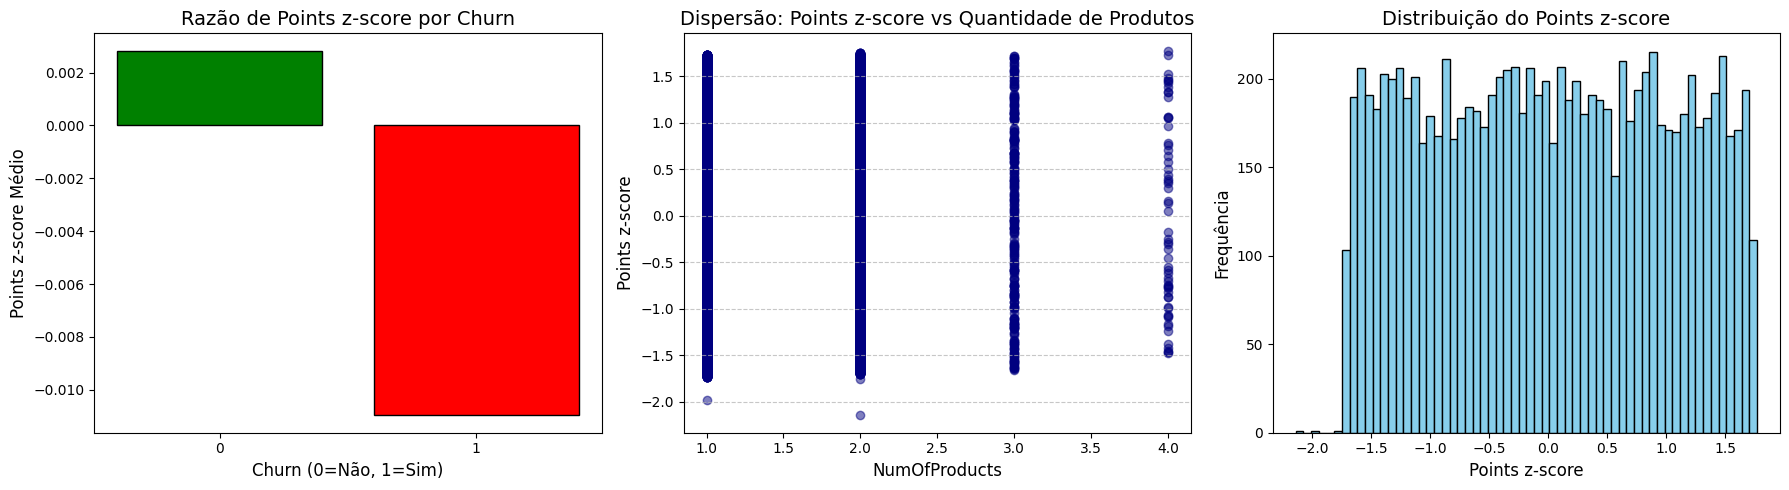

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Média do z-score por status de churn
media_zscore = df_selecionado.groupby('Exited')['Points_per_Product_zscored'].mean()
cores = ['green' if i == 0 else 'red' for i in media_zscore.index]
axes[0].bar(media_zscore.index.astype(str), media_zscore, color=cores, edgecolor='black')
axes[0].set_title('Razão de Points z-score por Churn', fontsize=14)
axes[0].set_ylabel('Points z-score Médio', fontsize=12)
axes[0].set_xlabel('Churn (0=Não, 1=Sim)', fontsize=12)

# 2. Dispersão: Points z-score vs Salário estimado
axes[1].scatter(df_selecionado['NumOfProducts'], df_selecionado['Points_per_Product_zscored'], color='navy', alpha=0.5)
axes[1].set_title('Dispersão: Points z-score vs Quantidade de Produtos', fontsize=14)
axes[1].set_xlabel('NumOfProducts', fontsize=12)
axes[1].set_ylabel('Points z-score', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. Distribuição do z-score
axes[2].hist(df_selecionado['Points_per_Product_zscored'].dropna(), bins=60, color='skyblue', edgecolor='black')
axes[2].set_title('Distribuição do Points z-score', fontsize=14)
axes[2].set_xlabel('Points z-score', fontsize=12)
axes[2].set_ylabel('Frequência', fontsize=12)

plt.tight_layout()
plt.show()


- **Média do z-score por Churn:**
Clientes não churn (0) têm um z-score médio levemente positivo. Clientes churn (1) têm um z-score médio levemente negativo. **Clientes que permanecem tendem a acumular mais pontos que a média do seu grupo de produtos, enquanto os que saem tendem a ter menos pontos que seus pares**. A diferença é pequena, mas consistente, sugerindo que engajamento proporcional ao uso pode influenciar a retenção.


 - **Dispersão: z-score vs Quantidade de Produtos:**
Para cada quantidade de produtos (1 a 4), os z-scores estão distribuídos de forma relativamente simétrica e padronizada. A variabilidade interna é alta, mostrando que clientes com o mesmo número de produtos podem ter perfis muito diferentes. Clientes com **4 produtos apresentam maior concentração, indicando maior homogeneidade ou limite de pontuação**.


- **Distribuição dos z-scores:** 
Distribuição aproximada a da variavel de Point Earned original, com valores entre -2.0 e +1.8 e poucos outliers, evidenciando uma padronização bem calibrada que não distorceu a variável. Essa distribuição reforça a eficácia da transformação, centralizando a comparação dentro de cada grupo e removendo viés por volumetria.

## 3.11 Analisando variáveis e importância 
 - Antes de entregarmos para os modelos as variáveis, é importante analisar as relações e importâncias entre as variaveis originais e as produzidas por feature engineering. 

### 3.11.1 Matriz de correlação 

**Esta matriz de correlação** utiliza um método que identifica automaticamente o tipo de cada variável e aplica a métrica de associação mais apropriada: correlação de Pearson para pares numéricos, Cramér’s V para variáveis categóricas, e Correlation Ratio (η²) para relações entre variáveis categóricas e numéricas.

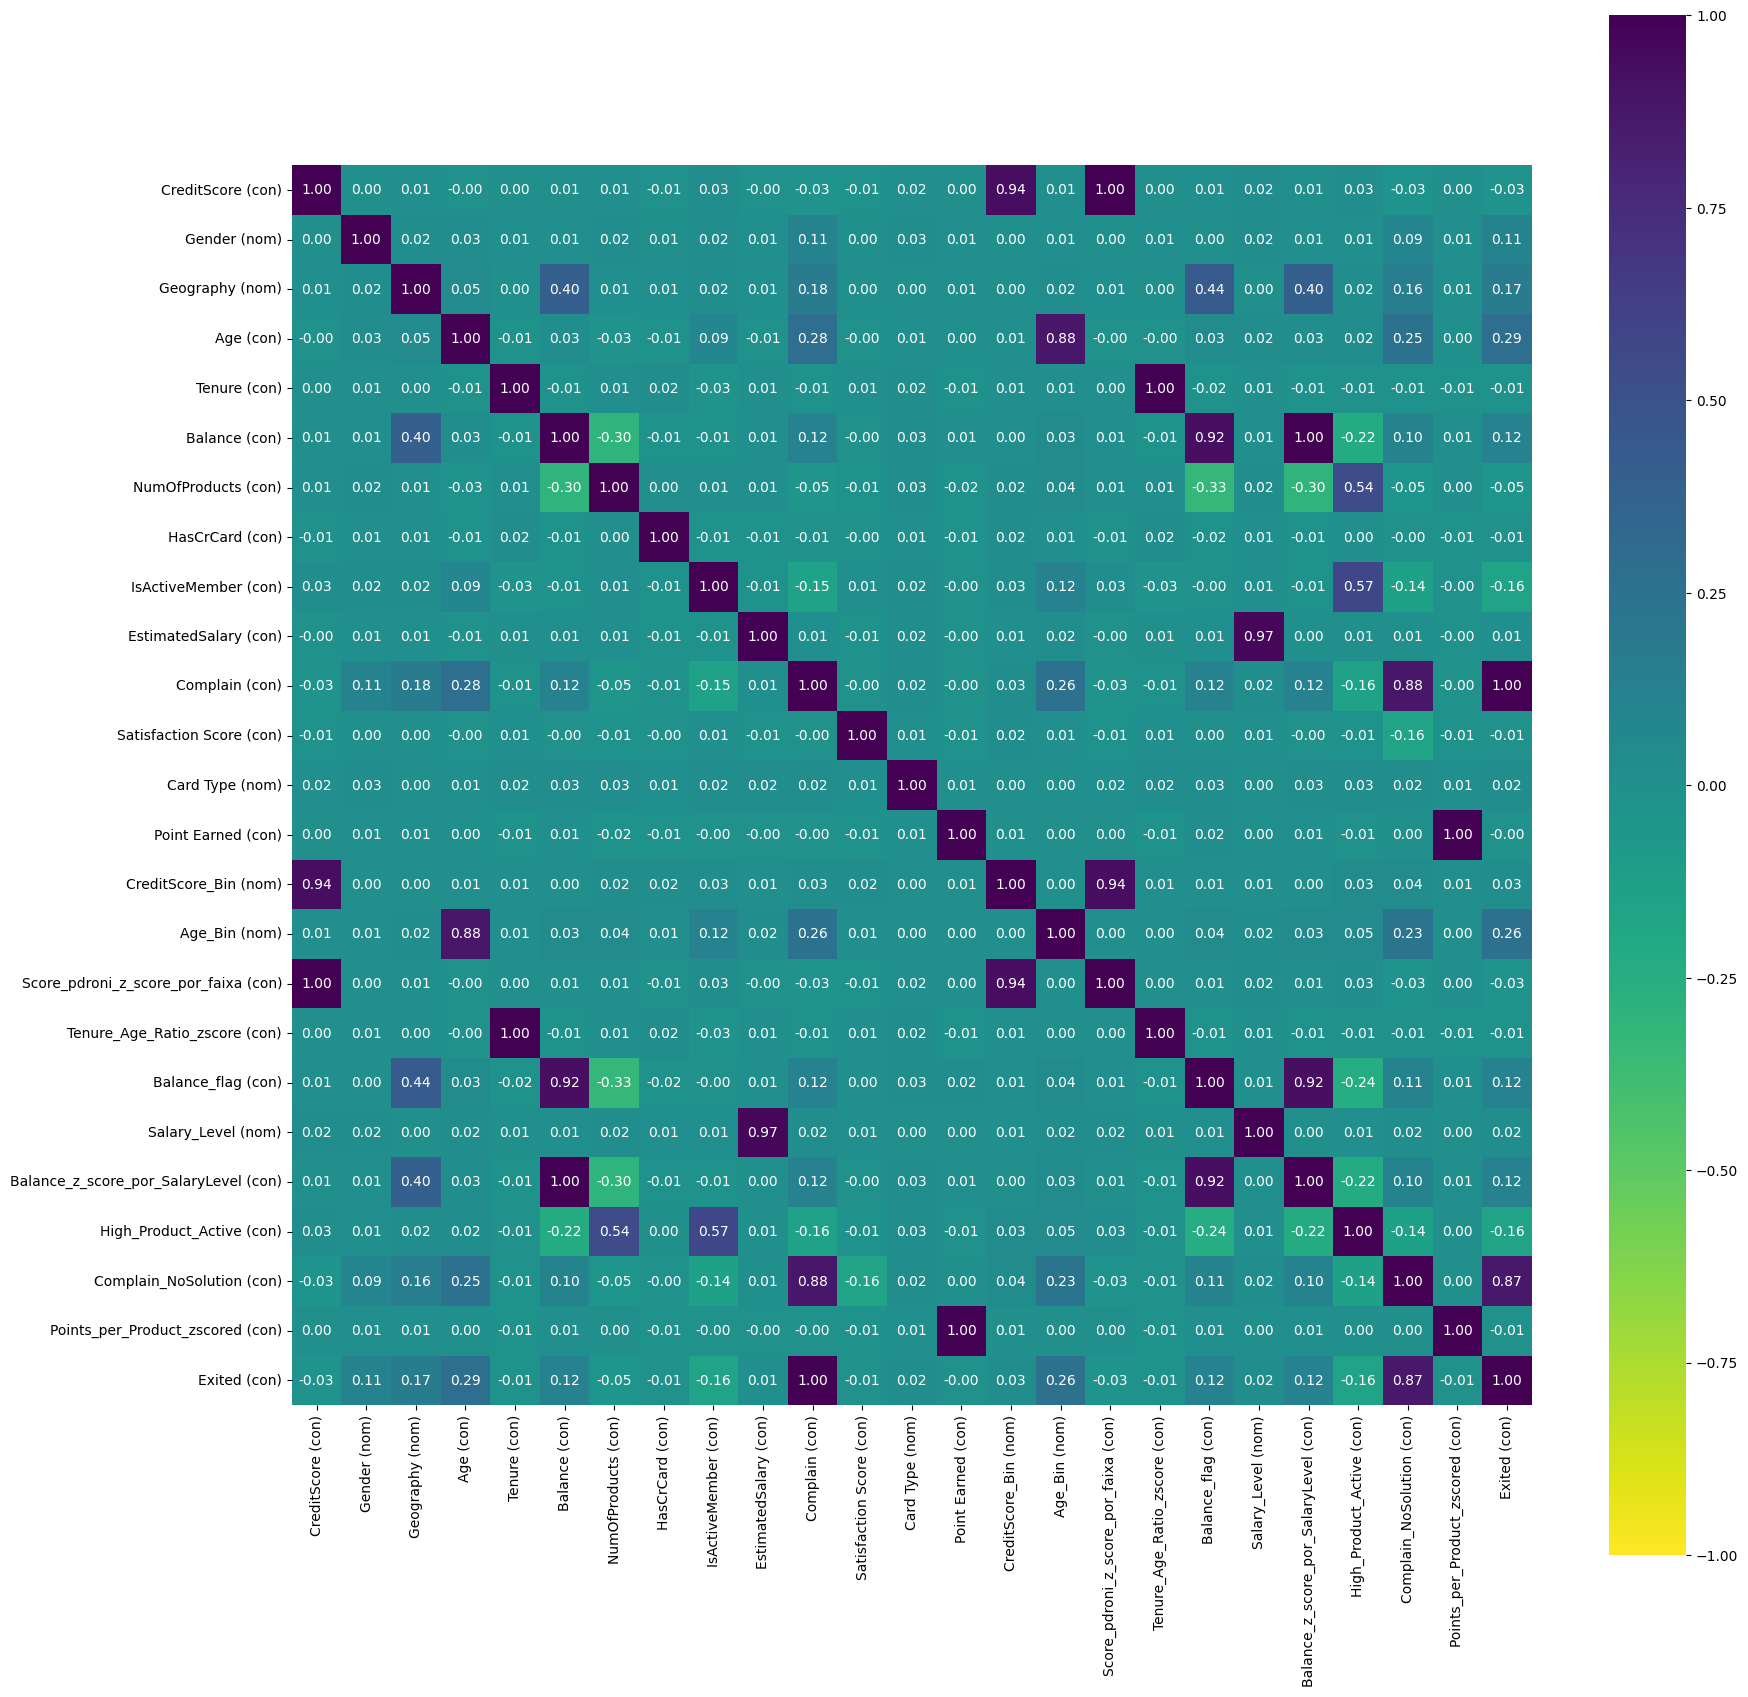

In [49]:

#Organiza o df apenas (def de apoio nada especifico desse trecho)
def mover_target_para_final(df, target): 
    """
    Move a variavel alvo para o final do df

    Isso nao interfere em resultados, e para manter o padrao de legibilidade e facilitar a visualizacao da target
    """
    colunas = [col for col in df.columns if col != target] + [target]
    return df[colunas]


#Aplica def de reorganizar colunas 
df_selecionado = mover_target_para_final(df_selecionado, 'Exited')



associacoes = associations(
    df_selecionado,
    nominal_columns='auto',
    mark_columns=True,
    plot=True,
    figsize=(20, 20),
    cmap='viridis_r'
)


### 3.11.2 **VIF (Variance Inflation Factor) - Dependencias multivaridas :**

 - O VIF (Variance Inflation Factor) é uma métrica que quantifica o quanto uma variável **explicativa** está correlacionada com as **demais variáveis explicativas do modelo**. Para calculá-lo, realiza-se uma regressão linear onde a variável alvo é uma das variáveis explicativas originais, e as outras variáveis do conjunto são usadas como preditoras. Esse processo é repetido para cada variável, gerando um valor de VIF correspondente.

- Trata-se de um teste multivariado que vai além da simples correlação entre pares de variáveis, permitindo diagnosticar a presença de multicolinearidade no conjunto de dados.

 - Os valores de VIF são interpretados da seguinte forma:

    - VIF < 5: sem indicativo de problema relevante.

    - 5 ≤ VIF < 10: atenção, pode indicar multicolinearidade moderada.

    - VIF ≥ 10: forte multicolinearidade, recomenda-se considerar a remoção ou combinação de variáveis.

 - **O VIF é especialmente útil em modelos lineares, como regressão linear e regressão logística. Em modelos baseados em árvores, como Random Forest e XGBoost, a multicolinearidade geralmente não representa um problema significativo.**

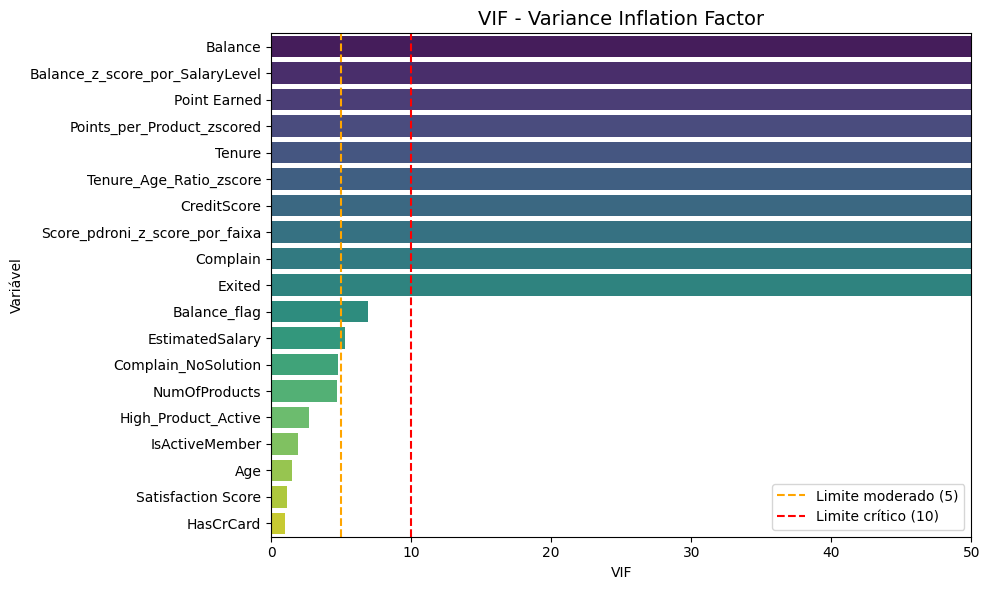

In [50]:
# Seleciona apenas as colunas numéricas (sem a target)
X = df_selecionado.select_dtypes(include=['number'])

# Adiciona constante
X_const = add_constant(X)

# Calcula VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Remove a constante da tabela
vif_data = vif_data[vif_data["Variável"] != "const"]

# Ordena por VIF (decrescente)
vif_data = vif_data.sort_values(by="VIF", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data, x="VIF", y="Variável", palette="viridis")
plt.title("VIF - Variance Inflation Factor", fontsize=14)
plt.xlabel("VIF")
plt.ylabel("Variável")
plt.axvline(x=5, color='orange', linestyle='--', label='Limite moderado (5)')
plt.axvline(x=10, color='red', linestyle='--', label='Limite crítico (10)')
plt.xlim(0, 50)  # Limita o eixo X
plt.legend()
plt.tight_layout()
plt.show()



* **Como os modelos serão majoritariamente baseados em árvores e redes neurais, que são menos sensíveis à multicolinearidade que regressões, aqui apenas observamos os resultados do VIF sem tomar decisões imediatas de remover ou filtrar variáveis.**

### 3.11.3  Importância das Variáveis com árvore "fraca"

 - importância das variáveis utilizando um modelo de árvore “fraco” (Random Forest com poucos estimadores)



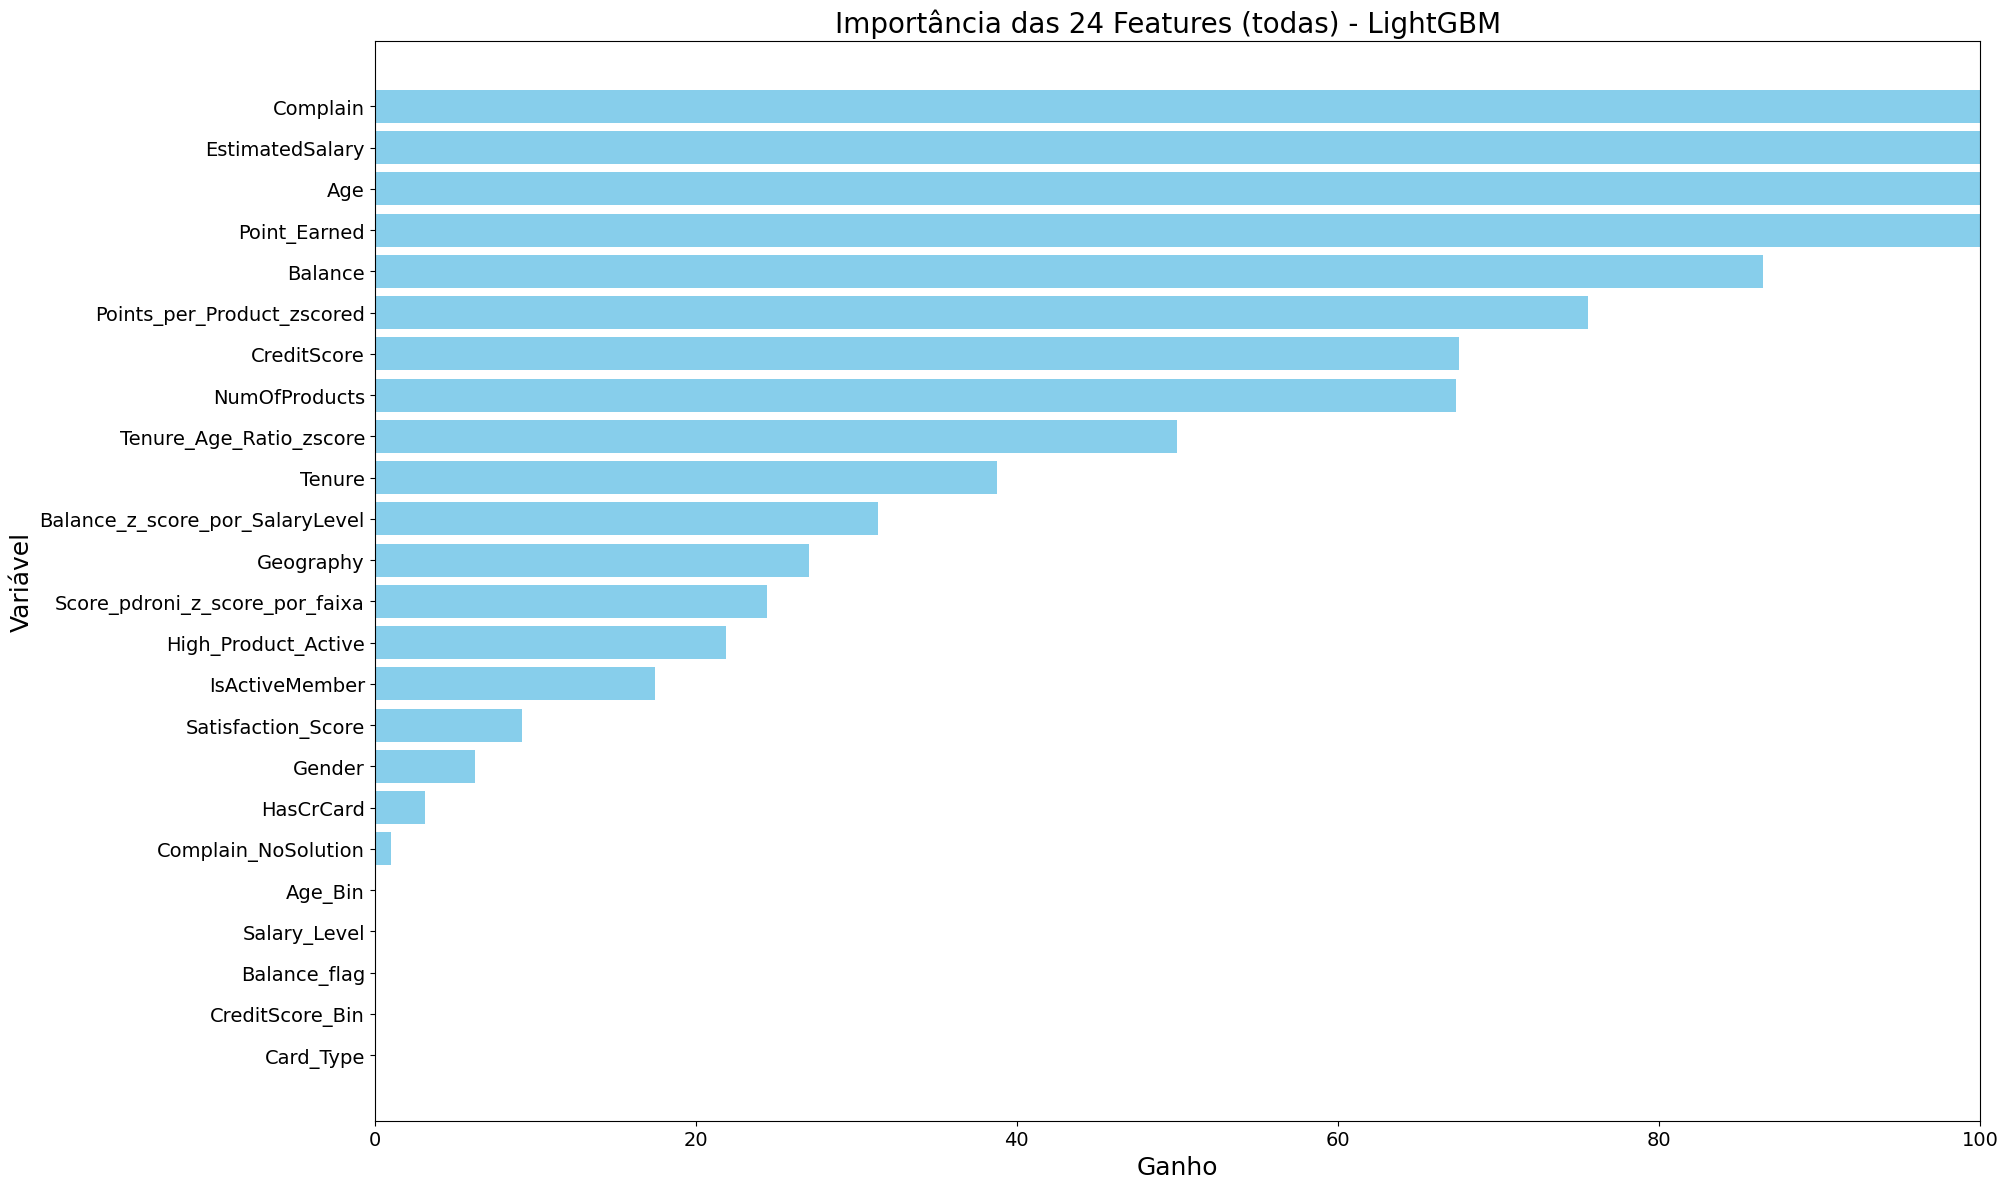

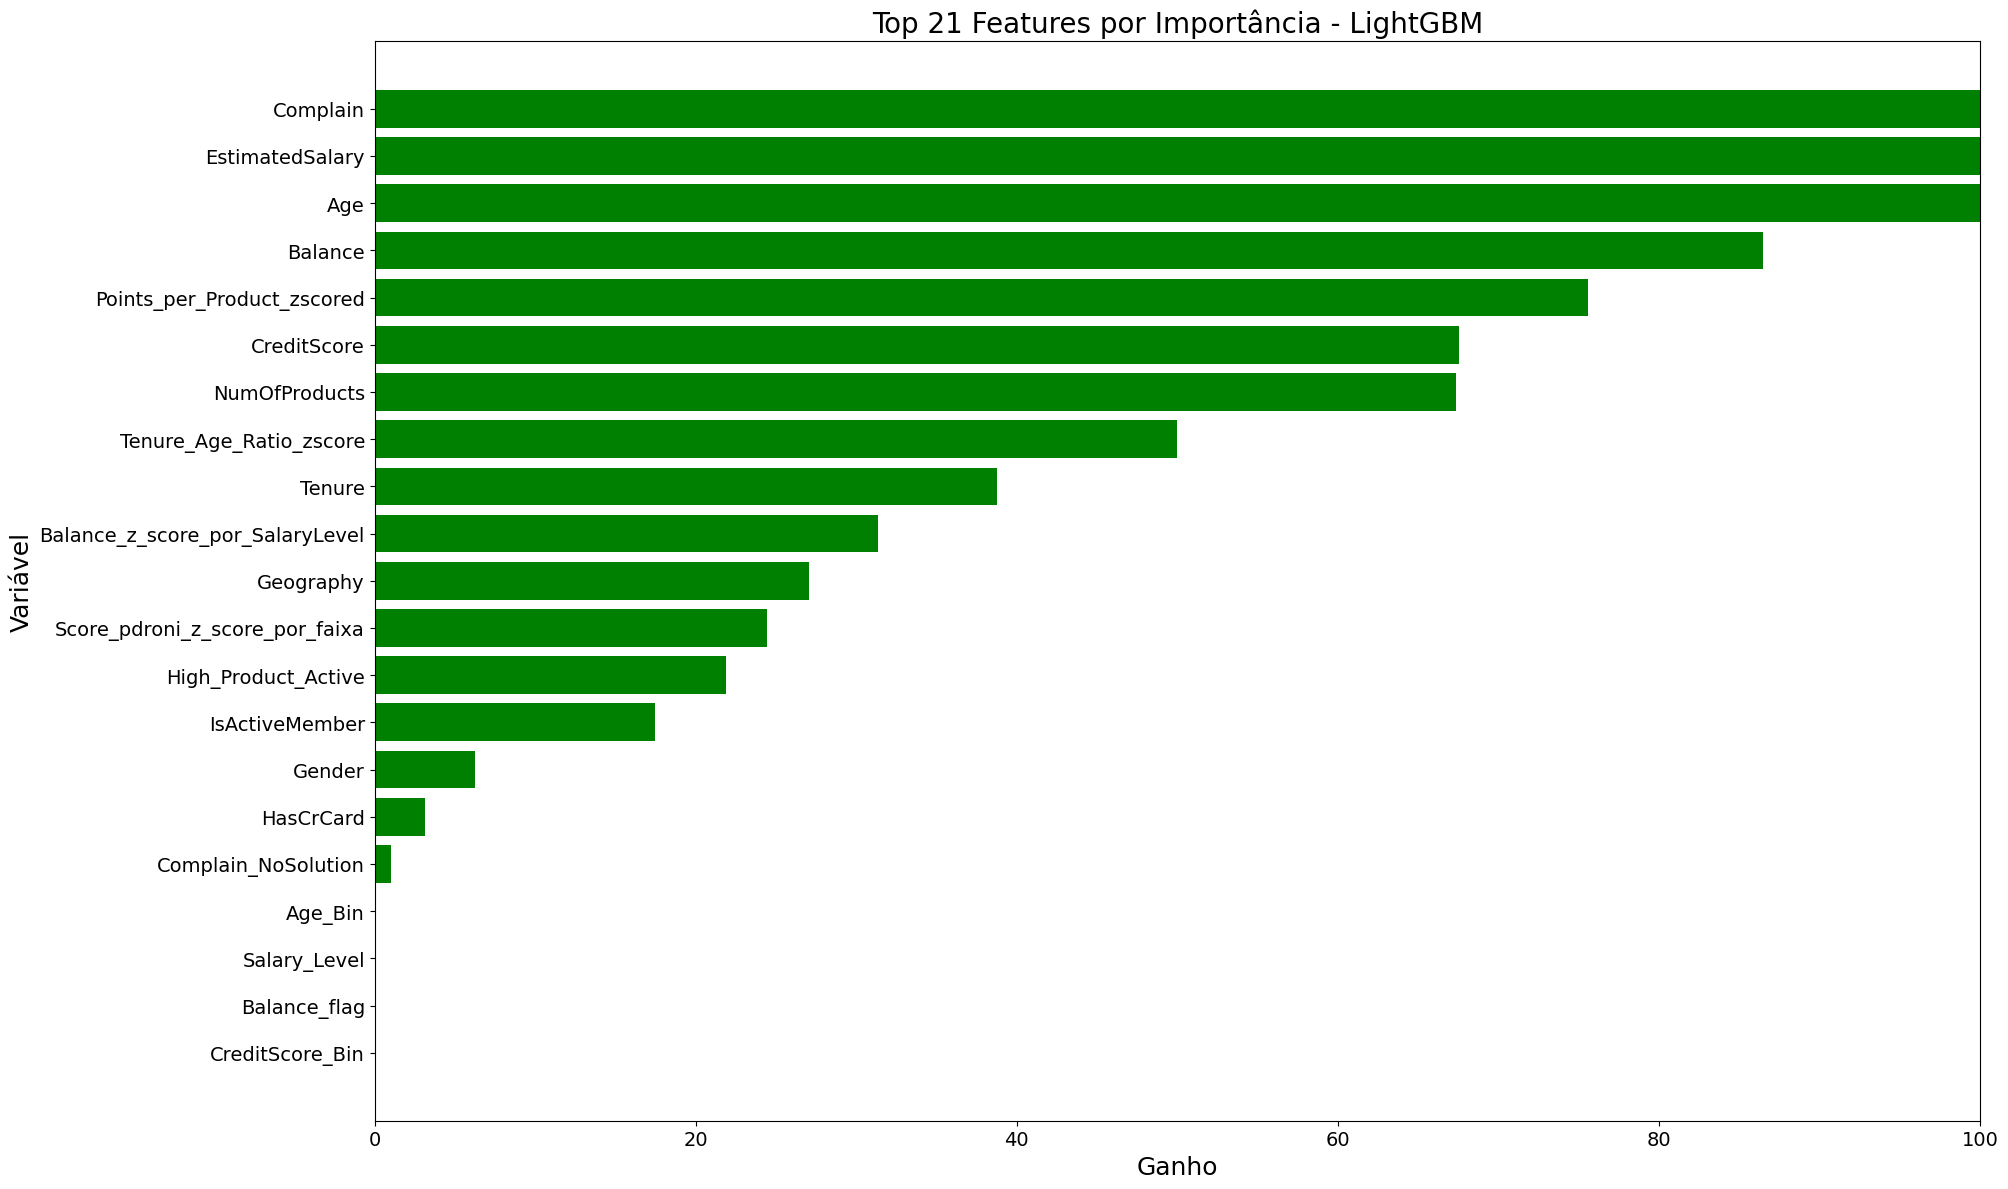

Total de features no importance_df analisadas: 24
Features com importância maior que zero: 20
Nomes das features com importância > 0:
['Age_Bin', 'Complain_NoSolution', 'HasCrCard', 'Gender', 'Satisfaction_Score', 'IsActiveMember', 'High_Product_Active', 'Score_pdroni_z_score_por_faixa', 'Geography', 'Balance_z_score_por_SalaryLevel', 'Tenure', 'Tenure_Age_Ratio_zscore', 'NumOfProducts', 'CreditScore', 'Points_per_Product_zscored', 'Balance', 'Point_Earned', 'Age', 'EstimatedSalary', 'Complain']

Features com importância igual a zero: 4
Nomes das features com importância == 0:
['Card_Type', 'CreditScore_Bin', 'Balance_flag', 'Salary_Level']


In [51]:
# Cópia do df_selecionado
df_lgb = df_selecionado.copy()

# Detectar colunas categóricas
cat_features = df_lgb.select_dtypes(include=['object']).columns.tolist()

# Converter para category
for col in cat_features:
    df_lgb[col] = df_lgb[col].astype('category')

# Atualizar lista categórica
cat_features = df_lgb.select_dtypes(include=['category']).columns.tolist()

# Definir target
target = 'Exited'

X = df_lgb.drop(columns=[target])
y = df_lgb[target]

# Dataset LightGBM
lgb_train = lgb.Dataset(X, label=y, categorical_feature=cat_features, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

# Treina o modelo
model = lgb.train(params, lgb_train, num_boost_round=500)

# Importância
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# Criar DataFrame de importância
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# 📊 Gráfico 1: Todas as features
plt.figure(figsize=(20, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Importância das Features - LightGBM (todas)', fontsize=24)
plt.title(f'Importância das {len(X.columns)} Features (todas) - LightGBM  ', fontsize=20)
plt.xlabel('Ganho', fontsize=18)
plt.ylabel('Variável', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.xlim(0, 100)
plt.show()

# 🔝 Top N features (corrigido com interseção das colunas reais do DataFrame)
top_n = 60  # ajuste se quiser outro valor
top_features = importance_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

# Filtra apenas as features que estão no df original
top_features_validas = [feat for feat in top_features if feat in df_selecionado.columns][:top_n]

# Criar novo df com somente target e top N features válidas
df_selecionado_top_features = df_selecionado[[target] + top_features_validas]


# 📊 Gráfico 2: Top N features válidas
top_df = importance_df[importance_df['Feature'].isin(top_features_validas)].sort_values(by='Importance', ascending=True)

plt.figure(figsize=(20, 12))
plt.barh(top_df['Feature'], top_df['Importance'], color='green')
plt.title(f'Top {len(top_features_validas)} Features por Importância - LightGBM', fontsize=20)
plt.xlabel('Ganho', fontsize=18)
plt.ylabel('Variável', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.xlim(0, 100)
plt.show()


# 📊 Análise das features por importância
total_features = len(importance_df)
features_importantes = importance_df[importance_df['Importance'] > 0]
features_zero = importance_df[importance_df['Importance'] == 0]

print(f"Total de features no importance_df analisadas: {total_features}")
print(f"Features com importância maior que zero: {len(features_importantes)}")
print("Nomes das features com importância > 0:")
print(features_importantes['Feature'].tolist())

print(f"\nFeatures com importância igual a zero: {len(features_zero)}")
print("Nomes das features com importância == 0:")
print(features_zero['Feature'].tolist())

* Aqui o df de top features (df_selecionado_top_features) foi criado para ser usado quando for testar com as top features. Quando isso ocorrer basta usa-lo para modelagem ao inves do df_selecionado

- O ganho (gain) indica o quanto uma variável ajudou a reduzir o erro de previsão do modelo — no caso aqui como é binário esse erro é medido pela log loss (perda logarítmica). NA prática funcionou assim: quanto maior o ganho, mais relevante a variável foi para melhorar a performance do modelo, os próximo de zero, significam que a variável teve pouca ou nenhuma contribuição nas decisões do modelo. 



# REVISAR ANTES DE CONCLUIR, SE VAI FOI APLICADO OU NAO O TEXTO A BAIXO

- **Ainda nao vamos toma decisao de corte de variaveis com base em algum limiar de decisao de importancia aqui, mas pode ser que sim apos o estudo dos modelos e os resultados.**  

#### 3.11.4 Análise de Outliers (numéricas)

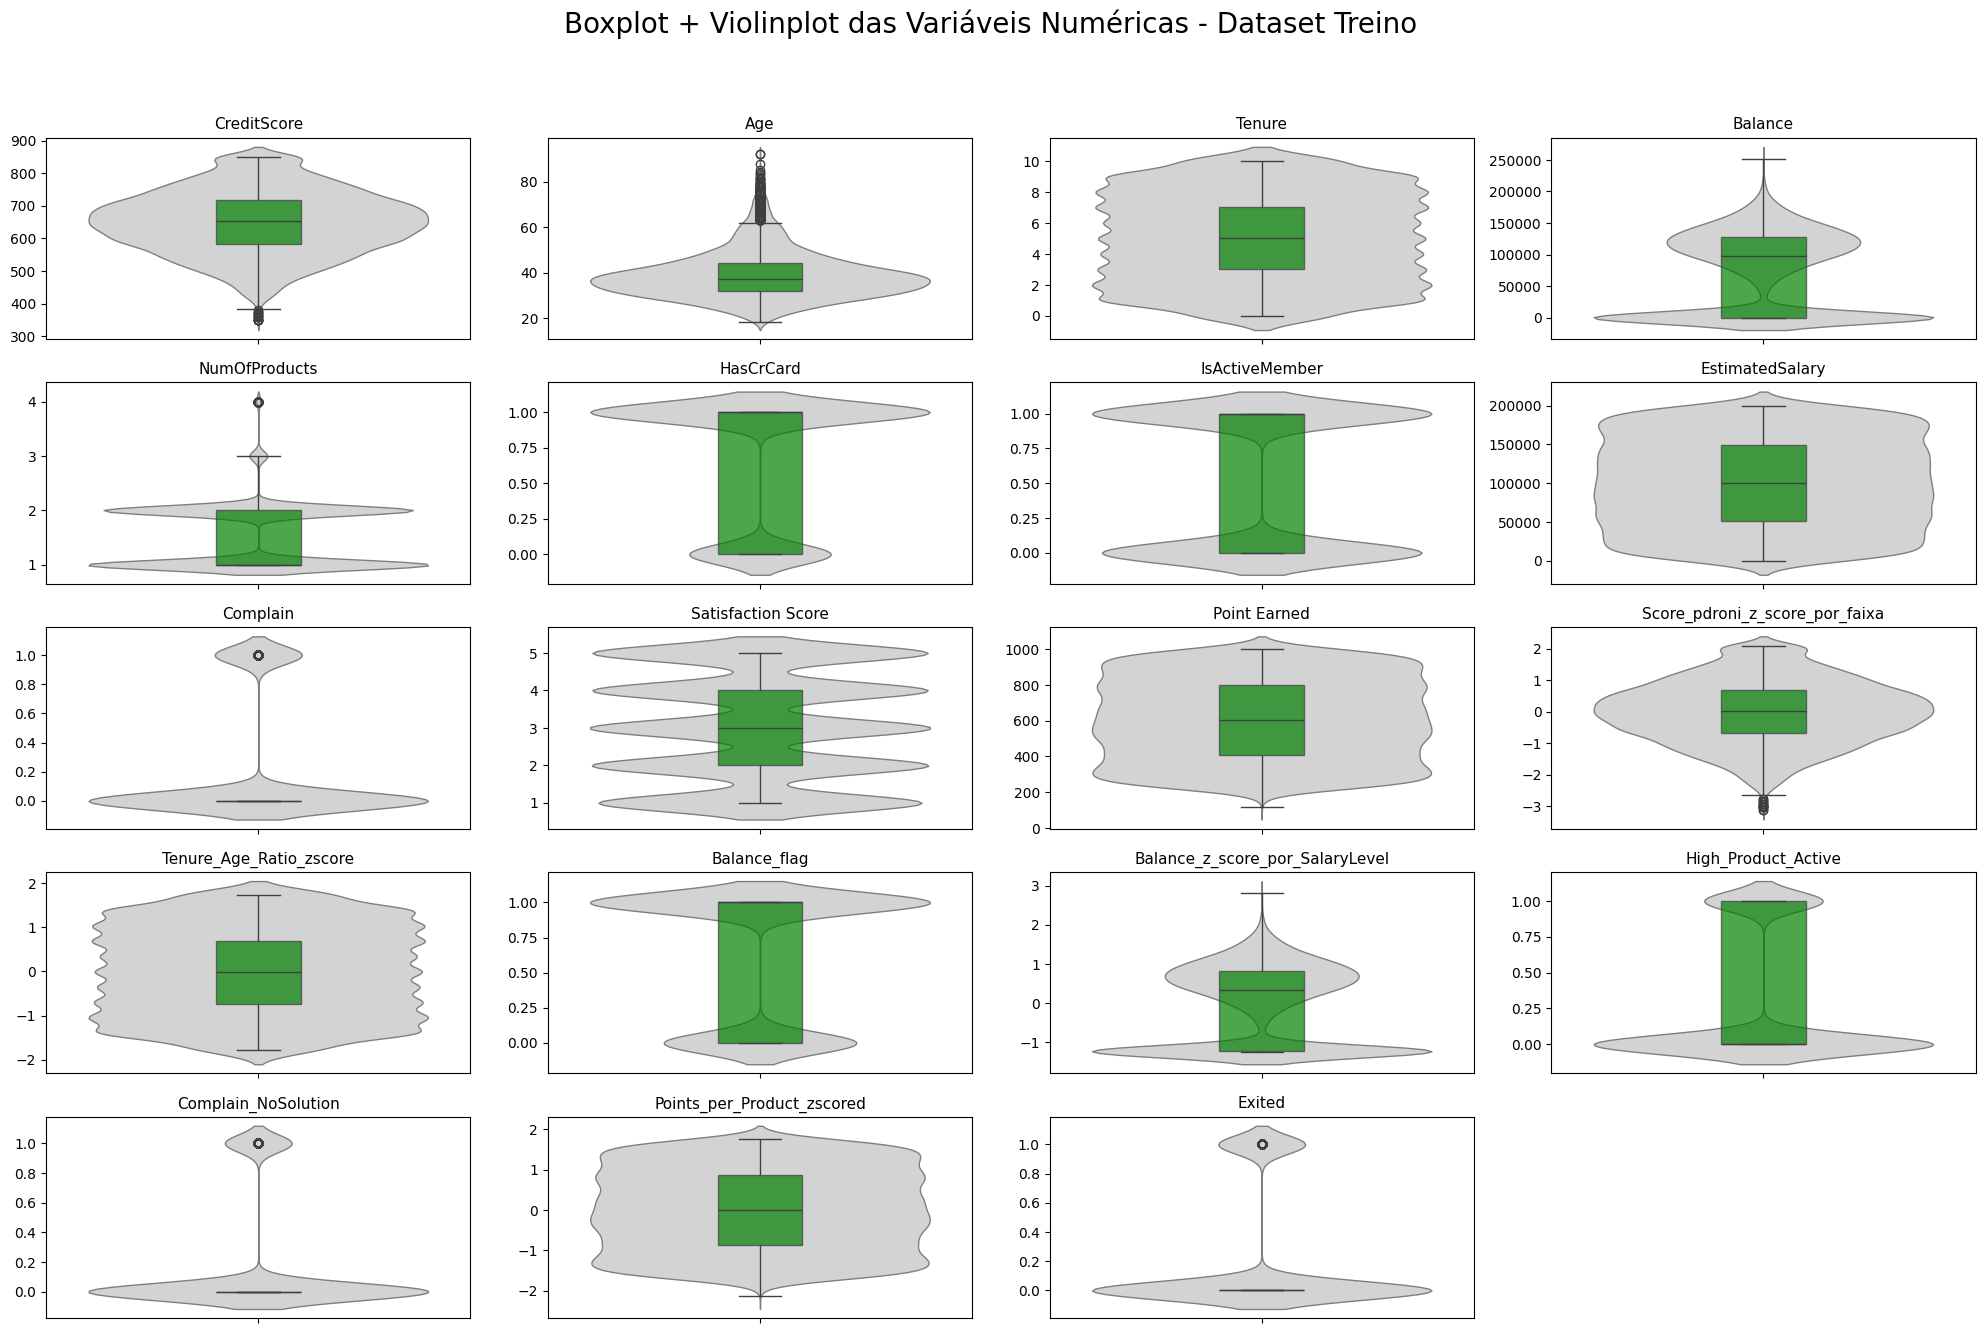

In [52]:
# lista das variáveis numéricas que você quer visualizar
variaveis = df_selecionado.select_dtypes(include='number').columns.tolist()

# tamanho da figura
plt.figure(figsize=(20, 16))

# loop de criação de subplots com boxplot + violinplot
for i, var in enumerate(variaveis):
    plt.subplot(6, 4, i + 1)  # define a grade de 6 linhas x 4 colunas (ajuste conforme o número de variáveis)
    
    # violinplot com largura menor para não sobrepor tanto
    sns.violinplot(y=df_selecionado[var], inner=None, color='lightgray', linewidth=1)
    
    # boxplot por cima
    sns.boxplot(y=df_selecionado[var],
                boxprops=dict(facecolor='green', alpha=0.7),
                width=0.2)
    
    plt.title(f'{var}', fontsize=11)
    plt.ylabel('')

# título geral
plt.suptitle('Boxplot + Violinplot das Variáveis Numéricas - Dataset Treino', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

* Vale destacar que, embora essas variáveis sejam numéricas e possam apresentar valores que aparentam ser outliers, elas representam categorias — como é o caso de Complain, NumOfProducts e da variável-alvo Exited. Nesses casos, os valores apenas indicam classes menos frequentes, e não devem ser interpretados como outliers no sentido estatístico.

* **a baixo será aplicado tratamento dos outliers, mas antes serão testadas como estão e avaliado se o tratamento de outliers é realmente necessário.**

* Consiste na criação de uma variável indicadora (flag) de outlier para cada variável em que há presença de outliers(e que faça sentido tratar, como comentado antes).
    * Essa abordagem permite preservar as informações originais das variáveis, o que é especialmente importante em contextos com volume reduzido de dados para análise.

# 4. Modelagem 

## 4.1 Separando em Treino e teste 

In [53]:


X = df_selecionado.drop('Exited', axis=1)
y = df_selecionado['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [54]:
#checando separação e proporções das classes em treino e teste 
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Total shape:", X.shape, y.shape)
print('')
print("Checagem duplicidade entre conjuntos:", set(X_train.index) & set(X_test.index))  
print('')
print('Distribuicao Geral das classes :', y.value_counts(normalize=True).map('{:.4%}'.format))
print('')
print('Distribuicao das classes em Treino:', y_train.value_counts(normalize=True).map('{:.4%}'.format) )
print('')
print('Distribuicao das classes em Teste:', y_test.value_counts(normalize=True).map('{:.4%}'.format) )


Train shape: (7000, 24) (7000,)
Test shape: (3000, 24) (3000,)
Total shape: (10000, 24) (10000,)

Checagem duplicidade entre conjuntos: set()

Distribuicao Geral das classes : Exited
0    79.6200%
1    20.3800%
Name: proportion, dtype: object

Distribuicao das classes em Treino: Exited
0    79.6143%
1    20.3857%
Name: proportion, dtype: object

Distribuicao das classes em Teste: Exited
0    79.6333%
1    20.3667%
Name: proportion, dtype: object


## 4.2 Criando Classes Transformadoras Customizadas 

In [55]:

'''AQUI MUITA ATENCAO, AO ALTERAR QUALQUER CLASSE DEVE-SE COPIAR E COLAR NO custom_transformers.py 
    ELE E USADO PARA A APLICAR O MODELO ATRAVES DO PKL DO MODELO NO FINAL E GERAR AS ANALISES DE VIES DAS DECISOES 
    E INTERPRETABILIDADE DO MODELO

    POR ISSO ATE AS LIBS FORAM DEIXADAS AQUI PARA SIMILARIDADE COM O Classes_transformadoras_customizadas.py 
'''

# Importando as bibliotecas necessárias
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd
import numpy as np



# Classe para transformação One Hot Encoder
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Inicializa o OneHotEncoder ignorando categorias desconhecidas e com saída em array denso."""
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    def fit(self, X, y=None):
        """Ajusta o codificador às categorias presentes nos dados de entrada."""
        self.encoder.fit(X)
        return self

    def transform(self, X):
        """Transforma variáveis categóricas em colunas binárias (dummies)."""
        encoded = self.encoder.transform(X)
        col_names = self.encoder.get_feature_names_out(X.columns)
        return pd.DataFrame(encoded, columns=col_names, index=X.index)



# Classe para flag de outliers com base em percentis
class OutlierPercentilFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, limites=(0.01, 0.01)):
        """
        Inicializa o transformador com limites inferiores e superiores para outliers, baseados em percentis.

        Parâmetros:
            limites (tuple): Percentis inferior e superior para detecção de outliers (ex: (0.01, 0.01) = 1%).
        """
        self.limites = limites
        self.percentis_ = None

    def fit(self, X, y=None):
        """
        Calcula os limites de outliers (percentis) para cada coluna numérica.

        Parâmetros:
            X (pd.DataFrame): Dados de entrada.

        Retorna:
            self
        """
        self.percentis_ = {}
        for col in X.select_dtypes(include=[np.number]).columns:
            p_inf = X[col].quantile(self.limites[0])
            p_sup = X[col].quantile(1 - self.limites[1])
            self.percentis_[col] = (p_inf, p_sup)
        return self

    def transform(self, X):
        """
        Cria colunas binárias indicando se os valores estão fora dos limites definidos.

        Parâmetros:
            X (pd.DataFrame): Dados de entrada.

        Retorna:
            pd.DataFrame: Dados com colunas de flags de outliers adicionadas.
        """
        X_outliers = X.copy()
        for col, (p_inf, p_sup) in self.percentis_.items():
            nova_coluna = f'{col}_outlier'
            X_outliers[nova_coluna] = ((X_outliers[col] < p_inf) | (X_outliers[col] > p_sup)).astype(int)
        return X_outliers


# Classe para transformação Ordinal Encoder
class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Inicializa o codificador ordinal para transformar categorias em números inteiros ordenados."""
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        """
        Ajusta o codificador às categorias presentes nos dados.

        Parâmetros:
            X (pd.DataFrame): Dados de entrada.

        Retorna:
            self
        """
        self.encoder.fit(X)
        return self

    def transform(self, X):
        """
        Transforma as categorias em valores inteiros ordenados.

        Parâmetros:
            X (pd.DataFrame): Dados categóricos.

        Retorna:
            pd.DataFrame: Dados transformados com categorias codificadas ordinalmente.
        """
        encoded = self.encoder.transform(X)
        return pd.DataFrame(encoded, columns=X.columns, index=X.index)



* Verificando tipos para análise de quais transformações devem ser aplicadas
    * Essa etapa é analisada junto com a informação que a variável carrega, quão cardinalizada ela é, sua variação, se a ordem é importante, etc. 

In [56]:
print(df_selecionado.dtypes)

CreditScore                           int64
Gender                               object
Geography                            object
Age                                   int64
Tenure                                int64
Balance                             float64
NumOfProducts                         int64
HasCrCard                             int64
IsActiveMember                        int64
EstimatedSalary                     float64
Complain                              int64
Satisfaction Score                    int64
Card Type                            object
Point Earned                          int64
CreditScore_Bin                    category
Age_Bin                            category
Score_pdroni_z_score_por_faixa      float64
Tenure_Age_Ratio_zscore             float64
Balance_flag                          int64
Salary_Level                       category
Balance_z_score_por_SalaryLevel     float64
High_Product_Active                   int64
Complain_NoSolution             

* Removendo as variaveis altamente correlacionadas

In [57]:
variaveis_para_remover = [
    'Age_Bin',
    'Score_padron_z_score_por_faixa',
    'Tenure_Age_Ratio_zscore',
    'Balance_z_score_por_SalaryLevel',
    'Complain_NoSolution',
    'Points_per_Product_zscored'
]


df_selecionado = df_selecionado.drop(columns=variaveis_para_remover, errors='ignore')


* Organizando as variáveis por tipo de transformação 

In [58]:
'''Listas organizadas de colunas que serao aplicadas transformações 
    Aqui é criado um dicionário para cada tipo de transformação
    OBS: nem toda variável precisou de transformação'''

onehot_cols = ['Gender','Geography']

#ordinal_cols = ['Tenure','NumOfProducts','Satisfaction Score',
#                'Card Type','CreditScore_Bin','Age_Bin','Salary_Level']
ordinal_cols = ['Tenure','NumOfProducts','Satisfaction Score',
                'Card Type','CreditScore_Bin','Salary_Level']





outliers_cols = [] # primeiro será testado sem aplicar essa  (depois so colcoar CreditScore e Age )
                    #AQUI E IMPORTANTE CERTIFICAR QUE NA HORA DE APLICAR O PIPELINE O TRATAMENTO DE 
                    #OUTLIERS SEJA FEITO ANTESSS DE APLICAR O SCALER 

scaler_cols = ['CreditScore','Age','Balance','EstimatedSalary','Point Earned'] 
#scaler_cols = ['CreditScore','Age','Balance','EstimatedSalary','Point Earned'] 

## 4.3 Optuna: Melhores Hiperparametros & Aplicação de Pipelines 

 dar uma estudada se da pra deixar mais claro o fluxo aplicando igual o de deteccao de fraude.

In [59]:

#warnings.filterwarnings("ignore", message="A module that was compiled using NumPy 1.x cannot be run in NumPy 2.1.3")
 
#reclama por incompatibilidade com aversao do numpy antes e do numpy que o torch usa, se der problema mais pra 
# frente so comentar esse trecho, instalar as lib nas versoes novas e ser feliz 


# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
tree_method_ = "gpu_hist" if use_gpu else "hist"

print(f"Usando GPU: {use_gpu}")
print(f"Método de árvore: {tree_method_}")

# ==================== Variáveis Globais ==================== 
threshold = 0.5
n_trials_ = 1
n_splits_ = 5

'''
weights_skf = {
    'Accuracy': 0.0,          
    # Mede a acurácia do modelo nas predições (proporção total de acertos). 
    # Pode enganar em bases desbalanceadas.

    'f1': 0.15,               
    # Média harmônica entre precisão e recall (equilíbrio entre os dois).
    # Quanto mais próximo de 1, melhor.

    'precision': 0.25,        
    # Proporção de positivos previstos que são corretos.
    # Quanto mais próximo de 1, melhor (penaliza falsos positivos).

    'recall': 0.45,           
    # Proporção de positivos reais capturados pelo modelo.
    # Quanto mais próximo de 1, melhor (penaliza falsos negativos).

    'auc': 0.05,              
    # Mede a capacidade de separação entre classes (área sob a curva ROC).
    # Quanto mais próximo de 1, melhor.

    'balanced_acc': 0.0,     
    # Média das acurácias por classe (corrige o impacto do desbalanceamento).
    # Quanto mais próximo de 1, melhor.

    'mcc': 0.00,              
    # Correlação entre predições e verdadeiros (varia de -1 a 1).
    # Quanto mais próximo de 1, melhor (bom em desbalanceamento).

    'brier_score': 0.05,      
    # Mede o quão próximas as probabilidades estão dos rótulos reais.
    # Quanto menor, melhor (avalia calibração das probabilidades).

    'log_loss': 0.05          
    # Penaliza previsões erradas e muito confiantes.
    # Quanto menor, melhor (mede qualidade das probabilidades).
}
'''

#TESTANDO UMA CONFIG FOCADA EM UM MODELO DE PROPENSAO A CHURN COM FOCO MAIOR NA QUALIDADE DAS PROBABILIDADES 


weights_skf = {
    'Accuracy': 0.0,          
    # Mede a acurácia do modelo nas predições (proporção total de acertos). 
    # Pode enganar em bases desbalanceadas.

    'f1': 0.10,               
    # Média harmônica entre precisão e recall (equilíbrio entre os dois).
    # Quanto mais próximo de 1, melhor.

    'precision': 0.05,        
    # Proporção de positivos previstos que são corretos.
    # Quanto mais próximo de 1, melhor (penaliza falsos positivos).

    'recall': 0.20,           
    # Proporção de positivos reais capturados pelo modelo.
    # Quanto mais próximo de 1, melhor (penaliza falsos negativos).

    'auc': 0.30,              
    # Mede a capacidade de separação entre classes (área sob a curva ROC).
    # Quanto mais próximo de 1, melhor.

    'balanced_acc': 0.05,     
    # Média das acurácias por classe (corrige o impacto do desbalanceamento).
    # Quanto mais próximo de 1, melhor.

    'mcc': 0.05,              
    # Correlação entre predições e verdadeiros (varia de -1 a 1).
    # Quanto mais próximo de 1, melhor (bom em desbalanceamento).

    'brier_score': 0.20,     
    # Mede o quão próximas as probabilidades estão dos rótulos reais.
    # Quanto menor, melhor (avalia calibração das probabilidades).

    'log_loss': 0.10,         
    # Penaliza previsões erradas e muito confiantes.
    # Quanto menor, melhor (mede qualidade das probabilidades).
}







# ==================== Função de Construção de Pipeline ==================== 
def construir_pipeline(modelo):
    """
    Constrói um pipeline com etapas de pré-processamento e o modelo especificado.
    
    Etapas do pipeline:
    - Codificação One-Hot
    - Codificação Ordinal 
    - Padronização (scaling)
    
    Parâmetros:
    modelo: objeto
        Instância do modelo 
    
    Retorna:
    pipeline: Objeto de pipeline com pré-processamento e modelo encadeados.
    """
    pre_processador = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
        ('ordinal', OrdinalEncoderTransformer(), ordinal_cols),
        # ('outliers_percentil', OutlierPercentilFlagTransformer(limites=(0.01, 0.01)), outliers_cols),
        ('scaler', StandardScaler(), scaler_cols)
    ])
    
    pipeline = Pipeline([
        ('preprocessamento', pre_processador),
        ('modelo', modelo)
    ])
    
    return pipeline



# ==================== Função de Geração de Folds e Treinamento ====================

def calcular_probs(pipeline, X_valid, threshold=0.5):
    """
    def auxiliar a gerar_folds_e_treinar() - separar para melhorar a legibilidade-, 
    recebe o pipeline treinado e o conjunto de validação e retorna
    as probabilidades e as predições binárias, tratando cada modelo.
    """
    modelo_base = pipeline[-1]

    if modelo_base.__class__.__name__ == "XGBClassifier":
        log_odds = pipeline.predict(X_valid, output_margin=True)
        probs = expit(log_odds) #sigmoid 

    elif modelo_base.__class__.__name__ == "HistGradientBoostingClassifier":
        log_odds = pipeline.decision_function(X_valid)
        probs = expit(log_odds)

    elif modelo_base.__class__.__name__ == "MLPClassifier":
        probs = pipeline.predict_proba(X_valid)[:, 1]

    else:
        raise ValueError(f"Modelo '{modelo_base.__class__.__name__}' não tratado explicitamente.")

    preds = (probs >= threshold).astype(int)
    return probs, preds


def gerar_folds_e_treinar(trial, X, y, pipeline, n_splits=n_splits_, smote=None, threshold=0.5):
    """
    Recebe o pipeline treinado e o conjunto de validação e retorna
    as probabilidades e as predições binárias (calcula usando a def calcular_probs()). 
    Trata cada modelo de forma específica: XGB e HistGradientBoosting retornam log-odds (importante para calibração dos modelos no treinament final) que são
    convertidos em probabilidades via sigmoid;
     
    MLP retorna probabilidades diretamente (sem calibragem).
    """


    global weights_skf

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metricas_acumuladas = {k: [] for k in weights_skf.keys()}
    scores_ponderados = []

    for fold, (idx_treino, idx_valid) in enumerate(skf.split(X, y), 1):
        inicio = time.time()

        X_treino, X_valid = X.iloc[idx_treino], X.iloc[idx_valid]
        y_treino, y_valid = y.iloc[idx_treino], y.iloc[idx_valid]

        if smote is not None:
            X_treino, y_treino = smote.fit_resample(X_treino, y_treino)

        pipeline.fit(X_treino, y_treino)

        # chama def anterior que calcula probabilidades, log-odds e as predições binárias com base no threshold
        probs, preds = calcular_probs(pipeline, X_valid, threshold)

        brier_real = brier_score_loss(y_valid, probs)
        logloss_real = log_loss(y_valid, probs)

        metricas = {
            'Accuracy': accuracy_score(y_valid, preds),
            'f1': f1_score(y_valid, preds, zero_division=0),
            'precision': precision_score(y_valid, preds, zero_division=0),
            'recall': recall_score(y_valid, preds, zero_division=0),
            'auc': roc_auc_score(y_valid, probs),
            'balanced_acc': balanced_accuracy_score(y_valid, preds),
            'mcc': matthews_corrcoef(y_valid, preds),
            'brier_score': 1 - brier_real,
            'log_loss': 1 - logloss_real
        }

        metricas_print = metricas.copy()
        metricas_print['brier_score'] = brier_real
        metricas_print['log_loss'] = logloss_real

        for k in metricas_acumuladas:
            metricas_acumuladas[k].append(metricas[k])

        score_fold = sum(weights_skf.get(k, 0) * metricas[k] for k in metricas)
        scores_ponderados.append(score_fold)

        duracao = time.time() - inicio

        print(
            f"📁 Fold {fold}/{n_splits} | "
            + " | ".join([f"{k}: {v:.4f}" for k, v in metricas_print.items()])
            + f" | Score Ponderado: {score_fold:.4f} | Tempo: {duracao:.2f}s"
        )

    for k, valores in metricas_acumuladas.items():
        trial.set_user_attr(k, np.mean(valores))

    return np.mean(scores_ponderados)






# ==================== Funções Objetivo para Cada Modelo ====================

# =======================
#  XGBoost Objective
# =======================
def objective_xgb(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para XGBoost...")

    

    
    model = XGBClassifier(
        #objetivo e booster
        booster=trial.suggest_categorical('booster', ['gbtree', 'dart']),
        objective='binary:logitraw', # esse retorna os log-odds brutos, antes da apicacao da sigmpoid que converte em probabilidades, 
                                     # importante para calibracao de probabilidades que sera feita. 
        #crescimento da arvore 
        grow_policy=trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        max_depth=trial.suggest_int('max_depth', 3, 7),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        max_bin = trial.suggest_categorical('max_bin', [128, 256]),
        #max_bin = trial.suggest_categorical('max_bin', [128, 256, 512, 896]),

        #Subamostragem
        subsample=trial.suggest_float('subsample', 0.5, 0.8),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),
        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.8, 1.0),
        #colsample_bynode=trial.suggest_float('colsample_bynode', 0.6, 1.0), junto com os outros oferece risco de underfiting, vamos testar
        
        #Otimizacao
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        n_estimators = trial.suggest_categorical('n_estimators', [100, 150]),
        #n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500, 800]),

        # regularizacao
        gamma=trial.suggest_float('gamma', 0.01, 10.0),
        reg_alpha=trial.suggest_float('alpha', 0.1, 2.0, log=True),
        reg_lambda=trial.suggest_float('lambda', 0.1, 2.0, log=True),
        max_delta_step=trial.suggest_float('max_delta_step', 0.8, 2.0),

        #Desbalanceamento
        scale_pos_weight=trial.suggest_int('scale_pos_weight', 2, 7),


        #demais configs tecnicas 
        tree_method='gpu_hist',
        eval_metric=trial.suggest_categorical("eval_metric", ["aucpr", "logloss"]), # serve como referencia interna de como o modelo esta perfrmamndo durante o tuning 
                                                                                    #(não afeta o treinamento em si, mas o modelo usa para avaliacao interna).
        silent=1, #silencia warnings e mensagens durante o treino
        random_state=42, #Garante reprodutibilidade dos resultados.
        n_jobs=-1 #Usa todos os núcleos disponíveis da CPU para paralelização.



    )

    pipeline = construir_pipeline(model)

    try:
        score = gerar_folds_e_treinar(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e


# =======================
# HistGradientBoosting Objective
# =======================
def objective_histgb(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para HistGradientBoosting...")

    model = HistGradientBoostingClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.07, log=True),
        max_iter=trial.suggest_int("max_iter", 100, 600),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 15, 40),
        l2_regularization=trial.suggest_float("l2_regularization", 0.5, 5.0, log=True),
        max_bins=trial.suggest_int("max_bins", 128, 255),
        early_stopping=False,
        class_weight="balanced",
        random_state=42,
        max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 50, 150)
    )


    pipeline = construir_pipeline(model)

    try:
        score = gerar_folds_e_treinar(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e


# =======================
# Rede Neural - MLP
# =======================

def objective_NN_MLP(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para MLP...")

    hidden_layer_configs = {
        "config_1": (250,),
        "config_2": (150, 100), 
        "config_3": (200, 150)

    }

    config_key = trial.suggest_categorical("hidden_layer_config", list(hidden_layer_configs.keys()))
    hidden_layer_sizes = hidden_layer_configs[config_key]

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver=trial.suggest_categorical("solver", ["adam"]),
        alpha=trial.suggest_float("alpha", 0.0001, 0.01, log=True),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.005, 0.03, log=True),
        max_iter=trial.suggest_int("max_iter", 50, 300),
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.2,
        random_state=42
    )

    pipeline = construir_pipeline(model)

    try:
        score = gerar_folds_e_treinar(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e




models = {
    "XGBoost": objective_xgb,
    "NN_MLP":objective_NN_MLP,
    "HistGb": objective_histgb
    }



best_hyperparams = {} # Dicionário para armazenar os melhores hiperparâmetros de cada modelo
storage_="sqlite:///Churn_study_models_by_Optuna.db"

def optimize_all_models():
    """
    Executa a otimização de hiperparâmetros com Optuna para todos os modelos definidos no dicionário `models`.

    Para cada modelo:
    - Cria um estudo com nome específico no banco SQLite 'Churn_study_models_by_Optuna.db'.
    - Usa o TPE Sampler (Tree-structured Parzen Estimator) com parâmetros customizados.
    - Continua um estudo existente, se ele já estiver salvo (load_if_exists=True).
    - Armazena os melhores hiperparâmetros no dicionário `best_hyperparams`.

    Visualização:
    - Para acompanhar os estudos via navegador, rode no terminal: 
            optuna-dashboard "sqlite:///CAMINHO/arquivo_estudo.db" ------> uma dica aqui e copiar o caminho absoluto do arquivo e colar depois das 3 barras apos sqlite
            exemplo: optuna-dashboard "sqlite:///C:/Users/USUARIO_X/OneDrive/Documentos/GitHub/PASTA_X/Churn_predict/PASTA_Y/Churn_study_models_by_Optuna.db"
      e acesse o endereço fornecido. 
      (em caso de dúvida ler Dahsboard_Optuna_observacoes.md)
    - O dashboard só carrega se ao menos um estudo já tiver sido iniciado ou salvo.

    Observação:
    - O banco pode ser criado previamente com:
        storage = optuna.storages.RDBStorage(url="sqlite:///Churn_study_models_by_Optuna.db")
        Mas precisa rodar antes (ou em outro notebook, para criar o banco mesmo) 
        e a partir disso o banco pode ser chamado pela url acima

    
    Para conferir se estudos foram gravados no banco rode o codigo a baixo, se a lista vier com os nome dos modelos foi criado
    ((((((((((((import optuna
    storage = optuna.storages.RDBStorage(url="sqlite:///Churn_study_models_by_Optuna.db")
    studies = optuna.study.get_all_study_summaries(storage=storage)
    print([s.study_name for s in studies])))))))))))))

    
    """
    for model_name, objective_func in models.items():
        print(f"🔍 Iniciando otimização para o modelo: {model_name}")
        #verbosidade dos logs
        print('')
        optuna.logging.set_verbosity(optuna.logging.INFO)
        print('')

        
        '''Configuração do TPESampler para busca de hiperparâmetros:

        - n_startup_trials=50: fase inicial de exploração ampla para mapear bem o espaço.
        - n_ei_candidates=50: gera 50 candidatos por iteração para melhorar qualidade das sugestões.
        - group=True e multivariate=True: captura dependências entre parâmetros e grupos.
        - seed=42: garante reprodutibilidade.

        Configuração equilibrada para exploração eficiente em espaços grandes,
        essa abordagem é ampla graças a possibilidade de salvar os trials e continuar de onde parou no banco sqlite,
        assim da pra testar ao longo dos dias, processando conforme possível'''
        
        sampler_ = optuna.samplers.TPESampler(
            n_startup_trials=50,
            n_ei_candidates=50,
            group=True,
            seed=42,
            multivariate=True,
            warn_independent_sampling=False
        )

        study = optuna.create_study(
            study_name=f"{model_name}_study",
            storage=storage_,
            sampler=sampler_,
            direction='maximize',
            load_if_exists=True
        )

        study.optimize(objective_func, n_trials=n_trials_)
        best_params = study.best_params
        best_hyperparams[model_name] = best_params

        print(f"📊 MELHORES HIPERPARÂMETROS PARA O MODELO {model_name}")
        print("═" * 60)
        for param, value in best_params.items():
            print(f"{param:<25}{str(value):<15}")
        print("═" * 60)

# Roda a função
optimize_all_models()



Usando GPU: True
Método de árvore: gpu_hist
🔍 Iniciando otimização para o modelo: XGBoost




[I 2025-06-01 03:50:06,349] A new study created in RDB with name: XGBoost_study


🚀 Iniciando trial 0 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.7864 | f1: 0.5853 | precision: 0.4839 | recall: 0.7404 | auc: 0.8499 | balanced_acc: 0.7693 | mcc: 0.4683 | brier_score: 0.1491 | log_loss: 0.4607 | Score Ponderado: 0.7718 | Tempo: 2.92s
📁 Fold 2/5 | Accuracy: 0.7771 | f1: 0.5618 | precision: 0.4684 | recall: 0.7018 | auc: 0.8268 | balanced_acc: 0.7491 | mcc: 0.4357 | brier_score: 0.1534 | log_loss: 0.4655 | Score Ponderado: 0.7500 | Tempo: 2.61s
📁 Fold 3/5 | Accuracy: 0.7764 | f1: 0.5622 | precision: 0.4674 | recall: 0.7053 | auc: 0.8177 | balanced_acc: 0.7499 | mcc: 0.4363 | brier_score: 0.1586 | log_loss: 0.4904 | Score Ponderado: 0.7445 | Tempo: 2.97s
📁 Fold 4/5 | Accuracy: 0.7979 | f1: 0.5893 | precision: 0.5037 | recall: 0.7098 | auc: 0.8286 | balanced_acc: 0.7651 | mcc: 0.4722 | brier_score: 0.1498 | log_loss: 0.4627 | Score Ponderado: 0.7603 | Tempo: 3.31s


[I 2025-06-01 03:50:22,185] Trial 0 finished with value: 0.7578219189863971 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'max_depth': 3, 'min_child_weight': 2, 'max_bin': 256, 'subsample': 0.6803345035229627, 'colsample_bytree': 0.9124217733388136, 'colsample_bylevel': 0.8041168988591605, 'learning_rate': 0.18276027831785724, 'n_estimators': 100, 'gamma': 1.8264314223989353, 'alpha': 0.17322667470546263, 'lambda': 0.24878734419814433, 'max_delta_step': 1.4297077179586855, 'scale_pos_weight': 4, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.7578219189863971.


📁 Fold 5/5 | Accuracy: 0.7686 | f1: 0.5668 | precision: 0.4589 | recall: 0.7413 | auc: 0.8425 | balanced_acc: 0.7584 | mcc: 0.4432 | brier_score: 0.1549 | log_loss: 0.4721 | Score Ponderado: 0.7625 | Tempo: 3.63s
✅ Trial 0 finalizado | Score: 0.7578 | Tempo: 15.73 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO XGBoost
════════════════════════════════════════════════════════════
booster                  dart           
grow_policy              depthwise      
max_depth                3              
min_child_weight         2              
max_bin                  256            
subsample                0.6803345035229627
colsample_bytree         0.9124217733388136
colsample_bylevel        0.8041168988591605
learning_rate            0.18276027831785724
n_estimators             100            
gamma                    1.8264314223989353
alpha                    0.17322667470546263
lambda                   0.24878734419814433
max_delta_step           1.4297077179586855
scale_pos_weigh

[I 2025-06-01 03:50:22,276] Using an existing study with name 'NN_MLP_study' instead of creating a new one.


🚀 Iniciando trial 3 para MLP...
📁 Fold 1/5 | Accuracy: 0.8457 | f1: 0.5798 | precision: 0.6507 | recall: 0.5228 | auc: 0.8254 | balanced_acc: 0.7255 | mcc: 0.4910 | brier_score: 0.1192 | log_loss: 0.3894 | Score Ponderado: 0.7407 | Tempo: 2.27s
📁 Fold 2/5 | Accuracy: 0.8286 | f1: 0.4872 | precision: 0.6230 | recall: 0.4000 | auc: 0.8016 | balanced_acc: 0.6691 | mcc: 0.4039 | brier_score: 0.1253 | log_loss: 0.4029 | Score Ponderado: 0.6886 | Tempo: 2.03s
📁 Fold 3/5 | Accuracy: 0.8343 | f1: 0.5415 | precision: 0.6199 | recall: 0.4807 | auc: 0.8152 | balanced_acc: 0.7027 | mcc: 0.4477 | brier_score: 0.1227 | log_loss: 0.4029 | Score Ponderado: 0.7185 | Tempo: 2.49s
📁 Fold 4/5 | Accuracy: 0.8393 | f1: 0.4186 | precision: 0.8020 | recall: 0.2832 | auc: 0.8147 | balanced_acc: 0.6326 | mcc: 0.4134 | brier_score: 0.1211 | log_loss: 0.3965 | Score Ponderado: 0.6714 | Tempo: 2.04s


[I 2025-06-01 03:50:33,297] Trial 3 finished with value: 0.7081496165435246 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020511104188433984, 'learning_rate_init': 0.005548400980049733, 'max_iter': 267}. Best is trial 2 with value: 0.7136952946913062.


📁 Fold 5/5 | Accuracy: 0.8436 | f1: 0.5389 | precision: 0.6772 | recall: 0.4476 | auc: 0.8247 | balanced_acc: 0.6964 | mcc: 0.4634 | brier_score: 0.1167 | log_loss: 0.3796 | Score Ponderado: 0.7214 | Tempo: 1.91s
✅ Trial 3 finalizado | Score: 0.7081 | Tempo: 10.93 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO NN_MLP
════════════════════════════════════════════════════════════
hidden_layer_config      config_2       
activation               tanh           
solver                   adam           
alpha                    0.00019010245319870352
learning_rate_init       0.008439228148542133
max_iter                 141            
════════════════════════════════════════════════════════════
🔍 Iniciando otimização para o modelo: HistGb




[I 2025-06-01 03:50:33,370] Using an existing study with name 'HistGb_study' instead of creating a new one.


🚀 Iniciando trial 3 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.8179 | f1: 0.5771 | precision: 0.5472 | recall: 0.6105 | auc: 0.8302 | balanced_acc: 0.7407 | mcc: 0.4626 | brier_score: 0.1303 | log_loss: 0.4152 | Score Ponderado: 0.7488 | Tempo: 2.51s
📁 Fold 2/5 | Accuracy: 0.8136 | f1: 0.5657 | precision: 0.5380 | recall: 0.5965 | auc: 0.8304 | balanced_acc: 0.7328 | mcc: 0.4484 | brier_score: 0.1269 | log_loss: 0.4038 | Score Ponderado: 0.7452 | Tempo: 2.04s
📁 Fold 3/5 | Accuracy: 0.8229 | f1: 0.5974 | precision: 0.5559 | recall: 0.6456 | auc: 0.8222 | balanced_acc: 0.7569 | mcc: 0.4869 | brier_score: 0.1322 | log_loss: 0.4344 | Score Ponderado: 0.7556 | Tempo: 2.03s
📁 Fold 4/5 | Accuracy: 0.8150 | f1: 0.5632 | precision: 0.5440 | recall: 0.5839 | auc: 0.8151 | balanced_acc: 0.7291 | mcc: 0.4465 | brier_score: 0.1342 | log_loss: 0.4255 | Score Ponderado: 0.7342 | Tempo: 1.98s


[I 2025-06-01 03:50:44,250] Trial 3 finished with value: 0.7489811847039785 and parameters: {'learning_rate': 0.031974613654705414, 'max_iter': 576, 'max_depth': 7, 'min_samples_leaf': 30, 'l2_regularization': 0.7161246859115125, 'max_bins': 147, 'max_leaf_nodes': 55}. Best is trial 2 with value: 0.7638126630514084.


📁 Fold 5/5 | Accuracy: 0.8171 | f1: 0.5897 | precision: 0.5444 | recall: 0.6434 | auc: 0.8405 | balanced_acc: 0.7526 | mcc: 0.4759 | brier_score: 0.1306 | log_loss: 0.4125 | Score Ponderado: 0.7611 | Tempo: 2.03s
✅ Trial 3 finalizado | Score: 0.7490 | Tempo: 10.78 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO HistGb
════════════════════════════════════════════════════════════
learning_rate            0.02511627039948444
max_iter                 191            
max_depth                4              
min_samples_leaf         28             
l2_regularization        1.3518080333310003
max_bins                 165            
max_leaf_nodes           111            
════════════════════════════════════════════════════════════


In [66]:
# ==================== Funções auxiliares ===================================

def calcular_probabilidades(pipeline, X_val):
    modelo = pipeline[-1]
    if isinstance(modelo, XGBClassifier):
        try:
            log_odds = pipeline.predict(X_val, output_margin=True)
            return expit(log_odds)
        except:
            return pipeline.predict_proba(X_val)[:, 1]
    elif hasattr(modelo, "predict_proba"):
        return pipeline.predict_proba(X_val)[:, 1]
    elif hasattr(modelo, "decision_function"):
        return expit(pipeline.decision_function(X_val))
    else:
        raise ValueError("Modelo não tem método de previsão probabilística.")



def cross_validate_model_with_metrics(pipeline, X, y, smote=None, threshold=0.5, n_splits=5):
    """
    Validação cruzada estratificada com cálculo e ponderação de métricas,
    adaptada para lidar com modelos que retornam log-odds (ex: XGBoost 'logitraw', HistGB).
    Detecta automaticamente o último estimador do pipeline.
    """
    global weights_skf

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metricas_acumuladas = {metric: [] for metric in weights_skf.keys()}
    scores_ponderados = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        if smote:
            X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

        pipeline.fit(X_train_fold, y_train_fold)

        #Chamada da função auxiliar para calcular probabilidades 
        probs = calcular_probabilidades(pipeline, X_val_fold)

        # Predição binária com threshold
        preds = (probs >= threshold).astype(int)

        # Métricas
        brier_original = brier_score_loss(y_val_fold, probs)
        logloss_original = log_loss(y_val_fold, probs)

        metricas = {
            'Accuracy': accuracy_score(y_val_fold, preds),
            'f1': f1_score(y_val_fold, preds),
            'precision': precision_score(y_val_fold, preds, zero_division=0),
            'recall': recall_score(y_val_fold, preds),
            'auc': roc_auc_score(y_val_fold, probs),
            'balanced_acc': balanced_accuracy_score(y_val_fold, preds),
            'mcc': matthews_corrcoef(y_val_fold, preds),
            'brier_score': brier_original,
            'log_loss': logloss_original
        }

        # Para score ponderado, converte métricas de erro
        metricas_para_score = metricas.copy()
        metricas_para_score['brier_score'] = 1 - brier_original
        metricas_para_score['log_loss'] = 1 - logloss_original

        for k in metricas_acumuladas:
            metricas_acumuladas[k].append(metricas[k])

        score_fold = sum(weights_skf.get(k, 0) * metricas_para_score.get(k, 0) for k in metricas_para_score)
        scores_ponderados.append(score_fold)

    medias_metricas = {k: np.mean(v) for k, v in metricas_acumuladas.items()}
    score_ponderado_medio = np.mean(scores_ponderados)

    return medias_metricas, score_ponderado_medio







def print_metrics(model_name, metrics_dict, weighted_score=None):
    """
    Exibe as métricas médias de forma formatada.
    Se weighted_score for passado, exibe como uma métrica extra no final.
    """
    print(f"📊 Métricas médias dos folds para o modelo {model_name}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")
    if weighted_score is not None:
        print(f"Score Ponderado: {weighted_score:.4f}")
    print("═" * 60)



def get_model_from_params(model_name, best_params):
    """
    Retorna uma instância do modelo correspondente com os hiperparâmetros fornecidos.

    Parâmetros:
        model_name (str): Nome do modelo ('XGBoost', 'HistGb', 'NN_MLP').
        best_params (dict): Dicionário com os melhores hiperparâmetros para configurar o modelo.

    Retorna:
        Instância do classificador configurado conforme os parâmetros.
    """
    if model_name == 'XGBoost':
        return XGBClassifier(
        booster=best_params['booster'],
        objective='binary:logitraw',  
        grow_policy=best_params['grow_policy'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        max_bin=best_params['max_bin'],

        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        colsample_bylevel=best_params['colsample_bylevel'],

        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],

        gamma=best_params['gamma'],
        reg_alpha=best_params['alpha'],    
        reg_lambda=best_params['lambda'],  
        max_delta_step=best_params['max_delta_step'],

        scale_pos_weight=best_params['scale_pos_weight'],

        tree_method='gpu_hist',  
        eval_metric=best_params['eval_metric'],  
        silent=1,
        random_state=42,
        n_jobs=-1
        )

    elif model_name == 'HistGb':
        return HistGradientBoostingClassifier(
            learning_rate=best_params['learning_rate'],
            max_iter=best_params['max_iter'],
            max_depth=best_params['max_depth'],
            min_samples_leaf=best_params['min_samples_leaf'],
            l2_regularization=best_params['l2_regularization'],
            max_bins=best_params['max_bins'],
            max_leaf_nodes=best_params['max_leaf_nodes'],
            early_stopping=False,
            class_weight='balanced',
            random_state=42
        )

    elif model_name == 'NN_MLP':
        hidden_layer_configs = {
            "config_1": (250,),
            "config_2": (150, 100), 
            "config_3": (200, 150)
        }
        return MLPClassifier(
            hidden_layer_sizes=hidden_layer_configs[best_params["hidden_layer_config"]],
            activation=best_params["activation"],
            solver=best_params["solver"],
            alpha=best_params["alpha"],
            learning_rate_init=best_params["learning_rate_init"],
            max_iter=best_params['max_iter'],
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.2,
            random_state=42
        )
    else:
        raise ValueError(f"❌ Modelo '{model_name}' não reconhecido!")





In [67]:
# ==================== Função de Validação com K-Folds ===================================

def validate_with_best_params(X_train, y_train, models, best_hyperparams, n_splits=5, smote=None, threshold=0.5):
    """
    Valida os modelos com os melhores hiperparâmetros encontrados pelo Optuna usando validação cruzada com calibração dos modelos(sigmoid).

    Explicação:
    - Avalia a performance dos modelos nos dados de treino com validação cruzada (K-Folds).
    - Utiliza os melhores parâmetros de `Optuna` para cada modelo.
    - Calcula e retorna as métricas médias (AUC, precisão, F1, etc.) para cada modelo.
    """
    results = {}

    for model_name, model_func in models.items():
        print(f"🔍 Validando modelo {model_name} com K-Folds...")
        best_params = best_hyperparams[model_name]
        model = get_model_from_params(model_name, best_params)
        pipeline = construir_pipeline(model)

        mean_metrics, mean_score = cross_validate_model_with_metrics(pipeline, X_train, y_train, smote=smote, threshold=threshold, n_splits=n_splits)
        results[model_name] = mean_metrics
        print_metrics(model_name, mean_metrics, mean_score)

    print("✅ Validação final completa!")
    return results

final_results = validate_with_best_params(X_train, y_train, models, best_hyperparams, smote=None, threshold=threshold)



🔍 Validando modelo XGBoost com K-Folds...
📊 Métricas médias dos folds para o modelo XGBoost:
Accuracy: 0.7813
f1: 0.5731
precision: 0.4765
recall: 0.7197
auc: 0.8331
balanced_acc: 0.7584
mcc: 0.4511
brier_score: 0.1531
log_loss: 0.4703
Score Ponderado: 0.7578
════════════════════════════════════════════════════════════
🔍 Validando modelo NN_MLP com K-Folds...
📊 Métricas médias dos folds para o modelo NN_MLP:
Accuracy: 0.8374
f1: 0.5241
precision: 0.6551
recall: 0.4401
auc: 0.8214
balanced_acc: 0.6896
mcc: 0.4445
brier_score: 0.1195
log_loss: 0.3869
Score Ponderado: 0.7137
════════════════════════════════════════════════════════════
🔍 Validando modelo HistGb com K-Folds...
📊 Métricas médias dos folds para o modelo HistGb:
Accuracy: 0.7809
f1: 0.5778
precision: 0.4758
recall: 0.7358
auc: 0.8413
balanced_acc: 0.7641
mcc: 0.4580
brier_score: 0.1546
log_loss: 0.4749
Score Ponderado: 0.7638
════════════════════════════════════════════════════════════
✅ Validação final completa!


In [ ]:


# ==================== Treinamento final com salvamento ====================
def train_and_apply_final_model(X_train, y_train, X_test, y_test, models, best_hyperparams, pasta_base="modelos_treinados", proporcao_calibracao=0.2):
    """
    Treinamento final nos dados completos, calibração dos modelos quando necessário,
    substituição no pipeline e aplicação no conjunto de teste.
    Retorna um dicionário com as predições (treino e teste) e salva os objetos.
    """

    resultados_finais = {}

    # Divide os dados de treino em treino e calibração
    X_treino, X_calibracao, y_treino, y_calibracao = train_test_split(
        X_train, y_train, test_size=proporcao_calibracao, stratify=y_train, random_state=42
    )

    # Modelos que devem ser calibrados
    modelos_que_precisam_calibracao = ['xgboost', 'histgb']
    modelos_sem_calibracao = ['mlpclassifier']

    for model_name, model_func in models.items():
        print(f"🚀 Treinando e salvando modelo final: {model_name}")

        best_params = best_hyperparams[model_name]
        model = get_model_from_params(model_name, best_params)
        pipeline = construir_pipeline(model)

        # Treina o pipeline com os dados de treino (sem calibração)
        pipeline.fit(X_treino, y_treino)

        # Extrai o modelo base
        nome_modelo_base = list(pipeline.named_steps.keys())[-1]
        modelo_base = pipeline.named_steps[nome_modelo_base]

        # Transforma os dados de calibração e teste (sem o modelo)
        X_calibracao_transformado = pipeline[:-1].transform(X_calibracao)
        X_test_transformado = pipeline[:-1].transform(X_test)
        X_treino_transformado = pipeline[:-1].transform(X_treino)

        # Decide se será calibrado
        if model_name.lower() in modelos_que_precisam_calibracao:
            modelo_calibrado = CalibratedClassifierCV(estimator=modelo_base, method='sigmoid', cv='prefit')
            modelo_calibrado.fit(X_calibracao_transformado, y_calibracao)
            print(f"✅ Modelo calibrado com sigmoid: {model_name}")
        elif model_name.lower() in modelos_sem_calibracao:
            modelo_calibrado = modelo_base  # não aplica calibração
            print(f"⚠️ Calibração pulada (MLP ou outro modelo não calibrável): {model_name}")
        else:
            modelo_calibrado = modelo_base  # fallback para modelos que não precisam
            print(f"ℹ️ Modelo mantido sem calibração: {model_name}")

        # Substitui o último passo do pipeline pelo modelo calibrado
        pipeline.steps[-1] = ('calibrated_model', modelo_calibrado)

        # Predições separadas
        y_train_proba = modelo_calibrado.predict_proba(X_treino_transformado)[:, 1]
        y_calibracao_proba = modelo_calibrado.predict_proba(X_calibracao_transformado)[:, 1]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]

        resultados_finais[model_name] = {
            "y_train_true": y_treino,
            "y_train_proba": y_train_proba,
            "y_calibracao_true": y_calibracao,
            "y_calibracao_proba": y_calibracao_proba,
            "y_test_true": y_test,
            "y_test_proba": y_test_proba,
            "pipeline": pipeline,
            "calibrated_clf": modelo_calibrado
        }

        # Salvamento do pipeline calibrado
        pasta_modelo = os.path.join(pasta_base, model_name)
        os.makedirs(pasta_modelo, exist_ok=True)
        caminho_modelo = os.path.join(pasta_modelo, f"{model_name}_modelo_calibrado.pkl")

        joblib.dump({'pipeline': pipeline}, caminho_modelo)
        print(f"📦 Modelo calibrado salvo em: {caminho_modelo}")

    print("✅ Todos os modelos foram treinados, calibrados (se necessário) e salvos com sucesso!")
    return resultados_finais

# ==================== Exemplo de aplicação da validação final ====================


resultados_finais = train_and_apply_final_model(X_train, y_train, X_test, y_test, models, best_hyperparams)

# 5. Avaliação: Avaliando Modelos (Métricas)    

In [ ]:
def evaluate_multiple_models(resultados_modelos, threshold):
    metricas_dict = {}
    nomes_modelos = list(resultados_modelos.keys())
    cmap = cm.get_cmap("viridis")
    cores_viridis = [cmap(x) for x in np.linspace(0.1, 0.9, len(nomes_modelos))]
    cores_dict = dict(zip(nomes_modelos, cores_viridis))

    # ===== MATRIZES DE CONFUSÃO EM SUBPLOTS =====
    fig, axes = plt.subplots(1, len(nomes_modelos), figsize=(6 * len(nomes_modelos), 5))
    """
    Matriz de Confusão: representa a contagem das predições corretas e incorretas do modelo, divididas em verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.
    Dica: valores fora da diagonal principal para identificar onde o modelo erra. 
            Um bom modelo terá altos valores na diagonal principal.
    """

    if len(nomes_modelos) == 1:
        axes = [axes]  # garantir iterabilidade

    for i, (nome_modelo, dados) in enumerate(resultados_modelos.items()):
        y_test_pred = (dados["y_test_proba"] >= threshold).astype(int)
        cmatrix = confusion_matrix(dados["y_test_true"], y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
        disp.plot(ax=axes[i], cmap="Blues", values_format="d", colorbar=False)
        axes[i].set_title(f"Matriz de Confusão -TESTE- {nome_modelo}")

        # Armazenar métricas
        accuracy = accuracy_score(dados["y_test_true"], y_test_pred)
        precision_val = precision_score(dados["y_test_true"], y_test_pred, zero_division=0)
        recall_val = recall_score(dados["y_test_true"], y_test_pred)
        f1 = f1_score(dados["y_test_true"], y_test_pred)
        auc_roc = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])
        brier = brier_score_loss(dados["y_test_true"], dados["y_test_proba"])
        logloss = log_loss(dados["y_test_true"], dados["y_test_proba"])

        metricas_dict[nome_modelo] = {
            "Acurácia": accuracy,
            "Precisão": precision_val,
            "Recall": recall_val,
            "F1-score": f1,
            "ROC AUC": auc_roc,
            "AUC PR": auc_pr,
            "Brier Score": brier,
            "Log Loss": logloss
        }

    plt.tight_layout()
    plt.show()

    # ===== TABELA DE MÉTRICAS COMO GRÁFICO =====
    """
    Tabela de Métricas: resumo numérico das principais métricas de avaliação do modelo, incluindo acurácia, precisão, recall, F1-score, ROC AUC, AUC PR, Brier Score e Log Loss.
    Dica: use a tabela para comparar modelos de forma rápida e focar em métricas mais relevantes para o problema. 
    """

    df_metricas = pd.DataFrame(metricas_dict).T.round(4)
    fig, ax = plt.subplots(figsize=(12, 1 + 0.5 * len(df_metricas)))
    ax.axis('off')
    tabela = ax.table(
        cellText=df_metricas.values,
        colLabels=df_metricas.columns,
        rowLabels=df_metricas.index,
        cellLoc='center',
        loc='center'
    )
    tabela.auto_set_font_size(False)
    tabela.set_fontsize(10)
    tabela.scale(1.2, 1.2)
    plt.title("Métricas de Avaliação dos Modelos", fontsize=14, pad=20)
    plt.show()

      # ===== GRUPO 1: BRIER e LOG LOSS =====

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    nomes = list(metricas_dict.keys())
    cores = [cores_dict[n] for n in nomes]

    # Brier Score 
    """
    Gráfico do Brier Score: mostra a média dos erros quadráticos entre as probabilidades previstas e os resultados reais. Mede a qualidade da calibração do modelo.
    Dica: valores próximos a zero indicam boas previsões probabilísticas; quanto menor, melhor o modelo está calibrado.
    """

    brier_scores = [metricas_dict[n]["Brier Score"] for n in nomes]
    barras1 = axes[0].bar(nomes, brier_scores, color=cores)
    axes[0].set_title("Brier Score por Modelo")
    axes[0].set_ylabel("Brier Score (quanto menor melhor)")
    axes[0].set_ylim(0, 1)
    for barra in barras1:
        altura = barra.get_height()
        axes[0].text(barra.get_x() + barra.get_width()/2, altura + 0.005, f"{altura:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')


    # Log Loss 
    """
    Gráfico de Log Loss (Perda Logarítmica): avalia a incerteza das predições probabilísticas feitas pelo modelo, penalizando fortemente predições erradas com alta confiança.
    Dica: valores menores indicam melhor performance; é especialmente útil para modelos probabilísticos.
    """

    log_losses = [metricas_dict[n]["Log Loss"] for n in nomes]
    barras2 = axes[1].bar(nomes, log_losses, color=cores)
    axes[1].set_title("Log Loss por Modelo")
    axes[1].set_ylabel("Logloss (quanto menor melhor)")
    axes[1].set_ylim(0, 1)
    for barra in barras2:
        altura = barra.get_height()
        axes[1].text(barra.get_x() + barra.get_width()/2, altura + 0.005, f"{altura:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')


    plt.tight_layout()
    plt.show()

    # ===== GRUPO 2: CURVAS DE PERFORMANCE =====
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # ROC treino e teste 
    """
    Curva ROC (Receiver Operating Characteristic) e AUC: representa a capacidade do modelo de distinguir entre as classes em diferentes limiares de decisão.
    Dica: uma curva mais próxima do canto superior esquerdo e uma AUC próxima a 1 indicam bom desempenho do modelo.
    """

    for nome_modelo, dados in resultados_modelos.items():
        # Teste
        fpr_test, tpr_test, _ = roc_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_test = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        axes[0].plot(fpr_test, tpr_test, lw=2, label=f"{nome_modelo} Teste (AUC={auc_test:.2f})", color=cores_dict[nome_modelo])

        # Treino (linha tracejada)
        fpr_train, tpr_train, _ = roc_curve(dados["y_train_true"], dados["y_train_proba"])
        auc_train = roc_auc_score(dados["y_train_true"], dados["y_train_proba"])
        axes[0].plot(fpr_train, tpr_train, "--", lw=2, label=f"{nome_modelo} Treino (AUC={auc_train:.2f})", color=cores_dict[nome_modelo])

    # Diagonal
    axes[0].plot([0, 1], [0, 1], "k--", lw=1)
    axes[0].set_title("Curva ROC - Treino e Teste")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    axes[0].grid(True)

    # Precision-Recall
    """
    Curva Precision-Recall: mostra a relação entre precisão e recall para diferentes limiares de decisão, sendo útil em datasets desbalanceados.
    Dica: quanto mais próxima do canto superior direito, melhor o modelo. É ideal para problemas onde o foco é minimizar falsos positivos ou falsos negativos.
    """

    for nome_modelo, dados in resultados_modelos.items():
        precision, recall, _ = precision_recall_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])
        axes[1].plot(recall, precision, lw=2, label=f"{nome_modelo} (AUC-PR={auc_pr:.2f})", color=cores_dict[nome_modelo])
    axes[1].set_title("Precision vs Recall")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    axes[1].grid(True)

    # Calibração
    """
    Gráfico de Calibração: compara as probabilidades previstas pelo modelo com as frequências observadas dos eventos reais, mostrando o quão bem calibradas estão as probabilidades.
    Dica: curvas próximas da diagonal indicam boa calibração; desvios mostram que o modelo pode estar super ou subestimando as probabilidades.
    """

    for nome_modelo, dados in resultados_modelos.items():
        prob_true, prob_pred = calibration_curve(dados["y_test_true"], dados["y_test_proba"], n_bins=10, strategy='uniform')
        axes[2].plot(prob_pred, prob_true, marker='o', label=nome_modelo, color=cores_dict[nome_modelo])
    axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    axes[2].set_title("Curva de Calibração")
    axes[2].set_xlabel("Probabilidade Prevista")
    axes[2].set_ylabel("Frequência Observada")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # ===== GRUPO 3: KDEs =====
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    """
    Gráfico KDE (Estimativa da Densidade Kernel) para Classes Positiva (1) e Negativa (0): mostra a distribuição das probabilidades previstas para cada classe.
    Dica: distribuições separadas indicam bom poder discriminativo; sobreposição alta pode indicar dificuldade do modelo em distinguir as classes.
    """
    for nome_modelo, dados in resultados_modelos.items():
        proba_negativo = dados["y_test_proba"][dados["y_test_true"] == 0]
        sns.kdeplot(
            proba_negativo,
            label=nome_modelo,
            linestyle="--",
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[0]
        )
    axes[0].set_title("Classe 0 - Distribuição de Probabilidades")
    axes[0].set_xlabel("Probabilidade Prevista")
    axes[0].set_ylabel("Densidade")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlim(0, 1)

    for nome_modelo, dados in resultados_modelos.items():
        proba_positivo = dados["y_test_proba"][dados["y_test_true"] == 1]
        sns.kdeplot(
            proba_positivo,
            label=nome_modelo,
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[1]
        )
    axes[1].set_title("Classe 1 - Distribuição de Probabilidades")
    axes[1].set_xlabel("Probabilidade Prevista")
    axes[1].set_ylabel("Densidade")
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    return metricas_dict


In [ ]:
metricas_finais = evaluate_multiple_models (resultados_finais, threshold=threshold)

# 6. Deploy: APENAS salvando o melhor modelo para prod
* Aqui foram aplicados os criterios de selecao especificados no inicio do projeto
* Embora apenas salvo nesse step, no próximo step o modelo será carregado como se fosse em outro ambiente, diretamnte do .pkl (uma simulação controlada de produção)

In [ ]:

def get_best_model(metricas_finais, crit_recall=None, crit_aucroc=None, crit_f1=None):
    """
    Seleciona o melhor modelo com base nos critérios de Recall, AUC e F1-score.
    Retorna o nome do melhor modelo ou None se nenhum atender aos critérios.
    """
    modelos_qualificados = {}
    for nome, m in metricas_finais.items():
        if (
            m['Recall'] >= crit_recall and
            m['ROC AUC'] >= crit_aucroc and
            m['F1-score'] >= crit_f1
        ):
            media_metricas = (m['Recall'] + m['ROC AUC'] + m['F1-score']) / 3
            modelos_qualificados[nome] = media_metricas

    if not modelos_qualificados:
        return None

    melhor_modelo = max(modelos_qualificados, key=modelos_qualificados.get)
    return melhor_modelo


def select_and_save_best_model(metricas_finais, pasta_base,
                                   crit_recall=None, crit_aucroc=None, crit_f1=None):
    """
    Seleciona o melhor modelo com base nos critérios fornecidos,
    valida o conteúdo do .pkl e salva em uma pasta com timestamp.
    """
    melhor_modelo = get_best_model(metricas_finais, crit_recall, crit_aucroc, crit_f1)

    if melhor_modelo is None:
        print("⚠️ Nenhum modelo atendeu a todos os critérios definidos.")
        return

    print(f"🏆 Modelo selecionado como melhor: {melhor_modelo}")

    # Caminho de origem
    origem = os.path.join(pasta_base, melhor_modelo, "modelo.pkl")

    if not os.path.exists(origem):
        print(f"❌ Arquivo não encontrado: {origem}")
        return

    # Validação do conteúdo
    try:
        with open(origem, "rb") as f:
            objeto = joblib.load(f)
        if not isinstance(objeto, dict) or "pipeline" not in objeto or "threshold" not in objeto:
            print("❌ O arquivo não contém 'pipeline' e 'threshold'. Verifique o salvamento.")
            return
    except Exception as e:
        print(f"❌ Erro ao carregar o modelo: {e}")
        return

    # Criar pasta destino com timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    destino_pasta = os.path.join(pasta_base, f"best_model_{timestamp}")
    os.makedirs(destino_pasta, exist_ok=True)

    # Copiar o modelo
    destino = os.path.join(destino_pasta, "modelo.pkl")
    shutil.copy(origem, destino)
    print(f"📁 Modelo copiado para: {destino}")

    # Salvar métricas
    caminho_metricas = os.path.join(destino_pasta, "metricas.txt")
    with open(caminho_metricas, "w") as f:
        f.write(f"Métricas do melhor modelo: {melhor_modelo}\n\n")
        for metrica, valor in metricas_finais[melhor_modelo].items():
            f.write(f"{metrica}: {round(float(valor), 4)}\n")

    # Salvar nome do modelo escolhido
    caminho_nome_modelo = os.path.join(destino_pasta, "modelo_escolhido.txt")
    with open(caminho_nome_modelo, "w") as f:
        f.write(melhor_modelo)

    print(f"📝 Métricas salvas em: {caminho_metricas}")
    print(f"📌 Nome do modelo salvo em: {caminho_nome_modelo}")


In [ ]:
base_folder = "modelos_treinados"
# Critérios de corte
crit_recall = 0.91
crit_aucroc = 0.95
crit_f1 = 0.75


select_and_save_best_model(metricas_finais,
                           base_folder,
                           crit_recall=crit_recall,
                           crit_aucroc=crit_aucroc,
                           crit_f1=crit_f1
)